In [1]:
import sys
sys.path.append('..')
sys.path.append('../../src/')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from os import path
from glob import glob

import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, GlobalAvgPool2D
from keras.layers import Dense, Dropout, Concatenate
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from utils import load, plot
from local_config import FOLDER_IMAGES, FOLDER_MODELS, FILE_DUMP_IMAGES, FILE_DUMP_MRKS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import precision, recall, f1, specificity 
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import equal_error_rate as eer

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
IMAGE_SIZE

(224, 224)

In [3]:
FILE_BASE_MODEL = '../../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'

VALID_SIZE = 0.2
BATCH_SIZE = 32
ALPHA = 100
EPOCHS = 100
MLFLOW_EXPERIMENT_NAME = 'Siamese Networks'

print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FILE_BASE_MODEL)
print(FOLDER_IMAGES)
print(FOLDER_MODELS)

../../data/cropped_faces/cropped_faces_images.pkl
../../data/cropped_faces/cropped_faces_mrks.pkl
../../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5
../../data/siamese_networks
../../models/siamese_networks


In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)    

In [5]:
def load_pos_and_neg_images(req_name):
    pos_files = glob(f"{FOLDER_IMAGES}/{req_name}/positives/*")
    neg_files = glob(f"{FOLDER_IMAGES}/{req_name}/negatives/*")
    
    x_pos = load.images_from_list_files(pos_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    x_neg = load.images_from_list_files(neg_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    
    x_pos_train, x_pos_valid = train_test_split(x_pos, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    x_neg_train, x_neg_valid = train_test_split(x_neg, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    
    return x_pos_train, x_pos_valid, x_neg_train, x_neg_valid


def setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid):
    x_train = np.concatenate((x_pos_train, x_neg_train), axis=0)
    y_train = np.array([1]*x_pos_train.shape[0] + [0]*x_neg_train.shape[0])
    
    x_valid = np.concatenate((x_pos_valid, x_neg_valid), axis=0)
    y_valid = np.array([1]*x_pos_valid.shape[0] + [0]*x_neg_valid.shape[0])
    
    return x_train, y_train, x_valid, y_valid

In [6]:
def print_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))
    print()

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Triplet Generator 

In [7]:
class RandomTripletGenerator(Sequence):
    """Generate Random Triplets (A, P, N) for Siamese Networks on the fly"""

    def __init__(self, pos_images, neg_images, emb_dim, batch_size=1, datagen=ImageDataGenerator(), random_seed=None):
        self.pos_images = pos_images
        self.neg_images = neg_images
        self.emb_dim = emb_dim
        self.batch_size = min(pos_images.shape[0], neg_images.shape[0], batch_size)
        self.datagen = datagen
        np.random.seed(random_seed)
        
    def __len__(self):
        n_pos = self.pos_images.shape[0]
        n_neg = self.neg_images.shape[0]
        return min(n_pos, n_neg) // self.batch_size
        
    def __getitem__(self, idx):
        anc_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        pos_batch = self.datagen.flow(self.pos_images, batch_size=self.batch_size).next()
        neg_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        
        x = [anc_batch, neg_batch, pos_batch]
        y = np.zeros(shape=(self.batch_size, 3 * self.emb_dim))
        return x, y


class DeterministicTripletGenerator(Sequence):
    def __init__(self, triplet_gen, steps_per_epoch):
        self.steps_per_epoch = steps_per_epoch
        self.anc_gen = []
        self.pos_gen = []
        self.neg_gen = []
        self.y_gen = []
        
        for i in range(steps_per_epoch):
            (anc, neg, pos), y = triplet_gen.__getitem__(None)
            self.anc_gen.append(anc)
            self.neg_gen.append(neg)
            self.pos_gen.append(pos)
            self.y_gen.append(y)
            
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        anc_batch = self.anc_gen[idx]
        neg_batch = self.neg_gen[idx]
        pos_batch = self.pos_gen[idx]
        y_batch = self.y_gen[idx]
        
        return [anc_batch, neg_batch, pos_batch], y_batch

# Triplet Loss 

In [8]:
def triplet_loss(alpha=0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
        anc -- the encodings for the anchor data
        pos -- the encodings for the positive data
        neg -- the encodings for the negative data
    Returns:
    loss -- real number, value of the loss
    """
    def loss_func(y_true, y_pred):
        total_length = y_pred.shape.as_list()[-1]

        anc = y_pred[:, 0:int(total_length * 1/3)]
        pos = y_pred[:, int(total_length * 1/3):int(total_length * 2/3)]
        neg = y_pred[:, int(total_length * 2/3):int(total_length * 3/3)]
        
        pos_dist = K.sum(K.square(anc - pos), axis=1)
        neg_dist = K.sum(K.square(anc - neg), axis=1)

        loss = K.maximum(pos_dist - neg_dist + alpha, 0.0)
        return loss
 
    return loss_func

# Training Functions 

In [9]:
def load_encoder(file_encoder):
    autoencoder = load_model(file_encoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    encoder = Model(inputs=autoencoder.inputs, outputs=encoder_output)
    return encoder


def build_shared_model(base_model, name):
    set_random_seeds()
    
    req_emb = GlobalAvgPool2D()(base_model.output)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='tanh', name=f'{name}_embeddings')(req_emb)
    req_model = Model(inputs=base_model.inputs, outputs=req_emb)

    for layer in req_model.layers:
        layer.trainable = (name in layer.name)
    return req_model


def build_siamese_model(base_model):
    set_random_seeds()

    input_anc = Input(shape=(*IMAGE_SIZE, 3))
    input_pos = Input(shape=(*IMAGE_SIZE, 3))
    input_neg = Input(shape=(*IMAGE_SIZE, 3))

    output_anc = base_model(input_anc)
    output_pos = base_model(input_pos)
    output_neg = base_model(input_neg)

    inputs = [input_anc, input_pos, input_neg]
    outputs = Concatenate(axis=-1)([output_anc, output_pos, output_neg])

    triplet_model = Model(inputs, outputs)
    triplet_model.compile(optimizer='adam', loss=triplet_loss(ALPHA))
    return triplet_model


def build_classification_model(base_model, name):
    set_random_seeds()
    
    output_name = f'{name}_embeddings'
    outputs = base_model.get_layer(output_name).output
    outputs = Dropout(rate=0.5)(outputs)
    outputs = Dense(units=128, activation='relu', name=f'{name}_dense')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = name.endswith(layer.name)
        
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc, eer]
    )
    
    return model

In [10]:
def train_siamese_model(model, train_gen, valid_gen):
    list_callbacks = [
        EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True),
    ]
    
    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=100,
        epochs=EPOCHS,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)


def train_classification_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=50, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("alpha", ALPHA)
    mlflow.log_param("valid_size", VALID_SIZE)
    mlflow.log_param("file_model", FILE_MODEL)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=100, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )

    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    print_metrics(y_val, y_pred)
    
    plot.keras_hist(hist.history)
    mlflow.end_run()
    
    return FILE_MODEL

In [11]:
def run_siamese_training(file_encoder, train_data, valid_data, train_gen, valid_gen, name):
    model_encoder = load_encoder(file_encoder)
    model_shared = build_shared_model(model_encoder, name)
    model_siamese = build_siamese_model(model_shared)
    
    emb_dim = model_siamese.output_shape[-1] // 3
    
    x_pos_train, x_neg_train = train_data
    x_pos_valid, x_neg_valid = valid_data
    seed_triplet = RandomTripletGenerator(x_pos_valid, x_neg_valid, emb_dim, BATCH_SIZE, valid_gen, RANDOM_SEED)
    train_gen_triplet = RandomTripletGenerator(x_pos_train, x_neg_train, emb_dim, BATCH_SIZE, train_gen)
    valid_gen_triplet = DeterministicTripletGenerator(seed_triplet, steps_per_epoch=100)
    
    train_siamese_model(model_siamese, train_gen_triplet, valid_gen_triplet)

    return model_shared


def run_classification_training(model_shared, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=VALID_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )
    
    model_classification = build_classification_model(model_shared, name)
    file_model = train_classification_model(model_classification, x_train, y_train, x_val, y_val, name)

    return file_model

# Requirements Training 

In [12]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5731, 224, 224, 3) float32
(5731,) object


#### 2. Blurred

71 of 71
48 of 48
(94, 224, 224, 3) float32
(94,) int32
(25, 224, 224, 3) float32
(25,) int32
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 89s 886ms/step - loss: 100.1082 - val_loss: 101.8748
Epoch 2/100
100/100 [==============================] - 86s 855ms/step - loss: 99.4349 - val_loss: 102.9546
Epoch 3/100
100/100 [==============================] - 87s 870ms/step - loss: 99.0034 - val_loss: 104.0775
Epoch 4/100
100/100 [==============================] - 86s 864ms/step - loss: 98.1333 - val_loss: 107.2078
Epoch 5/100
100/100 [==============================] - 84s 841ms/step - loss: 97.5261 - val_loss: 107.8339
Epoch 6/100
100/100 [==============================] - 84s 841ms/step - loss: 98.1149 - val_loss: 108.0094
Epoch 7/100
100/100 [==============================] - 88s 875ms/step - loss: 97.0168 - val_loss: 112.1071
Epoch 8/100
100/100 [==============================] - 86s 857ms/step - loss: 96.6164 - val_loss: 110.8213
Epoch 9/100
100/100 [==============================] - 84s 841ms/step - loss: 97.4075 - val_los

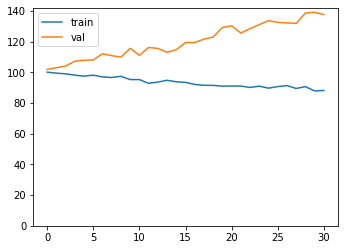

In [13]:
REQ_NAME = 'blurred'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    width_shift_range=0.3, 
    height_shift_range=0.3, 
    brightness_range=(0.7, 1.3),
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.7179 - accuracy: 0.5491 - precision: 0.8445 - recall: 0.5726 - f1: 0.6795 - specificity: 0.4379 - negative_predictive_value: 0.1587 - matthews_correlation_coefficient: 0.0059 - equal_error_rate: 0.4718 - val_loss: 0.6899 - val_accuracy: 0.4621 - val_precision: 0.9428 - val_recall: 0.3837 - val_f1: 0.5426 - val_specificity: 0.8681 - val_negative_predictive_value: 0.2076 - val_matthews_correlation_coefficient: 0.1936 - val_equal_error_rate: 0.3903

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.19361, saving model to ../../models/siamese_networks/blurred_2020_06_25-23_53_18.h5
Epoch 2/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6943 - accuracy: 0.5480 - precision: 0.8699 - recall: 0.5455 - f1: 0.6670 - specificity: 0.5621 - negative_predictive_value: 0.1879 - matthews_correlation_coefficient: 0.0786 - equal_

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6501 - accuracy: 0.5918 - precision: 0.8955 - recall: 0.5847 - f1: 0.7055 - specificity: 0.6323 - negative_predictive_value: 0.2212 - matthews_correlation_coefficient: 0.1586 - equal_error_rate: 0.3854 - val_loss: 0.6568 - val_accuracy: 0.4987 - val_precision: 0.9605 - val_recall: 0.4168 - val_f1: 0.5760 - val_specificity: 0.8938 - val_negative_predictive_value: 0.2231 - val_matthews_correlation_coefficient: 0.2376 - val_equal_error_rate: 0.3026

Epoch 00013: val_matthews_correlation_coefficient improved from 0.23527 to 0.23762, saving model to ../../models/siamese_networks/blurred_2020_06_25-23_53_18.h5
Epoch 14/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6436 - accuracy: 0.6030 - precision: 0.8953 - recall: 0.5989 - f1: 0.7165 - specificity: 0.6242 - negative_predictive_value: 0.2260 - matthews_correlation_coefficient: 0.1638 - equal_error_rate: 0.3855 - val_loss: 0.6441 - val_accuracy: 0.

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6357 - accuracy: 0.6019 - precision: 0.8964 - recall: 0.5968 - f1: 0.7155 - specificity: 0.6290 - negative_predictive_value: 0.2253 - matthews_correlation_coefficient: 0.1653 - equal_error_rate: 0.3737 - val_loss: 0.6528 - val_accuracy: 0.5327 - val_precision: 0.9671 - val_recall: 0.4590 - val_f1: 0.6195 - val_specificity: 0.9096 - val_negative_predictive_value: 0.2384 - val_matthews_correlation_coefficient: 0.2739 - val_equal_error_rate: 0.2837

Epoch 00025: val_matthews_correlation_coefficient did not improve from 0.28335
Epoch 26/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6368 - accuracy: 0.6001 - precision: 0.9069 - recall: 0.5858 - f1: 0.7103 - specificity: 0.6793 - negative_predictive_value: 0.2329 - matthews_correlation_coefficient: 0.1917 - equal_error_rate: 0.3640 - val_loss: 0.6355 - val_accuracy: 0.5650 - val_precision: 0.9626 - val_recall: 0.5018 - val_f1: 0.6566 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6442 - accuracy: 0.6060 - precision: 0.9006 - recall: 0.5993 - f1: 0.7182 - specificity: 0.6425 - negative_predictive_value: 0.2311 - matthews_correlation_coefficient: 0.1777 - equal_error_rate: 0.3678 - val_loss: 0.6437 - val_accuracy: 0.5536 - val_precision: 0.9702 - val_recall: 0.4849 - val_f1: 0.6441 - val_specificity: 0.9145 - val_negative_predictive_value: 0.2482 - val_matthews_correlation_coefficient: 0.2939 - val_equal_error_rate: 0.2859

Epoch 00038: val_matthews_correlation_coefficient did not improve from 0.29775
Epoch 39/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6361 - accuracy: 0.6058 - precision: 0.9011 - recall: 0.5996 - f1: 0.7188 - specificity: 0.6407 - negative_predictive_value: 0.2306 - matthews_correlation_coefficient: 0.1771 - equal_error_rate: 0.3730 - val_loss: 0.6331 - val_accuracy: 0.5676 - val_precision: 0.9694 - val_recall: 0.5016 - val_f1: 0.6584 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6322 - accuracy: 0.6213 - precision: 0.9069 - recall: 0.6137 - f1: 0.7309 - specificity: 0.6629 - negative_predictive_value: 0.2412 - matthews_correlation_coefficient: 0.2016 - equal_error_rate: 0.3545 - val_loss: 0.6540 - val_accuracy: 0.5423 - val_precision: 0.9767 - val_recall: 0.4672 - val_f1: 0.6294 - val_specificity: 0.9340 - val_negative_predictive_value: 0.2467 - val_matthews_correlation_coefficient: 0.2980 - val_equal_error_rate: 0.2846

Epoch 00051: val_matthews_correlation_coefficient did not improve from 0.30338
Epoch 52/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6225 - accuracy: 0.6219 - precision: 0.9050 - recall: 0.6150 - f1: 0.7313 - specificity: 0.6467 - negative_predictive_value: 0.2385 - matthews_correlation_coefficient: 0.1929 - equal_error_rate: 0.3608 - val_loss: 0.6412 - val_accuracy: 0.5597 - val_precision: 0.9727 - val_recall: 0.4912 - val_f1: 0.6504 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6294 - accuracy: 0.6082 - precision: 0.9091 - recall: 0.5952 - f1: 0.7180 - specificity: 0.6817 - negative_predictive_value: 0.2388 - matthews_correlation_coefficient: 0.2016 - equal_error_rate: 0.3585 - val_loss: 0.6579 - val_accuracy: 0.5318 - val_precision: 0.9812 - val_recall: 0.4513 - val_f1: 0.6152 - val_specificity: 0.9427 - val_negative_predictive_value: 0.2433 - val_matthews_correlation_coefficient: 0.2961 - val_equal_error_rate: 0.2790

Epoch 00064: val_matthews_correlation_coefficient did not improve from 0.32264
Epoch 65/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6397 - accuracy: 0.6078 - precision: 0.9066 - recall: 0.5976 - f1: 0.7184 - specificity: 0.6687 - negative_predictive_value: 0.2346 - matthews_correlation_coefficient: 0.1930 - equal_error_rate: 0.3672 - val_loss: 0.6493 - val_accuracy: 0.5466 - val_precision: 0.9752 - val_recall: 0.4723 - val_f1: 0.6337 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6258 - accuracy: 0.6187 - precision: 0.9066 - recall: 0.6100 - f1: 0.7283 - specificity: 0.6680 - negative_predictive_value: 0.2419 - matthews_correlation_coefficient: 0.2026 - equal_error_rate: 0.3641 - val_loss: 0.6544 - val_accuracy: 0.5379 - val_precision: 0.9772 - val_recall: 0.4603 - val_f1: 0.6227 - val_specificity: 0.9340 - val_negative_predictive_value: 0.2446 - val_matthews_correlation_coefficient: 0.2943 - val_equal_error_rate: 0.2794

Epoch 00077: val_matthews_correlation_coefficient did not improve from 0.32264
Epoch 78/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6301 - accuracy: 0.6141 - precision: 0.8980 - recall: 0.6128 - f1: 0.7270 - specificity: 0.6323 - negative_predictive_value: 0.2330 - matthews_correlation_coefficient: 0.1785 - equal_error_rate: 0.3656 - val_loss: 0.6536 - val_accuracy: 0.5405 - val_precision: 0.9774 - val_recall: 0.4634 - val_f1: 0.6254 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6364 - accuracy: 0.6012 - precision: 0.9033 - recall: 0.5908 - f1: 0.7123 - specificity: 0.6622 - negative_predictive_value: 0.2319 - matthews_correlation_coefficient: 0.1842 - equal_error_rate: 0.3618 - val_loss: 0.6771 - val_accuracy: 0.5083 - val_precision: 0.9828 - val_recall: 0.4226 - val_f1: 0.5879 - val_specificity: 0.9471 - val_negative_predictive_value: 0.2349 - val_matthews_correlation_coefficient: 0.2823 - val_equal_error_rate: 0.2780

Epoch 00090: val_matthews_correlation_coefficient did not improve from 0.32264
Epoch 91/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6304 - accuracy: 0.6158 - precision: 0.9099 - recall: 0.6041 - f1: 0.7248 - specificity: 0.6792 - negative_predictive_value: 0.2434 - matthews_correlation_coefficient: 0.2075 - equal_error_rate: 0.3644 - val_loss: 0.6595 - val_accuracy: 0.5292 - val_precision: 0.9812 - val_recall: 0.4485 - val_f1: 0.6125 - val_specifici

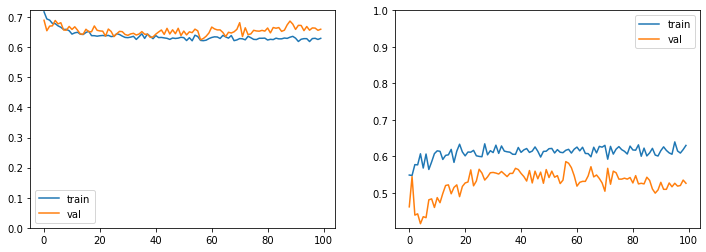

In [14]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks]).astype(np.int32)

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 3. Looking Away

146 of 146
159 of 159
(243, 224, 224, 3) float32
(243,) int32
(62, 224, 224, 3) float32
(62,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 93s 932ms/step - loss: 100.3651 - val_loss: 100.5666
Epoch 2/100
100/100 [==============================] - 91s 908ms/step - loss: 100.1239 - val_loss: 100.6130
Epoch 3/100
100/100 [==============================] - 91s 912ms/step - loss: 99.9213 - val_loss: 99.8228
Epoch 4/100
100/100 [==============================] - 90s 898ms/step - loss: 100.4597 - val_loss: 99.6399
Epoch 5/100
100/100 [==============================] - 91s 908ms/step - loss: 99.7532 - val_loss: 99.5899
Epoch 6/100
100/100 [==============================] - 91s 912ms/step - loss: 99.8070 - val_loss: 98.9374
Epoch 7/100
100/100 [==============================] - 90s 905ms/step - loss: 99.9254 - val_loss: 99.1471
Epoch 8/100
100/100 [==============================] - 90s 904ms/step - loss: 99.7553 - val_loss: 100.0408
Epoch 9/100
100/100 [==============================] - 91s 913ms/step - loss: 99.6303 - val_loss: 100.5484
Epoch 10/100
100/100 [=================

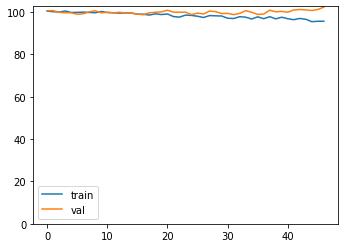

In [15]:
REQ_NAME = 'looking_away'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 14s 3ms/step - loss: 0.7430 - accuracy: 0.5502 - precision: 0.6922 - recall: 0.6033 - f1: 0.6337 - specificity: 0.4117 - negative_predictive_value: 0.3200 - matthews_correlation_coefficient: 0.0137 - equal_error_rate: 0.4825 - val_loss: 0.6496 - val_accuracy: 0.6870 - val_precision: 0.6901 - val_recall: 0.9841 - val_f1: 0.8108 - val_specificity: 0.0358 - val_negative_predictive_value: 0.4722 - val_matthews_correlation_coefficient: 0.0569 - val_equal_error_rate: 0.4385

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.05693, saving model to ../../models/siamese_networks/looking_away_2020_06_26-01_26_20.h5
Epoch 2/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7272 - accuracy: 0.5205 - precision: 0.7082 - recall: 0.5197 - f1: 0.5951 - specificity: 0.5258 - negative_predictive_value: 0.3313 - matthews_correlation_coefficient: 0.0423 - e

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6963 - accuracy: 0.5432 - precision: 0.7210 - recall: 0.5508 - f1: 0.6199 - specificity: 0.5332 - negative_predictive_value: 0.3534 - matthews_correlation_coefficient: 0.0790 - equal_error_rate: 0.4597 - val_loss: 0.6767 - val_accuracy: 0.5798 - val_precision: 0.7352 - val_recall: 0.6063 - val_f1: 0.6624 - val_specificity: 0.5282 - val_negative_predictive_value: 0.3815 - val_matthews_correlation_coefficient: 0.1251 - val_equal_error_rate: 0.4214

Epoch 00013: val_matthews_correlation_coefficient improved from 0.11990 to 0.12515, saving model to ../../models/siamese_networks/looking_away_2020_06_26-01_26_20.h5
Epoch 14/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6923 - accuracy: 0.5323 - precision: 0.7199 - recall: 0.5200 - f1: 0.5993 - specificity: 0.5573 - negative_predictive_value: 0.3481 - matthews_correlation_coefficient: 0.0725 - equal_error_rate: 0.4648 - val_loss: 0.6635 - val_accurac


Epoch 00025: val_matthews_correlation_coefficient did not improve from 0.15146
Epoch 26/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6859 - accuracy: 0.5397 - precision: 0.7301 - recall: 0.5230 - f1: 0.6069 - specificity: 0.5757 - negative_predictive_value: 0.3553 - matthews_correlation_coefficient: 0.0917 - equal_error_rate: 0.4399 - val_loss: 0.6743 - val_accuracy: 0.5798 - val_precision: 0.7367 - val_recall: 0.6024 - val_f1: 0.6607 - val_specificity: 0.5344 - val_negative_predictive_value: 0.3825 - val_matthews_correlation_coefficient: 0.1276 - val_equal_error_rate: 0.4204

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.15146
Epoch 27/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6846 - accuracy: 0.5556 - precision: 0.7403 - recall: 0.5450 - f1: 0.6251 - specificity: 0.5834 - negative_predictive_value: 0.3700 - matthews_correlation_coefficient: 0.1189 - equal_error_rate: 0.4341 - val_loss: 0.6667 - val_a


Epoch 00038: val_matthews_correlation_coefficient did not improve from 0.16750
Epoch 39/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6817 - accuracy: 0.5805 - precision: 0.7514 - recall: 0.5868 - f1: 0.6559 - specificity: 0.5744 - negative_predictive_value: 0.3858 - matthews_correlation_coefficient: 0.1485 - equal_error_rate: 0.4254 - val_loss: 0.6895 - val_accuracy: 0.5545 - val_precision: 0.7768 - val_recall: 0.4903 - val_f1: 0.5996 - val_specificity: 0.6990 - val_negative_predictive_value: 0.3864 - val_matthews_correlation_coefficient: 0.1758 - val_equal_error_rate: 0.4262

Epoch 00039: val_matthews_correlation_coefficient improved from 0.16750 to 0.17577, saving model to ../../models/siamese_networks/looking_away_2020_06_26-01_26_20.h5
Epoch 40/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6863 - accuracy: 0.5515 - precision: 0.7295 - recall: 0.5544 - f1: 0.6258 - specificity: 0.5492 - negative_predictive_value: 0.3636 - matthew

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6841 - accuracy: 0.5609 - precision: 0.7383 - recall: 0.5585 - f1: 0.6305 - specificity: 0.5705 - negative_predictive_value: 0.3761 - matthews_correlation_coefficient: 0.1213 - equal_error_rate: 0.4347 - val_loss: 0.7160 - val_accuracy: 0.4377 - val_precision: 0.7955 - val_recall: 0.2431 - val_f1: 0.3701 - val_specificity: 0.8682 - val_negative_predictive_value: 0.3446 - val_matthews_correlation_coefficient: 0.1246 - val_equal_error_rate: 0.4207

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.17652
Epoch 53/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6829 - accuracy: 0.5589 - precision: 0.7440 - recall: 0.5465 - f1: 0.6235 - specificity: 0.5878 - negative_predictive_value: 0.3762 - matthews_correlation_coefficient: 0.1269 - equal_error_rate: 0.4294 - val_loss: 0.6997 - val_accuracy: 0.5214 - val_precision: 0.7839 - val_recall: 0.4152 - val_f1: 0.5392 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6843 - accuracy: 0.5476 - precision: 0.7369 - recall: 0.5337 - f1: 0.6164 - specificity: 0.5840 - negative_predictive_value: 0.3633 - matthews_correlation_coefficient: 0.1085 - equal_error_rate: 0.4413 - val_loss: 0.6922 - val_accuracy: 0.5432 - val_precision: 0.7749 - val_recall: 0.4700 - val_f1: 0.5831 - val_specificity: 0.7077 - val_negative_predictive_value: 0.3808 - val_matthews_correlation_coefficient: 0.1663 - val_equal_error_rate: 0.4248

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.17652
Epoch 66/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6827 - accuracy: 0.5670 - precision: 0.7415 - recall: 0.5682 - f1: 0.6395 - specificity: 0.5682 - negative_predictive_value: 0.3778 - matthews_correlation_coefficient: 0.1274 - equal_error_rate: 0.4313 - val_loss: 0.6865 - val_accuracy: 0.5580 - val_precision: 0.7687 - val_recall: 0.5102 - val_f1: 0.6115 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6794 - accuracy: 0.5716 - precision: 0.7418 - recall: 0.5765 - f1: 0.6449 - specificity: 0.5637 - negative_predictive_value: 0.3799 - matthews_correlation_coefficient: 0.1305 - equal_error_rate: 0.4281 - val_loss: 0.6902 - val_accuracy: 0.5379 - val_precision: 0.7723 - val_recall: 0.4626 - val_f1: 0.5765 - val_specificity: 0.7079 - val_negative_predictive_value: 0.3774 - val_matthews_correlation_coefficient: 0.1597 - val_equal_error_rate: 0.4264

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.17652
Epoch 79/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6826 - accuracy: 0.5554 - precision: 0.7374 - recall: 0.5490 - f1: 0.6247 - specificity: 0.5736 - negative_predictive_value: 0.3694 - matthews_correlation_coefficient: 0.1143 - equal_error_rate: 0.4318 - val_loss: 0.7035 - val_accuracy: 0.4969 - val_precision: 0.7960 - val_recall: 0.3584 - val_f1: 0.4907 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6798 - accuracy: 0.5731 - precision: 0.7460 - recall: 0.5732 - f1: 0.6460 - specificity: 0.5785 - negative_predictive_value: 0.3828 - matthews_correlation_coefficient: 0.1396 - equal_error_rate: 0.4234 - val_loss: 0.6951 - val_accuracy: 0.5353 - val_precision: 0.7719 - val_recall: 0.4566 - val_f1: 0.5714 - val_specificity: 0.7138 - val_negative_predictive_value: 0.3772 - val_matthews_correlation_coefficient: 0.1593 - val_equal_error_rate: 0.4252

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.17652
Epoch 92/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6861 - accuracy: 0.5582 - precision: 0.7236 - recall: 0.5760 - f1: 0.6380 - specificity: 0.5182 - negative_predictive_value: 0.3580 - matthews_correlation_coefficient: 0.0876 - equal_error_rate: 0.4523 - val_loss: 0.7150 - val_accuracy: 0.4525 - val_precision: 0.8097 - val_recall: 0.2654 - val_f1: 0.3968 - val_specifici

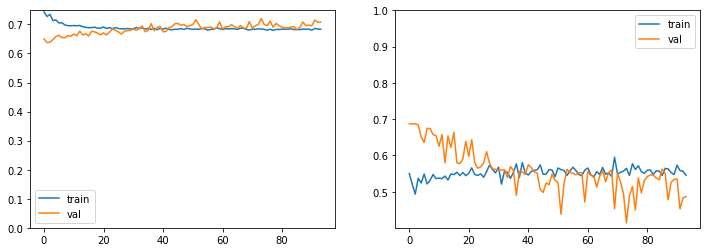

In [16]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### ~~4. Ink Marked/Creased~~

#### 5. Unnatural Skin Tone 

63 of 63
51 of 51
(90, 224, 224, 3) float32
(90,) int32
(24, 224, 224, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 76s 755ms/step - loss: 97.4407 - val_loss: 106.0738
Epoch 2/100
100/100 [==============================] - 74s 744ms/step - loss: 87.9019 - val_loss: 111.3679
Epoch 3/100
100/100 [==============================] - 74s 744ms/step - loss: 80.0013 - val_loss: 114.6667
Epoch 4/100
100/100 [==============================] - 74s 744ms/step - loss: 73.3556 - val_loss: 116.8382
Epoch 5/100
100/100 [==============================] - 74s 744ms/step - loss: 66.0528 - val_loss: 118.8149
Epoch 6/100
100/100 [==============================] - 74s 744ms/step - loss: 59.7067 - val_loss: 118.8403
Epoch 7/100
100/100 [==============================] - 75s 747ms/step - loss: 59.5558 - val_loss: 117.1952
Epoch 8/100
100/100 [==============================] - 74s 744ms/step - loss: 55.4675 - val_loss: 114.9652
Epoch 9/100
100/100 [==============================] - 74s 744ms/step - loss: 56.0266 - val_loss: 115.4098
Epoch 10/100
100/100 [===============

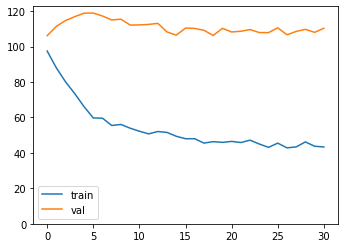

In [17]:
REQ_NAME = 'unnatural_skin_tone'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 14s 3ms/step - loss: 0.7480 - accuracy: 0.4821 - precision: 0.4298 - recall: 0.5078 - f1: 0.4613 - specificity: 0.4622 - negative_predictive_value: 0.5388 - matthews_correlation_coefficient: -0.0307 - equal_error_rate: 0.5200 - val_loss: 0.7015 - val_accuracy: 0.4752 - val_precision: 0.4064 - val_recall: 0.4490 - val_f1: 0.4239 - val_specificity: 0.4931 - val_negative_predictive_value: 0.5355 - val_matthews_correlation_coefficient: -0.0580 - val_equal_error_rate: 0.5323

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.05800, saving model to ../../models/siamese_networks/unnatural_skin_tone_2020_06_26-02_25_13.h5
Epoch 2/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7367 - accuracy: 0.4959 - precision: 0.4307 - recall: 0.4244 - f1: 0.4242 - specificity: 0.5511 - negative_predictive_value: 0.5459 - matthews_correlation_coefficient: 

4584/4584 [==============================] - 13s 3ms/step - loss: 0.7005 - accuracy: 0.5083 - precision: 0.4454 - recall: 0.4610 - f1: 0.4492 - specificity: 0.5448 - negative_predictive_value: 0.5611 - matthews_correlation_coefficient: 0.0061 - equal_error_rate: 0.4965 - val_loss: 0.6868 - val_accuracy: 0.5466 - val_precision: 0.4740 - val_recall: 0.4288 - val_f1: 0.4471 - val_specificity: 0.6318 - val_negative_predictive_value: 0.5859 - val_matthews_correlation_coefficient: 0.0602 - val_equal_error_rate: 0.4563

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.08180
Epoch 14/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6966 - accuracy: 0.5076 - precision: 0.4517 - recall: 0.5297 - f1: 0.4847 - specificity: 0.4894 - negative_predictive_value: 0.5675 - matthews_correlation_coefficient: 0.0192 - equal_error_rate: 0.4880 - val_loss: 0.6838 - val_accuracy: 0.5423 - val_precision: 0.4629 - val_recall: 0.2778 - val_f1: 0.3427 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6904 - accuracy: 0.5347 - precision: 0.4769 - recall: 0.5120 - f1: 0.4900 - specificity: 0.5556 - negative_predictive_value: 0.5904 - matthews_correlation_coefficient: 0.0675 - equal_error_rate: 0.4688 - val_loss: 0.6848 - val_accuracy: 0.5362 - val_precision: 0.4743 - val_recall: 0.6318 - val_f1: 0.5392 - val_specificity: 0.4535 - val_negative_predictive_value: 0.6119 - val_matthews_correlation_coefficient: 0.0858 - val_equal_error_rate: 0.4583

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.10524
Epoch 27/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6873 - accuracy: 0.5438 - precision: 0.4868 - recall: 0.5571 - f1: 0.5154 - specificity: 0.5362 - negative_predictive_value: 0.6043 - matthews_correlation_coefficient: 0.0921 - equal_error_rate: 0.4543 - val_loss: 0.6845 - val_accuracy: 0.5362 - val_precision: 0.4766 - val_recall: 0.6496 - val_f1: 0.5470 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6860 - accuracy: 0.5495 - precision: 0.4928 - recall: 0.5219 - f1: 0.4993 - specificity: 0.5753 - negative_predictive_value: 0.6047 - matthews_correlation_coefficient: 0.0973 - equal_error_rate: 0.4459 - val_loss: 0.6842 - val_accuracy: 0.5336 - val_precision: 0.4756 - val_recall: 0.7153 - val_f1: 0.5690 - val_specificity: 0.3811 - val_negative_predictive_value: 0.6282 - val_matthews_correlation_coefficient: 0.0998 - val_equal_error_rate: 0.4495

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.11228
Epoch 40/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6871 - accuracy: 0.5377 - precision: 0.4803 - recall: 0.5468 - f1: 0.5057 - specificity: 0.5329 - negative_predictive_value: 0.5991 - matthews_correlation_coefficient: 0.0795 - equal_error_rate: 0.4641 - val_loss: 0.6821 - val_accuracy: 0.5449 - val_precision: 0.4822 - val_recall: 0.6436 - val_f1: 0.5485 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6893 - accuracy: 0.5327 - precision: 0.4754 - recall: 0.5365 - f1: 0.5010 - specificity: 0.5322 - negative_predictive_value: 0.5920 - matthews_correlation_coefficient: 0.0680 - equal_error_rate: 0.4655 - val_loss: 0.6798 - val_accuracy: 0.5562 - val_precision: 0.4901 - val_recall: 0.5991 - val_f1: 0.5357 - val_specificity: 0.5122 - val_negative_predictive_value: 0.6200 - val_matthews_correlation_coefficient: 0.1106 - val_equal_error_rate: 0.4473

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.11228
Epoch 53/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6846 - accuracy: 0.5526 - precision: 0.4948 - recall: 0.5388 - f1: 0.5126 - specificity: 0.5642 - negative_predictive_value: 0.6071 - matthews_correlation_coefficient: 0.1024 - equal_error_rate: 0.4521 - val_loss: 0.6811 - val_accuracy: 0.5449 - val_precision: 0.4805 - val_recall: 0.6320 - val_f1: 0.5432 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6858 - accuracy: 0.5399 - precision: 0.4868 - recall: 0.5928 - f1: 0.5304 - specificity: 0.4995 - negative_predictive_value: 0.6039 - matthews_correlation_coefficient: 0.0915 - equal_error_rate: 0.4526 - val_loss: 0.6791 - val_accuracy: 0.5510 - val_precision: 0.4845 - val_recall: 0.5903 - val_f1: 0.5292 - val_specificity: 0.5089 - val_negative_predictive_value: 0.6137 - val_matthews_correlation_coefficient: 0.0986 - val_equal_error_rate: 0.4623

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.11498
Epoch 66/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6852 - accuracy: 0.5497 - precision: 0.4933 - recall: 0.5882 - f1: 0.5326 - specificity: 0.5191 - negative_predictive_value: 0.6137 - matthews_correlation_coefficient: 0.1071 - equal_error_rate: 0.4473 - val_loss: 0.6786 - val_accuracy: 0.5519 - val_precision: 0.4862 - val_recall: 0.5857 - val_f1: 0.5281 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6901 - accuracy: 0.5308 - precision: 0.4742 - recall: 0.5560 - f1: 0.5073 - specificity: 0.5107 - negative_predictive_value: 0.5931 - matthews_correlation_coefficient: 0.0671 - equal_error_rate: 0.4719 - val_loss: 0.6829 - val_accuracy: 0.5379 - val_precision: 0.4793 - val_recall: 0.7748 - val_f1: 0.5898 - val_specificity: 0.3411 - val_negative_predictive_value: 0.6580 - val_matthews_correlation_coefficient: 0.1258 - val_equal_error_rate: 0.4540

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.14205
Epoch 79/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6897 - accuracy: 0.5410 - precision: 0.4846 - recall: 0.5323 - f1: 0.5035 - specificity: 0.5498 - negative_predictive_value: 0.5967 - matthews_correlation_coefficient: 0.0816 - equal_error_rate: 0.4601 - val_loss: 0.6821 - val_accuracy: 0.5379 - val_precision: 0.4781 - val_recall: 0.7360 - val_f1: 0.5769 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6845 - accuracy: 0.5460 - precision: 0.4907 - recall: 0.5634 - f1: 0.5204 - specificity: 0.5337 - negative_predictive_value: 0.6065 - matthews_correlation_coefficient: 0.0971 - equal_error_rate: 0.4504 - val_loss: 0.6813 - val_accuracy: 0.5344 - val_precision: 0.4757 - val_recall: 0.7127 - val_f1: 0.5678 - val_specificity: 0.3845 - val_negative_predictive_value: 0.6293 - val_matthews_correlation_coefficient: 0.1009 - val_equal_error_rate: 0.4593

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.14205
Epoch 92/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6876 - accuracy: 0.5408 - precision: 0.4821 - recall: 0.5396 - f1: 0.5029 - specificity: 0.5432 - negative_predictive_value: 0.6016 - matthews_correlation_coefficient: 0.0832 - equal_error_rate: 0.4583 - val_loss: 0.6805 - val_accuracy: 0.5379 - val_precision: 0.4781 - val_recall: 0.7092 - val_f1: 0.5680 - val_specifici

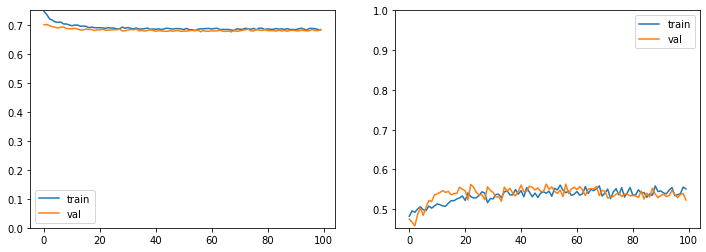

In [18]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 6. Too Dark/Light 

78 of 78
74 of 74
(121, 224, 224, 3) float32
(121,) int32
(31, 224, 224, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 77s 771ms/step - loss: 97.8070 - val_loss: 98.7970
Epoch 2/100
100/100 [==============================] - 76s 758ms/step - loss: 93.8648 - val_loss: 98.3154
Epoch 3/100
100/100 [==============================] - 76s 758ms/step - loss: 90.6503 - val_loss: 95.5846
Epoch 4/100
100/100 [==============================] - 76s 758ms/step - loss: 89.6206 - val_loss: 91.1800
Epoch 5/100
100/100 [==============================] - 76s 758ms/step - loss: 87.5842 - val_loss: 86.7672
Epoch 6/100
100/100 [==============================] - 76s 758ms/step - loss: 87.3759 - val_loss: 88.3854
Epoch 7/100
100/100 [==============================] - 76s 761ms/step - loss: 84.6281 - val_loss: 92.1565
Epoch 8/100
100/100 [==============================] - 76s 758ms/step - loss: 82.4551 - val_loss: 91.3548
Epoch 9/100
100/100 [==============================] - 76s 758ms/step - loss: 81.7107 - val_loss: 95.8407
Epoch 10/100
100/100 [========================

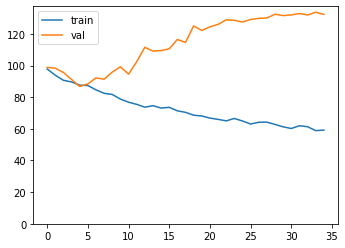

In [19]:
REQ_NAME = 'too_dark_light'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 14s 3ms/step - loss: 0.7636 - accuracy: 0.5039 - precision: 0.9160 - recall: 0.5079 - f1: 0.6493 - specificity: 0.4547 - negative_predictive_value: 0.0766 - matthews_correlation_coefficient: -0.0163 - equal_error_rate: 0.4921 - val_loss: 0.6401 - val_accuracy: 0.6905 - val_precision: 0.9176 - val_recall: 0.7291 - val_f1: 0.8115 - val_specificity: 0.2330 - val_negative_predictive_value: 0.0661 - val_matthews_correlation_coefficient: -0.0243 - val_equal_error_rate: 0.5268

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.02427, saving model to ../../models/siamese_networks/too_dark_light_2020_06_26-03_31_20.h5
Epoch 2/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7307 - accuracy: 0.5020 - precision: 0.9246 - recall: 0.4992 - f1: 0.6468 - specificity: 0.5243 - negative_predictive_value: 0.0835 - matthews_correlation_coefficient: 0.013

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6851 - accuracy: 0.5556 - precision: 0.9381 - recall: 0.5551 - f1: 0.6959 - specificity: 0.5718 - negative_predictive_value: 0.0995 - matthews_correlation_coefficient: 0.0681 - equal_error_rate: 0.4214 - val_loss: 0.7190 - val_accuracy: 0.4760 - val_precision: 0.9420 - val_recall: 0.4632 - val_f1: 0.6191 - val_specificity: 0.6576 - val_negative_predictive_value: 0.0917 - val_matthews_correlation_coefficient: 0.0636 - val_equal_error_rate: 0.3937

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.09426
Epoch 15/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6909 - accuracy: 0.5724 - precision: 0.9335 - recall: 0.5775 - f1: 0.7116 - specificity: 0.5162 - negative_predictive_value: 0.0946 - matthews_correlation_coefficient: 0.0505 - equal_error_rate: 0.4269 - val_loss: 0.7249 - val_accuracy: 0.4708 - val_precision: 0.9433 - val_recall: 0.4562 - val_f1: 0.6131 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6706 - accuracy: 0.5628 - precision: 0.9423 - recall: 0.5608 - f1: 0.6998 - specificity: 0.6118 - negative_predictive_value: 0.1059 - matthews_correlation_coefficient: 0.0887 - equal_error_rate: 0.3804 - val_loss: 0.7495 - val_accuracy: 0.4734 - val_precision: 0.9413 - val_recall: 0.4607 - val_f1: 0.6166 - val_specificity: 0.6576 - val_negative_predictive_value: 0.0920 - val_matthews_correlation_coefficient: 0.0626 - val_equal_error_rate: 0.3913

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.09426
Epoch 28/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6658 - accuracy: 0.5836 - precision: 0.9391 - recall: 0.5856 - f1: 0.7203 - specificity: 0.5567 - negative_predictive_value: 0.1031 - matthews_correlation_coefficient: 0.0773 - equal_error_rate: 0.4140 - val_loss: 0.7433 - val_accuracy: 0.4769 - val_precision: 0.9418 - val_recall: 0.4635 - val_f1: 0.6195 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6773 - accuracy: 0.6355 - precision: 0.9372 - recall: 0.6467 - f1: 0.7630 - specificity: 0.4968 - negative_predictive_value: 0.1085 - matthews_correlation_coefficient: 0.0799 - equal_error_rate: 0.4178 - val_loss: 0.7781 - val_accuracy: 0.3984 - val_precision: 0.9517 - val_recall: 0.3686 - val_f1: 0.5295 - val_specificity: 0.7653 - val_negative_predictive_value: 0.0918 - val_matthews_correlation_coefficient: 0.0751 - val_equal_error_rate: 0.3836

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.09426
Epoch 41/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6559 - accuracy: 0.5868 - precision: 0.9521 - recall: 0.5816 - f1: 0.7189 - specificity: 0.6648 - negative_predictive_value: 0.1182 - matthews_correlation_coefficient: 0.1282 - equal_error_rate: 0.3604 - val_loss: 0.7323 - val_accuracy: 0.5205 - val_precision: 0.9440 - val_recall: 0.5122 - val_f1: 0.6619 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6676 - accuracy: 0.6235 - precision: 0.9429 - recall: 0.6295 - f1: 0.7523 - specificity: 0.5534 - negative_predictive_value: 0.1144 - matthews_correlation_coefficient: 0.1002 - equal_error_rate: 0.3998 - val_loss: 0.7756 - val_accuracy: 0.4429 - val_precision: 0.9462 - val_recall: 0.4245 - val_f1: 0.5838 - val_specificity: 0.7080 - val_negative_predictive_value: 0.0928 - val_matthews_correlation_coefficient: 0.0712 - val_equal_error_rate: 0.3661

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.09426
Epoch 54/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6539 - accuracy: 0.6051 - precision: 0.9507 - recall: 0.6026 - f1: 0.7350 - specificity: 0.6409 - negative_predictive_value: 0.1238 - matthews_correlation_coefficient: 0.1328 - equal_error_rate: 0.3638 - val_loss: 0.7324 - val_accuracy: 0.5275 - val_precision: 0.9462 - val_recall: 0.5196 - val_f1: 0.6685 - val_specifici

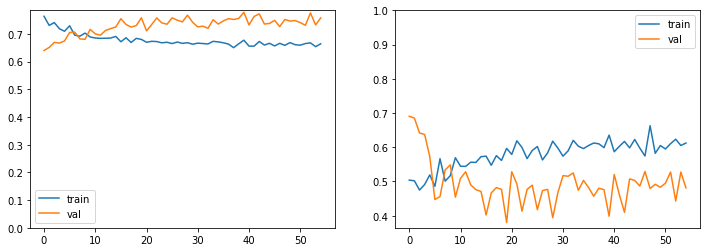

In [20]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 7. Washed Out

79 of 79
43 of 43
(97, 224, 224, 3) float32
(97,) int32
(25, 224, 224, 3) float32
(25,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 75s 750ms/step - loss: 100.4409 - val_loss: 98.9338
Epoch 2/100
100/100 [==============================] - 74s 738ms/step - loss: 100.0425 - val_loss: 99.5971
Epoch 3/100
100/100 [==============================] - 74s 737ms/step - loss: 99.6930 - val_loss: 99.5122
Epoch 4/100
100/100 [==============================] - 74s 737ms/step - loss: 99.7085 - val_loss: 100.4513
Epoch 5/100
100/100 [==============================] - 74s 737ms/step - loss: 99.4193 - val_loss: 100.9907
Epoch 6/100
100/100 [==============================] - 74s 737ms/step - loss: 98.9098 - val_loss: 102.2044
Epoch 7/100
100/100 [==============================] - 74s 737ms/step - loss: 99.0618 - val_loss: 101.4305
Epoch 8/100
100/100 [==============================] - 74s 737ms/step - loss: 98.3159 - val_loss: 103.3925
Epoch 9/100
100/100 [==============================] - 75s 748ms/step - loss: 98.2945 - val_loss: 104.6801
Epoch 10/100
100/100 [================

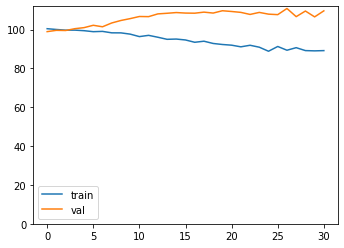

In [21]:
REQ_NAME = 'washed_out'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6898 - accuracy: 0.5207 - precision: 0.9892 - recall: 0.5208 - f1: 0.6805 - specificity: 0.4583 - negative_predictive_value: 0.0145 - matthews_correlation_coefficient: 0.0198 - equal_error_rate: 0.2220 - val_loss: 0.7379 - val_accuracy: 0.3592 - val_precision: 0.9923 - val_recall: 0.3561 - val_f1: 0.5225 - val_specificity: 0.5667 - val_negative_predictive_value: 0.0146 - val_matthews_correlation_coefficient: 0.0223 - val_equal_error_rate: 0.1839

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.02229, saving model to ../../models/siamese_networks/washed_out_2020_06_26-04_21_44.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7316 - accuracy: 0.5698 - precision: 0.9848 - recall: 0.5730 - f1: 0.7229 - specificity: 0.2210 - negative_predictive_value: 0.0092 - matthews_correlation_coefficient: -0.0232 - eq

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6912 - accuracy: 0.6034 - precision: 0.9897 - recall: 0.6050 - f1: 0.7498 - specificity: 0.3681 - negative_predictive_value: 0.0160 - matthews_correlation_coefficient: 0.0219 - equal_error_rate: 0.2046 - val_loss: 0.7705 - val_accuracy: 0.3043 - val_precision: 0.9928 - val_recall: 0.3011 - val_f1: 0.4593 - val_specificity: 0.6500 - val_negative_predictive_value: 0.0147 - val_matthews_correlation_coefficient: 0.0288 - val_equal_error_rate: 0.1662

Epoch 00014: val_matthews_correlation_coefficient improved from 0.02858 to 0.02885, saving model to ../../models/siamese_networks/washed_out_2020_06_26-04_21_44.h5
Epoch 15/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6891 - accuracy: 0.6091 - precision: 0.9902 - recall: 0.6103 - f1: 0.7541 - specificity: 0.3576 - negative_predictive_value: 0.0175 - matthews_correlation_coefficient: 0.0257 - equal_error_rate: 0.2071 - val_loss: 0.7752 - val_accuracy:

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6580 - accuracy: 0.6104 - precision: 0.9916 - recall: 0.6109 - f1: 0.7550 - specificity: 0.4710 - negative_predictive_value: 0.0191 - matthews_correlation_coefficient: 0.0415 - equal_error_rate: 0.1962 - val_loss: 0.8243 - val_accuracy: 0.2127 - val_precision: 0.9958 - val_recall: 0.2034 - val_f1: 0.3359 - val_specificity: 0.6667 - val_negative_predictive_value: 0.0143 - val_matthews_correlation_coefficient: 0.0242 - val_equal_error_rate: 0.1535

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.03784
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6816 - accuracy: 0.6516 - precision: 0.9901 - recall: 0.6539 - f1: 0.7866 - specificity: 0.3678 - negative_predictive_value: 0.0178 - matthews_correlation_coefficient: 0.0308 - equal_error_rate: 0.1955 - val_loss: 0.8317 - val_accuracy: 0.1935 - val_precision: 1.0000 - val_recall: 0.1830 - val_f1: 0.3067 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6622 - accuracy: 0.6267 - precision: 0.9909 - recall: 0.6282 - f1: 0.7676 - specificity: 0.3841 - negative_predictive_value: 0.0185 - matthews_correlation_coefficient: 0.0352 - equal_error_rate: 0.1904 - val_loss: 0.8315 - val_accuracy: 0.2101 - val_precision: 0.9960 - val_recall: 0.2009 - val_f1: 0.3333 - val_specificity: 0.6667 - val_negative_predictive_value: 0.0143 - val_matthews_correlation_coefficient: 0.0247 - val_equal_error_rate: 0.1438

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.04194
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6623 - accuracy: 0.5914 - precision: 0.9897 - recall: 0.5926 - f1: 0.7403 - specificity: 0.3261 - negative_predictive_value: 0.0160 - matthews_correlation_coefficient: 0.0206 - equal_error_rate: 0.1816 - val_loss: 0.8549 - val_accuracy: 0.1508 - val_precision: 1.0000 - val_recall: 0.1389 - val_f1: 0.2411 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6707 - accuracy: 0.6001 - precision: 0.9905 - recall: 0.6007 - f1: 0.7465 - specificity: 0.4167 - negative_predictive_value: 0.0174 - matthews_correlation_coefficient: 0.0301 - equal_error_rate: 0.2004 - val_loss: 0.8445 - val_accuracy: 0.1901 - val_precision: 1.0000 - val_recall: 0.1788 - val_f1: 0.3018 - val_specificity: 0.7500 - val_negative_predictive_value: 0.0150 - val_matthews_correlation_coefficient: 0.0423 - val_equal_error_rate: 0.1379

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.04911
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6751 - accuracy: 0.6095 - precision: 0.9903 - recall: 0.6103 - f1: 0.7545 - specificity: 0.3696 - negative_predictive_value: 0.0169 - matthews_correlation_coefficient: 0.0257 - equal_error_rate: 0.1837 - val_loss: 0.8594 - val_accuracy: 0.1552 - val_precision: 1.0000 - val_recall: 0.1431 - val_f1: 0.2484 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6570 - accuracy: 0.6285 - precision: 0.9914 - recall: 0.6292 - f1: 0.7686 - specificity: 0.4239 - negative_predictive_value: 0.0198 - matthews_correlation_coefficient: 0.0412 - equal_error_rate: 0.1988 - val_loss: 0.8731 - val_accuracy: 0.1412 - val_precision: 1.0000 - val_recall: 0.1287 - val_f1: 0.2257 - val_specificity: 0.7500 - val_negative_predictive_value: 0.0142 - val_matthews_correlation_coefficient: 0.0347 - val_equal_error_rate: 0.1375

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.04911
Epoch 67/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6346 - accuracy: 0.6278 - precision: 0.9946 - recall: 0.6266 - f1: 0.7677 - specificity: 0.5688 - negative_predictive_value: 0.0241 - matthews_correlation_coefficient: 0.0705 - equal_error_rate: 0.1729 - val_loss: 0.8627 - val_accuracy: 0.1718 - val_precision: 1.0000 - val_recall: 0.1601 - val_f1: 0.2741 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6402 - accuracy: 0.6374 - precision: 0.9923 - recall: 0.6379 - f1: 0.7750 - specificity: 0.4652 - negative_predictive_value: 0.0212 - matthews_correlation_coefficient: 0.0497 - equal_error_rate: 0.1884 - val_loss: 0.8396 - val_accuracy: 0.2537 - val_precision: 1.0000 - val_recall: 0.2422 - val_f1: 0.3883 - val_specificity: 0.7500 - val_negative_predictive_value: 0.0160 - val_matthews_correlation_coefficient: 0.0506 - val_equal_error_rate: 0.1346

Epoch 00079: val_matthews_correlation_coefficient improved from 0.04911 to 0.05060, saving model to ../../models/siamese_networks/washed_out_2020_06_26-04_21_44.h5
Epoch 80/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6844 - accuracy: 0.5986 - precision: 0.9902 - recall: 0.5995 - f1: 0.7456 - specificity: 0.3460 - negative_predictive_value: 0.0166 - matthews_correlation_coefficient: 0.0200 - equal_error_rate: 0.1994 - val_loss: 0.8686 - val_accuracy:

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6148 - accuracy: 0.6346 - precision: 0.9945 - recall: 0.6332 - f1: 0.7727 - specificity: 0.5486 - negative_predictive_value: 0.0244 - matthews_correlation_coefficient: 0.0717 - equal_error_rate: 0.1252 - val_loss: 0.8500 - val_accuracy: 0.2485 - val_precision: 1.0000 - val_recall: 0.2371 - val_f1: 0.3820 - val_specificity: 0.7500 - val_negative_predictive_value: 0.0159 - val_matthews_correlation_coefficient: 0.0498 - val_equal_error_rate: 0.1320

Epoch 00092: val_matthews_correlation_coefficient did not improve from 0.05476
Epoch 93/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6566 - accuracy: 0.5982 - precision: 0.9921 - recall: 0.5978 - f1: 0.7448 - specificity: 0.5072 - negative_predictive_value: 0.0195 - matthews_correlation_coefficient: 0.0476 - equal_error_rate: 0.1740 - val_loss: 0.8861 - val_accuracy: 0.1752 - val_precision: 1.0000 - val_recall: 0.1635 - val_f1: 0.2796 - val_specifici

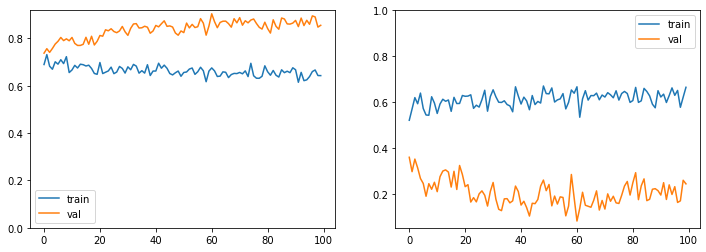

In [22]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 8. Pixelation

79 of 79
105 of 105
(147, 224, 224, 3) float32
(147,) int32
(37, 224, 224, 3) float32
(37,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 89s 892ms/step - loss: 99.4623 - val_loss: 105.3297
Epoch 2/100
100/100 [==============================] - 87s 869ms/step - loss: 98.3891 - val_loss: 116.7869
Epoch 3/100
100/100 [==============================] - 87s 871ms/step - loss: 97.6896 - val_loss: 120.9413
Epoch 4/100
100/100 [==============================] - 88s 877ms/step - loss: 96.1415 - val_loss: 119.5406
Epoch 5/100
100/100 [==============================] - 88s 875ms/step - loss: 95.7637 - val_loss: 118.1076
Epoch 6/100
100/100 [==============================] - 87s 871ms/step - loss: 96.7162 - val_loss: 115.0671
Epoch 7/100
100/100 [==============================] - 87s 871ms/step - loss: 95.6620 - val_loss: 118.1211
Epoch 8/100
100/100 [==============================] - 87s 868ms/step - loss: 94.7020 - val_loss: 116.1985
Epoch 9/100
100/100 [==============================] - 88s 882ms/step - loss: 95.4824 - val_loss: 114.5167
Epoch 10/100
100/100 [===============

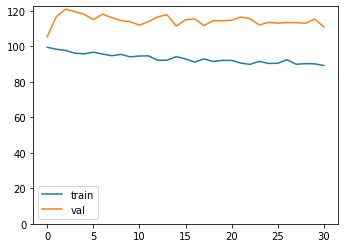

In [23]:
REQ_NAME = 'pixelation'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.7467 - accuracy: 0.6043 - precision: 0.9344 - recall: 0.6195 - f1: 0.7407 - specificity: 0.3541 - negative_predictive_value: 0.0637 - matthews_correlation_coefficient: -0.0076 - equal_error_rate: 0.4880 - val_loss: 0.6652 - val_accuracy: 0.5929 - val_precision: 0.9472 - val_recall: 0.5957 - val_f1: 0.7301 - val_specificity: 0.5229 - val_negative_predictive_value: 0.0799 - val_matthews_correlation_coefficient: 0.0556 - val_equal_error_rate: 0.4404

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.05556, saving model to ../../models/siamese_networks/pixelation_2020_06_26-05_27_38.h5
Epoch 2/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7408 - accuracy: 0.4217 - precision: 0.9319 - recall: 0.4121 - f1: 0.5689 - specificity: 0.5895 - negative_predictive_value: 0.0632 - matthews_correlation_coefficient: -0.0046 - e


Epoch 00013: val_matthews_correlation_coefficient improved from 0.09267 to 0.09467, saving model to ../../models/siamese_networks/pixelation_2020_06_26-05_27_38.h5
Epoch 14/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6981 - accuracy: 0.5425 - precision: 0.9473 - recall: 0.5419 - f1: 0.6880 - specificity: 0.5570 - negative_predictive_value: 0.0775 - matthews_correlation_coefficient: 0.0489 - equal_error_rate: 0.4391 - val_loss: 0.6701 - val_accuracy: 0.6495 - val_precision: 0.9518 - val_recall: 0.6589 - val_f1: 0.7775 - val_specificity: 0.5211 - val_negative_predictive_value: 0.0926 - val_matthews_correlation_coefficient: 0.0875 - val_equal_error_rate: 0.3882

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.09467
Epoch 15/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6876 - accuracy: 0.5129 - precision: 0.9478 - recall: 0.5065 - f1: 0.6587 - specificity: 0.6161 - negative_predictive_value: 0.0767 - matthews_

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6829 - accuracy: 0.5807 - precision: 0.9502 - recall: 0.5824 - f1: 0.7210 - specificity: 0.5692 - negative_predictive_value: 0.0856 - matthews_correlation_coefficient: 0.0724 - equal_error_rate: 0.4011 - val_loss: 0.6608 - val_accuracy: 0.6818 - val_precision: 0.9541 - val_recall: 0.6929 - val_f1: 0.8017 - val_specificity: 0.5211 - val_negative_predictive_value: 0.1020 - val_matthews_correlation_coefficient: 0.1075 - val_equal_error_rate: 0.3774

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.10947
Epoch 28/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6772 - accuracy: 0.5979 - precision: 0.9514 - recall: 0.6002 - f1: 0.7353 - specificity: 0.5506 - negative_predictive_value: 0.0879 - matthews_correlation_coefficient: 0.0747 - equal_error_rate: 0.3949 - val_loss: 0.6669 - val_accuracy: 0.6748 - val_precision: 0.9537 - val_recall: 0.6857 - val_f1: 0.7968 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6767 - accuracy: 0.5452 - precision: 0.9554 - recall: 0.5392 - f1: 0.6879 - specificity: 0.6382 - negative_predictive_value: 0.0863 - matthews_correlation_coefficient: 0.0844 - equal_error_rate: 0.3816 - val_loss: 0.6657 - val_accuracy: 0.6670 - val_precision: 0.9557 - val_recall: 0.6742 - val_f1: 0.7898 - val_specificity: 0.5497 - val_negative_predictive_value: 0.1010 - val_matthews_correlation_coefficient: 0.1104 - val_equal_error_rate: 0.3845

Epoch 00040: val_matthews_correlation_coefficient improved from 0.10947 to 0.11038, saving model to ../../models/siamese_networks/pixelation_2020_06_26-05_27_38.h5
Epoch 41/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6789 - accuracy: 0.5966 - precision: 0.9535 - recall: 0.5983 - f1: 0.7341 - specificity: 0.5765 - negative_predictive_value: 0.0894 - matthews_correlation_coefficient: 0.0846 - equal_error_rate: 0.4016 - val_loss: 0.6592 - val_accuracy:

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6787 - accuracy: 0.5746 - precision: 0.9571 - recall: 0.5714 - f1: 0.7146 - specificity: 0.6243 - negative_predictive_value: 0.0919 - matthews_correlation_coefficient: 0.0978 - equal_error_rate: 0.3738 - val_loss: 0.6709 - val_accuracy: 0.6146 - val_precision: 0.9561 - val_recall: 0.6162 - val_f1: 0.7484 - val_specificity: 0.5887 - val_negative_predictive_value: 0.0920 - val_matthews_correlation_coefficient: 0.0975 - val_equal_error_rate: 0.3682

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.11038
Epoch 54/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6767 - accuracy: 0.6093 - precision: 0.9522 - recall: 0.6131 - f1: 0.7450 - specificity: 0.5634 - negative_predictive_value: 0.0899 - matthews_correlation_coefficient: 0.0856 - equal_error_rate: 0.3997 - val_loss: 0.6760 - val_accuracy: 0.6094 - val_precision: 0.9558 - val_recall: 0.6108 - val_f1: 0.7442 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6804 - accuracy: 0.5452 - precision: 0.9551 - recall: 0.5399 - f1: 0.6880 - specificity: 0.6213 - negative_predictive_value: 0.0862 - matthews_correlation_coefficient: 0.0794 - equal_error_rate: 0.3920 - val_loss: 0.6528 - val_accuracy: 0.6774 - val_precision: 0.9552 - val_recall: 0.6867 - val_f1: 0.7978 - val_specificity: 0.5330 - val_negative_predictive_value: 0.1029 - val_matthews_correlation_coefficient: 0.1107 - val_equal_error_rate: 0.3603

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.11545
Epoch 67/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6757 - accuracy: 0.5770 - precision: 0.9511 - recall: 0.5778 - f1: 0.7183 - specificity: 0.5475 - negative_predictive_value: 0.0839 - matthews_correlation_coefficient: 0.0660 - equal_error_rate: 0.4095 - val_loss: 0.6436 - val_accuracy: 0.6879 - val_precision: 0.9546 - val_recall: 0.6983 - val_f1: 0.8055 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6702 - accuracy: 0.6291 - precision: 0.9575 - recall: 0.6314 - f1: 0.7598 - specificity: 0.5996 - negative_predictive_value: 0.0998 - matthews_correlation_coefficient: 0.1121 - equal_error_rate: 0.3815 - val_loss: 0.6609 - val_accuracy: 0.6347 - val_precision: 0.9586 - val_recall: 0.6358 - val_f1: 0.7635 - val_specificity: 0.6053 - val_negative_predictive_value: 0.0989 - val_matthews_correlation_coefficient: 0.1158 - val_equal_error_rate: 0.3503

Epoch 00079: val_matthews_correlation_coefficient improved from 0.11545 to 0.11582, saving model to ../../models/siamese_networks/pixelation_2020_06_26-05_27_38.h5
Epoch 80/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6763 - accuracy: 0.5713 - precision: 0.9556 - recall: 0.5686 - f1: 0.7112 - specificity: 0.5994 - negative_predictive_value: 0.0899 - matthews_correlation_coefficient: 0.0858 - equal_error_rate: 0.3941 - val_loss: 0.6608 - val_accuracy:

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6781 - accuracy: 0.6060 - precision: 0.9573 - recall: 0.6068 - f1: 0.7416 - specificity: 0.5952 - negative_predictive_value: 0.0957 - matthews_correlation_coefficient: 0.1022 - equal_error_rate: 0.3875 - val_loss: 0.6586 - val_accuracy: 0.6452 - val_precision: 0.9555 - val_recall: 0.6502 - val_f1: 0.7727 - val_specificity: 0.5664 - val_negative_predictive_value: 0.0974 - val_matthews_correlation_coefficient: 0.1048 - val_equal_error_rate: 0.3507

Epoch 00092: val_matthews_correlation_coefficient did not improve from 0.12136
Epoch 93/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6748 - accuracy: 0.5903 - precision: 0.9558 - recall: 0.5904 - f1: 0.7283 - specificity: 0.5903 - negative_predictive_value: 0.0902 - matthews_correlation_coefficient: 0.0902 - equal_error_rate: 0.3970 - val_loss: 0.6537 - val_accuracy: 0.6652 - val_precision: 0.9544 - val_recall: 0.6733 - val_f1: 0.7885 - val_specifici

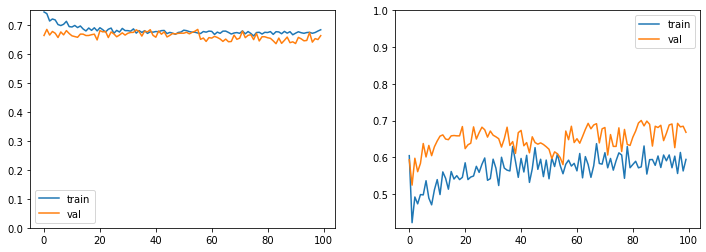

In [24]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 9. Hair Across Eyes 

181 of 181
179 of 179
(287, 224, 224, 3) float32
(287,) int32
(73, 224, 224, 3) float32
(73,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 96s 957ms/step - loss: 98.9268 - val_loss: 94.5059
Epoch 2/100
100/100 [==============================] - 92s 922ms/step - loss: 97.5758 - val_loss: 88.4369
Epoch 3/100
100/100 [==============================] - 92s 922ms/step - loss: 94.6597 - val_loss: 82.2542
Epoch 4/100
100/100 [==============================] - 93s 930ms/step - loss: 92.7033 - val_loss: 79.3359
Epoch 5/100
100/100 [==============================] - 92s 922ms/step - loss: 91.5358 - val_loss: 83.2377
Epoch 6/100
100/100 [==============================] - 92s 923ms/step - loss: 90.1768 - val_loss: 84.8566
Epoch 7/100
100/100 [==============================] - 92s 921ms/step - loss: 90.7219 - val_loss: 83.9648
Epoch 8/100
100/100 [==============================] - 92s 923ms/step - loss: 90.6538 - val_loss: 81.9276
Epoch 9/100
100/100 [==============================] - 92s 923ms/step - loss: 87.9464 - val_loss: 80.6638
Epoch 10/100
100/100 [========================

100/100 [==============================] - 92s 922ms/step - loss: 75.9993 - val_loss: 72.6073
Epoch 78/100
100/100 [==============================] - 92s 921ms/step - loss: 77.4628 - val_loss: 73.2624
Epoch 79/100
100/100 [==============================] - 92s 922ms/step - loss: 75.1889 - val_loss: 73.2083
Epoch 80/100
100/100 [==============================] - 92s 921ms/step - loss: 74.0409 - val_loss: 71.9080
Epoch 81/100
100/100 [==============================] - 92s 922ms/step - loss: 76.9029 - val_loss: 73.4883
Epoch 82/100
100/100 [==============================] - 92s 923ms/step - loss: 75.9101 - val_loss: 72.6098
Epoch 83/100
100/100 [==============================] - 92s 923ms/step - loss: 75.4022 - val_loss: 71.9073
Epoch 84/100
100/100 [==============================] - 92s 921ms/step - loss: 76.4028 - val_loss: 72.2524
Epoch 85/100
100/100 [==============================] - 92s 922ms/step - loss: 75.4122 - val_loss: 72.7113
Epoch 86/100
100/100 [============================

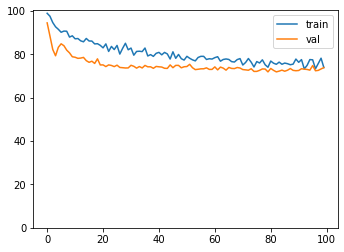

In [25]:
REQ_NAME = 'hair_across_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 14s 3ms/step - loss: 0.7964 - accuracy: 0.4917 - precision: 0.7224 - recall: 0.5049 - f1: 0.5923 - specificity: 0.4552 - negative_predictive_value: 0.2462 - matthews_correlation_coefficient: -0.0354 - equal_error_rate: 0.5129 - val_loss: 0.7598 - val_accuracy: 0.4246 - val_precision: 0.9251 - val_recall: 0.2407 - val_f1: 0.3792 - val_specificity: 0.9429 - val_negative_predictive_value: 0.3046 - val_matthews_correlation_coefficient: 0.2047 - val_equal_error_rate: 0.4218

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20469, saving model to ../../models/siamese_networks/hair_across_eyes_2020_06_26-08_24_05.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6955 - accuracy: 0.5755 - precision: 0.8028 - recall: 0.5647 - f1: 0.6613 - specificity: 0.6079 - negative_predictive_value: 0.3304 - matthews_correlation_coefficient: 0.151

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6157 - accuracy: 0.6442 - precision: 0.8552 - recall: 0.6243 - f1: 0.7195 - specificity: 0.7044 - negative_predictive_value: 0.4018 - matthews_correlation_coefficient: 0.2902 - equal_error_rate: 0.3335 - val_loss: 0.6428 - val_accuracy: 0.5362 - val_precision: 0.9405 - val_recall: 0.3974 - val_f1: 0.5560 - val_specificity: 0.9304 - val_negative_predictive_value: 0.3529 - val_matthews_correlation_coefficient: 0.3095 - val_equal_error_rate: 0.2908

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.34366
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6152 - accuracy: 0.6379 - precision: 0.8763 - recall: 0.5937 - f1: 0.7061 - specificity: 0.7621 - negative_predictive_value: 0.3998 - matthews_correlation_coefficient: 0.3131 - equal_error_rate: 0.3275 - val_loss: 0.6386 - val_accuracy: 0.5466 - val_precision: 0.9420 - val_recall: 0.4108 - val_f1: 0.5697 - val_specifici


Epoch 00025: val_matthews_correlation_coefficient did not improve from 0.42131
Epoch 26/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6057 - accuracy: 0.6514 - precision: 0.8783 - recall: 0.6130 - f1: 0.7198 - specificity: 0.7628 - negative_predictive_value: 0.4132 - matthews_correlation_coefficient: 0.3304 - equal_error_rate: 0.3154 - val_loss: 0.6242 - val_accuracy: 0.5824 - val_precision: 0.9411 - val_recall: 0.4630 - val_f1: 0.6183 - val_specificity: 0.9224 - val_negative_predictive_value: 0.3775 - val_matthews_correlation_coefficient: 0.3499 - val_equal_error_rate: 0.2814

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.42131
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6002 - accuracy: 0.6444 - precision: 0.8734 - recall: 0.6056 - f1: 0.7139 - specificity: 0.7561 - negative_predictive_value: 0.4068 - matthews_correlation_coefficient: 0.3180 - equal_error_rate: 0.3175 - val_loss: 0.6193 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6001 - accuracy: 0.6555 - precision: 0.8786 - recall: 0.6199 - f1: 0.7249 - specificity: 0.7576 - negative_predictive_value: 0.4150 - matthews_correlation_coefficient: 0.3325 - equal_error_rate: 0.3049 - val_loss: 0.6171 - val_accuracy: 0.6408 - val_precision: 0.9396 - val_recall: 0.5468 - val_f1: 0.6895 - val_specificity: 0.9050 - val_negative_predictive_value: 0.4133 - val_matthews_correlation_coefficient: 0.3986 - val_equal_error_rate: 0.2822

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.42282
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5975 - accuracy: 0.6529 - precision: 0.8818 - recall: 0.6134 - f1: 0.7218 - specificity: 0.7673 - negative_predictive_value: 0.4130 - matthews_correlation_coefficient: 0.3346 - equal_error_rate: 0.3130 - val_loss: 0.6064 - val_accuracy: 0.6713 - val_precision: 0.9339 - val_recall: 0.5973 - val_f1: 0.7269 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5993 - accuracy: 0.6634 - precision: 0.8863 - recall: 0.6261 - f1: 0.7313 - specificity: 0.7713 - negative_predictive_value: 0.4247 - matthews_correlation_coefficient: 0.3512 - equal_error_rate: 0.3027 - val_loss: 0.6159 - val_accuracy: 0.6539 - val_precision: 0.9398 - val_recall: 0.5664 - val_f1: 0.7049 - val_specificity: 0.9009 - val_negative_predictive_value: 0.4234 - val_matthews_correlation_coefficient: 0.4114 - val_equal_error_rate: 0.2855

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.42424
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5928 - accuracy: 0.6601 - precision: 0.8841 - recall: 0.6223 - f1: 0.7284 - specificity: 0.7694 - negative_predictive_value: 0.4212 - matthews_correlation_coefficient: 0.3453 - equal_error_rate: 0.2987 - val_loss: 0.6016 - val_accuracy: 0.6757 - val_precision: 0.9290 - val_recall: 0.6075 - val_f1: 0.7328 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6002 - accuracy: 0.6542 - precision: 0.8803 - recall: 0.6149 - f1: 0.7216 - specificity: 0.7680 - negative_predictive_value: 0.4164 - matthews_correlation_coefficient: 0.3365 - equal_error_rate: 0.3123 - val_loss: 0.5960 - val_accuracy: 0.6774 - val_precision: 0.9249 - val_recall: 0.6132 - val_f1: 0.7355 - val_specificity: 0.8641 - val_negative_predictive_value: 0.4418 - val_matthews_correlation_coefficient: 0.4178 - val_equal_error_rate: 0.2802

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.42571
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5935 - accuracy: 0.6595 - precision: 0.8788 - recall: 0.6248 - f1: 0.7287 - specificity: 0.7618 - negative_predictive_value: 0.4192 - matthews_correlation_coefficient: 0.3389 - equal_error_rate: 0.3029 - val_loss: 0.6086 - val_accuracy: 0.6556 - val_precision: 0.9368 - val_recall: 0.5711 - val_f1: 0.7076 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6004 - accuracy: 0.6551 - precision: 0.8814 - recall: 0.6162 - f1: 0.7231 - specificity: 0.7670 - negative_predictive_value: 0.4164 - matthews_correlation_coefficient: 0.3373 - equal_error_rate: 0.3126 - val_loss: 0.6040 - val_accuracy: 0.6739 - val_precision: 0.9299 - val_recall: 0.6041 - val_f1: 0.7307 - val_specificity: 0.8779 - val_negative_predictive_value: 0.4392 - val_matthews_correlation_coefficient: 0.4212 - val_equal_error_rate: 0.2848

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.42571
Epoch 79/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5942 - accuracy: 0.6632 - precision: 0.8798 - recall: 0.6280 - f1: 0.7314 - specificity: 0.7609 - negative_predictive_value: 0.4212 - matthews_correlation_coefficient: 0.3416 - equal_error_rate: 0.3099 - val_loss: 0.6201 - val_accuracy: 0.6321 - val_precision: 0.9410 - val_recall: 0.5336 - val_f1: 0.6792 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5936 - accuracy: 0.6614 - precision: 0.8875 - recall: 0.6199 - f1: 0.7287 - specificity: 0.7809 - negative_predictive_value: 0.4220 - matthews_correlation_coefficient: 0.3519 - equal_error_rate: 0.3055 - val_loss: 0.6039 - val_accuracy: 0.6731 - val_precision: 0.9273 - val_recall: 0.6053 - val_f1: 0.7306 - val_specificity: 0.8716 - val_negative_predictive_value: 0.4382 - val_matthews_correlation_coefficient: 0.4169 - val_equal_error_rate: 0.2831

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.42571
Epoch 92/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5886 - accuracy: 0.6704 - precision: 0.8808 - recall: 0.6383 - f1: 0.7390 - specificity: 0.7637 - negative_predictive_value: 0.4279 - matthews_correlation_coefficient: 0.3517 - equal_error_rate: 0.3004 - val_loss: 0.6154 - val_accuracy: 0.6574 - val_precision: 0.9334 - val_recall: 0.5770 - val_f1: 0.7115 - val_specifici

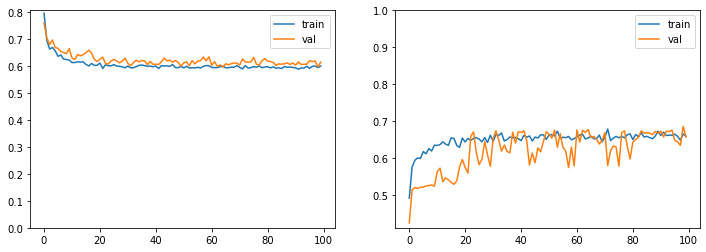

In [26]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 10. Eyes Closed  

123 of 123
77 of 77
(159, 224, 224, 3) float32
(159,) int32
(41, 224, 224, 3) float32
(41,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 97s 973ms/step - loss: 98.4246 - val_loss: 87.9713
Epoch 2/100
100/100 [==============================] - 95s 952ms/step - loss: 96.0896 - val_loss: 82.0230
Epoch 3/100
100/100 [==============================] - 95s 950ms/step - loss: 95.3428 - val_loss: 81.6116
Epoch 4/100
100/100 [==============================] - 95s 950ms/step - loss: 93.8139 - val_loss: 74.9484
Epoch 5/100
100/100 [==============================] - 95s 951ms/step - loss: 92.1557 - val_loss: 77.0831
Epoch 6/100
100/100 [==============================] - 95s 947ms/step - loss: 91.3056 - val_loss: 72.0438
Epoch 7/100
100/100 [==============================] - 96s 956ms/step - loss: 89.6899 - val_loss: 71.2905
Epoch 8/100
100/100 [==============================] - 96s 955ms/step - loss: 87.6459 - val_loss: 66.9766
Epoch 9/100
100/100 [==============================] - 97s 966ms/step - loss: 87.9986 - val_loss: 61.7992
Epoch 10/100
100/100 [========================

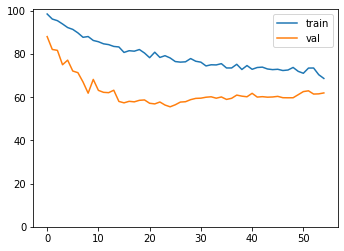

In [27]:
REQ_NAME = 'eyes_closed'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.8379 - accuracy: 0.5698 - precision: 0.7671 - recall: 0.6354 - f1: 0.6828 - specificity: 0.3469 - negative_predictive_value: 0.2063 - matthews_correlation_coefficient: -0.0207 - equal_error_rate: 0.5010 - val_loss: 0.6607 - val_accuracy: 0.6425 - val_precision: 0.7657 - val_recall: 0.7809 - val_f1: 0.7727 - val_specificity: 0.1894 - val_negative_predictive_value: 0.1973 - val_matthews_correlation_coefficient: -0.0332 - val_equal_error_rate: 0.4512

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.03317, saving model to ../../models/siamese_networks/eyes_closed_2020_06_26-10_12_43.h5
Epoch 2/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7657 - accuracy: 0.4989 - precision: 0.7785 - recall: 0.4913 - f1: 0.6005 - specificity: 0.5281 - negative_predictive_value: 0.2346 - matthews_correlation_coefficient: 0.0160 -

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6864 - accuracy: 0.5362 - precision: 0.8191 - recall: 0.5129 - f1: 0.6280 - specificity: 0.6173 - negative_predictive_value: 0.2727 - matthews_correlation_coefficient: 0.1090 - equal_error_rate: 0.4391 - val_loss: 0.6806 - val_accuracy: 0.4847 - val_precision: 0.8658 - val_recall: 0.4032 - val_f1: 0.5483 - val_specificity: 0.7919 - val_negative_predictive_value: 0.2837 - val_matthews_correlation_coefficient: 0.1705 - val_equal_error_rate: 0.4266

Epoch 00013: val_matthews_correlation_coefficient improved from 0.16655 to 0.17054, saving model to ../../models/siamese_networks/eyes_closed_2020_06_26-10_12_43.h5
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6845 - accuracy: 0.5288 - precision: 0.8222 - recall: 0.5001 - f1: 0.6184 - specificity: 0.6324 - negative_predictive_value: 0.2724 - matthews_correlation_coefficient: 0.1117 - equal_error_rate: 0.4222 - val_loss: 0.6739 - val_accuracy

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6761 - accuracy: 0.5024 - precision: 0.8339 - recall: 0.4443 - f1: 0.5765 - specificity: 0.7025 - negative_predictive_value: 0.2728 - matthews_correlation_coefficient: 0.1249 - equal_error_rate: 0.4304 - val_loss: 0.6609 - val_accuracy: 0.4839 - val_precision: 0.8527 - val_recall: 0.4097 - val_f1: 0.5517 - val_specificity: 0.7616 - val_negative_predictive_value: 0.2779 - val_matthews_correlation_coefficient: 0.1494 - val_equal_error_rate: 0.4349

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.17190
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6773 - accuracy: 0.5024 - precision: 0.8287 - recall: 0.4507 - f1: 0.5774 - specificity: 0.6762 - negative_predictive_value: 0.2676 - matthews_correlation_coefficient: 0.1102 - equal_error_rate: 0.4411 - val_loss: 0.6628 - val_accuracy: 0.4882 - val_precision: 0.8573 - val_recall: 0.4130 - val_f1: 0.5556 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6716 - accuracy: 0.5057 - precision: 0.8446 - recall: 0.4395 - f1: 0.5760 - specificity: 0.7310 - negative_predictive_value: 0.2780 - matthews_correlation_coefficient: 0.1441 - equal_error_rate: 0.4201 - val_loss: 0.6749 - val_accuracy: 0.4874 - val_precision: 0.8590 - val_recall: 0.4108 - val_f1: 0.5539 - val_specificity: 0.7725 - val_negative_predictive_value: 0.2811 - val_matthews_correlation_coefficient: 0.1601 - val_equal_error_rate: 0.4370

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.17190
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6700 - accuracy: 0.5061 - precision: 0.8456 - recall: 0.4413 - f1: 0.5779 - specificity: 0.7278 - negative_predictive_value: 0.2777 - matthews_correlation_coefficient: 0.1441 - equal_error_rate: 0.4251 - val_loss: 0.6833 - val_accuracy: 0.4865 - val_precision: 0.8614 - val_recall: 0.4087 - val_f1: 0.5525 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6750 - accuracy: 0.5124 - precision: 0.8323 - recall: 0.4660 - f1: 0.5890 - specificity: 0.6710 - negative_predictive_value: 0.2710 - matthews_correlation_coefficient: 0.1187 - equal_error_rate: 0.4327 - val_loss: 0.6718 - val_accuracy: 0.4882 - val_precision: 0.8594 - val_recall: 0.4119 - val_f1: 0.5549 - val_specificity: 0.7725 - val_negative_predictive_value: 0.2815 - val_matthews_correlation_coefficient: 0.1610 - val_equal_error_rate: 0.4296

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.17190
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6767 - accuracy: 0.5026 - precision: 0.8420 - recall: 0.4404 - f1: 0.5734 - specificity: 0.7258 - negative_predictive_value: 0.2762 - matthews_correlation_coefficient: 0.1395 - equal_error_rate: 0.4279 - val_loss: 0.6860 - val_accuracy: 0.4856 - val_precision: 0.8610 - val_recall: 0.4076 - val_f1: 0.5515 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6731 - accuracy: 0.5166 - precision: 0.8452 - recall: 0.4589 - f1: 0.5898 - specificity: 0.7149 - negative_predictive_value: 0.2797 - matthews_correlation_coefficient: 0.1468 - equal_error_rate: 0.4256 - val_loss: 0.6886 - val_accuracy: 0.4856 - val_precision: 0.8580 - val_recall: 0.4086 - val_f1: 0.5516 - val_specificity: 0.7725 - val_negative_predictive_value: 0.2805 - val_matthews_correlation_coefficient: 0.1582 - val_equal_error_rate: 0.4256

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.17190
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6720 - accuracy: 0.5000 - precision: 0.8580 - recall: 0.4221 - f1: 0.5603 - specificity: 0.7622 - negative_predictive_value: 0.2825 - matthews_correlation_coefficient: 0.1606 - equal_error_rate: 0.4129 - val_loss: 0.6812 - val_accuracy: 0.4874 - val_precision: 0.8570 - val_recall: 0.4119 - val_f1: 0.5546 - val_specifici

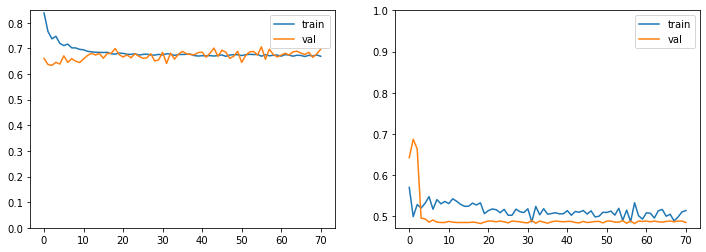

In [28]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 11. Varied Background

130 of 130
150 of 150
(224, 224, 224, 3) float32
(224,) int32
(56, 224, 224, 3) float32
(56,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 95s 951ms/step - loss: 96.5546 - val_loss: 106.2549
Epoch 2/100
100/100 [==============================] - 93s 932ms/step - loss: 89.4696 - val_loss: 106.9586
Epoch 3/100
100/100 [==============================] - 93s 934ms/step - loss: 83.7352 - val_loss: 101.4473
Epoch 4/100
100/100 [==============================] - 92s 918ms/step - loss: 79.9626 - val_loss: 95.4559
Epoch 5/100
100/100 [==============================] - 92s 925ms/step - loss: 75.3417 - val_loss: 93.2698
Epoch 6/100
100/100 [==============================] - 93s 931ms/step - loss: 74.0827 - val_loss: 90.0787
Epoch 7/100
100/100 [==============================] - 92s 917ms/step - loss: 71.0396 - val_loss: 88.9050
Epoch 8/100
100/100 [==============================] - 93s 927ms/step - loss: 69.2725 - val_loss: 90.2812
Epoch 9/100
100/100 [==============================] - 94s 940ms/step - loss: 66.9308 - val_loss: 90.6126
Epoch 10/100
100/100 [=====================

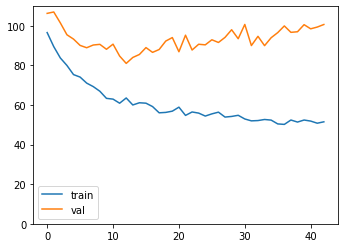

In [29]:
REQ_NAME = 'varied_background'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 14s 3ms/step - loss: 0.7061 - accuracy: 0.5770 - precision: 0.6406 - recall: 0.5735 - f1: 0.6022 - specificity: 0.5839 - negative_predictive_value: 0.5142 - matthews_correlation_coefficient: 0.1561 - equal_error_rate: 0.4279 - val_loss: 0.6904 - val_accuracy: 0.6016 - val_precision: 0.8772 - val_recall: 0.3373 - val_f1: 0.4861 - val_specificity: 0.9409 - val_negative_predictive_value: 0.5273 - val_matthews_correlation_coefficient: 0.3344 - val_equal_error_rate: 0.3884

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33444, saving model to ../../models/siamese_networks/varied_background_2020_06_26-11_35_12.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6739 - accuracy: 0.5870 - precision: 0.6583 - recall: 0.5596 - f1: 0.6017 - specificity: 0.6240 - negative_predictive_value: 0.5229 - matthews_correlation_coefficient: 0.182

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6281 - accuracy: 0.6132 - precision: 0.7035 - recall: 0.5460 - f1: 0.6109 - specificity: 0.7019 - negative_predictive_value: 0.5454 - matthews_correlation_coefficient: 0.2483 - equal_error_rate: 0.3833 - val_loss: 0.6592 - val_accuracy: 0.5990 - val_precision: 0.8608 - val_recall: 0.3414 - val_f1: 0.4869 - val_specificity: 0.9296 - val_negative_predictive_value: 0.5261 - val_matthews_correlation_coefficient: 0.3228 - val_equal_error_rate: 0.3844

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.35235
Epoch 15/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6284 - accuracy: 0.6095 - precision: 0.7012 - recall: 0.5358 - f1: 0.6035 - specificity: 0.7069 - negative_predictive_value: 0.5420 - matthews_correlation_coefficient: 0.2428 - equal_error_rate: 0.3770 - val_loss: 0.6492 - val_accuracy: 0.5998 - val_precision: 0.8494 - val_recall: 0.3502 - val_f1: 0.4941 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6177 - accuracy: 0.6239 - precision: 0.7188 - recall: 0.5453 - f1: 0.6174 - specificity: 0.7257 - negative_predictive_value: 0.5527 - matthews_correlation_coefficient: 0.2711 - equal_error_rate: 0.3706 - val_loss: 0.6320 - val_accuracy: 0.6103 - val_precision: 0.8404 - val_recall: 0.3755 - val_f1: 0.5167 - val_specificity: 0.9091 - val_negative_predictive_value: 0.5339 - val_matthews_correlation_coefficient: 0.3250 - val_equal_error_rate: 0.3658

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.35235
Epoch 28/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6157 - accuracy: 0.6305 - precision: 0.7263 - recall: 0.5565 - f1: 0.6271 - specificity: 0.7278 - negative_predictive_value: 0.5585 - matthews_correlation_coefficient: 0.2844 - equal_error_rate: 0.3574 - val_loss: 0.6490 - val_accuracy: 0.6051 - val_precision: 0.8545 - val_recall: 0.3556 - val_f1: 0.5003 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6178 - accuracy: 0.6222 - precision: 0.7182 - recall: 0.5475 - f1: 0.6184 - specificity: 0.7188 - negative_predictive_value: 0.5505 - matthews_correlation_coefficient: 0.2674 - equal_error_rate: 0.3671 - val_loss: 0.6356 - val_accuracy: 0.6094 - val_precision: 0.8510 - val_recall: 0.3670 - val_f1: 0.5104 - val_specificity: 0.9186 - val_negative_predictive_value: 0.5332 - val_matthews_correlation_coefficient: 0.3300 - val_equal_error_rate: 0.3638

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.35235
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6111 - accuracy: 0.6259 - precision: 0.7280 - recall: 0.5409 - f1: 0.6174 - specificity: 0.7381 - negative_predictive_value: 0.5539 - matthews_correlation_coefficient: 0.2804 - equal_error_rate: 0.3718 - val_loss: 0.6297 - val_accuracy: 0.6103 - val_precision: 0.8344 - val_recall: 0.3757 - val_f1: 0.5160 - val_specifici

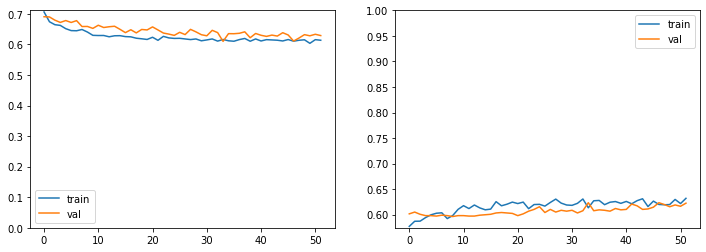

In [30]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 12. Roll/pitch/yaw

150 of 150
141 of 141
(232, 224, 224, 3) float32
(232,) int32
(59, 224, 224, 3) float32
(59,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 100s 997ms/step - loss: 100.0638 - val_loss: 99.9140
Epoch 2/100
100/100 [==============================] - 97s 968ms/step - loss: 99.3804 - val_loss: 100.5011
Epoch 3/100
100/100 [==============================] - 98s 976ms/step - loss: 98.9953 - val_loss: 100.5951
Epoch 4/100
100/100 [==============================] - 97s 970ms/step - loss: 98.9711 - val_loss: 100.6091
Epoch 5/100
100/100 [==============================] - 97s 975ms/step - loss: 99.6402 - val_loss: 100.2924
Epoch 6/100
100/100 [==============================] - 98s 983ms/step - loss: 99.9328 - val_loss: 100.1367
Epoch 7/100
100/100 [==============================] - 96s 960ms/step - loss: 98.6263 - val_loss: 99.7140
Epoch 8/100
100/100 [==============================] - 99s 994ms/step - loss: 99.1565 - val_loss: 99.1777
Epoch 9/100
100/100 [==============================] - 99s 989ms/step - loss: 98.3329 - val_loss: 99.5209
Epoch 10/100
100/100 [=================

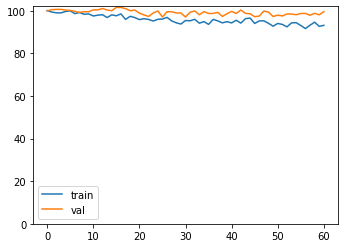

In [31]:
REQ_NAME = 'roll_pitch_yaw'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.7619 - accuracy: 0.5342 - precision: 0.7528 - recall: 0.5684 - f1: 0.6456 - specificity: 0.4336 - negative_predictive_value: 0.2463 - matthews_correlation_coefficient: 3.0546e-04 - equal_error_rate: 0.4950 - val_loss: 0.6732 - val_accuracy: 0.5833 - val_precision: 0.8027 - val_recall: 0.5947 - val_f1: 0.6817 - val_specificity: 0.5466 - val_negative_predictive_value: 0.3043 - val_matthews_correlation_coefficient: 0.1229 - val_equal_error_rate: 0.4275

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.12291, saving model to ../../models/siamese_networks/roll_pitch_yaw_2020_06_26-13_26_12.h5
Epoch 2/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7216 - accuracy: 0.5469 - precision: 0.7732 - recall: 0.5598 - f1: 0.6471 - specificity: 0.5029 - negative_predictive_value: 0.2733 - matthews_correlation_coefficient: 0.05

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6581 - accuracy: 0.6361 - precision: 0.8248 - recall: 0.6585 - f1: 0.7304 - specificity: 0.5754 - negative_predictive_value: 0.3556 - matthews_correlation_coefficient: 0.2048 - equal_error_rate: 0.3812 - val_loss: 0.6575 - val_accuracy: 0.7193 - val_precision: 0.8822 - val_recall: 0.7284 - val_f1: 0.7972 - val_specificity: 0.7001 - val_negative_predictive_value: 0.4572 - val_matthews_correlation_coefficient: 0.3811 - val_equal_error_rate: 0.2811

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.39565
Epoch 14/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6583 - accuracy: 0.6313 - precision: 0.8269 - recall: 0.6471 - f1: 0.7238 - specificity: 0.5830 - negative_predictive_value: 0.3532 - matthews_correlation_coefficient: 0.2032 - equal_error_rate: 0.3821 - val_loss: 0.6424 - val_accuracy: 0.7376 - val_precision: 0.8365 - val_recall: 0.8138 - val_f1: 0.8244 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6429 - accuracy: 0.6521 - precision: 0.8379 - recall: 0.6680 - f1: 0.7418 - specificity: 0.6035 - negative_predictive_value: 0.3755 - matthews_correlation_coefficient: 0.2403 - equal_error_rate: 0.3602 - val_loss: 0.6422 - val_accuracy: 0.7384 - val_precision: 0.8433 - val_recall: 0.8059 - val_f1: 0.8233 - val_specificity: 0.5376 - val_negative_predictive_value: 0.4736 - val_matthews_correlation_coefficient: 0.3294 - val_equal_error_rate: 0.2871

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.39565
Epoch 27/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6448 - accuracy: 0.6523 - precision: 0.8305 - recall: 0.6772 - f1: 0.7446 - specificity: 0.5768 - negative_predictive_value: 0.3694 - matthews_correlation_coefficient: 0.2250 - equal_error_rate: 0.3718 - val_loss: 0.6376 - val_accuracy: 0.7384 - val_precision: 0.8368 - val_recall: 0.8149 - val_f1: 0.8249 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6427 - accuracy: 0.6435 - precision: 0.8357 - recall: 0.6566 - f1: 0.7335 - specificity: 0.6043 - negative_predictive_value: 0.3670 - matthews_correlation_coefficient: 0.2296 - equal_error_rate: 0.3603 - val_loss: 0.6315 - val_accuracy: 0.7376 - val_precision: 0.8285 - val_recall: 0.8263 - val_f1: 0.8266 - val_specificity: 0.4703 - val_negative_predictive_value: 0.4677 - val_matthews_correlation_coefficient: 0.2958 - val_equal_error_rate: 0.2873

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.39565
Epoch 40/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6358 - accuracy: 0.6710 - precision: 0.8393 - recall: 0.6977 - f1: 0.7600 - specificity: 0.5939 - negative_predictive_value: 0.3960 - matthews_correlation_coefficient: 0.2614 - equal_error_rate: 0.3469 - val_loss: 0.6447 - val_accuracy: 0.7332 - val_precision: 0.8532 - val_recall: 0.7838 - val_f1: 0.8164 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6469 - accuracy: 0.6407 - precision: 0.8329 - recall: 0.6542 - f1: 0.7314 - specificity: 0.6051 - negative_predictive_value: 0.3637 - matthews_correlation_coefficient: 0.2250 - equal_error_rate: 0.3658 - val_loss: 0.6520 - val_accuracy: 0.7184 - val_precision: 0.8685 - val_recall: 0.7427 - val_f1: 0.8000 - val_specificity: 0.6526 - val_negative_predictive_value: 0.4521 - val_matthews_correlation_coefficient: 0.3558 - val_equal_error_rate: 0.2900

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.39565
Epoch 53/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6454 - accuracy: 0.6470 - precision: 0.8332 - recall: 0.6653 - f1: 0.7374 - specificity: 0.5989 - negative_predictive_value: 0.3683 - matthews_correlation_coefficient: 0.2302 - equal_error_rate: 0.3667 - val_loss: 0.6690 - val_accuracy: 0.6896 - val_precision: 0.9071 - val_recall: 0.6631 - val_f1: 0.7650 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6353 - accuracy: 0.6697 - precision: 0.8414 - recall: 0.6914 - f1: 0.7572 - specificity: 0.6073 - negative_predictive_value: 0.3930 - matthews_correlation_coefficient: 0.2640 - equal_error_rate: 0.3489 - val_loss: 0.6671 - val_accuracy: 0.6861 - val_precision: 0.9044 - val_recall: 0.6608 - val_f1: 0.7624 - val_specificity: 0.7872 - val_negative_predictive_value: 0.4320 - val_matthews_correlation_coefficient: 0.3880 - val_equal_error_rate: 0.2892

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.39809
Epoch 66/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6398 - accuracy: 0.6536 - precision: 0.8421 - recall: 0.6660 - f1: 0.7419 - specificity: 0.6202 - negative_predictive_value: 0.3795 - matthews_correlation_coefficient: 0.2513 - equal_error_rate: 0.3544 - val_loss: 0.6572 - val_accuracy: 0.7167 - val_precision: 0.8877 - val_recall: 0.7207 - val_f1: 0.7947 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6435 - accuracy: 0.6431 - precision: 0.8378 - recall: 0.6522 - f1: 0.7324 - specificity: 0.6166 - negative_predictive_value: 0.3675 - matthews_correlation_coefficient: 0.2346 - equal_error_rate: 0.3592 - val_loss: 0.6606 - val_accuracy: 0.7001 - val_precision: 0.8828 - val_recall: 0.6997 - val_f1: 0.7796 - val_specificity: 0.7117 - val_negative_predictive_value: 0.4373 - val_matthews_correlation_coefficient: 0.3627 - val_equal_error_rate: 0.2921

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.39809
Epoch 79/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6425 - accuracy: 0.6333 - precision: 0.8374 - recall: 0.6376 - f1: 0.7222 - specificity: 0.6281 - negative_predictive_value: 0.3628 - matthews_correlation_coefficient: 0.2302 - equal_error_rate: 0.3577 - val_loss: 0.6351 - val_accuracy: 0.7332 - val_precision: 0.8309 - val_recall: 0.8137 - val_f1: 0.8215 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6443 - accuracy: 0.6451 - precision: 0.8449 - recall: 0.6494 - f1: 0.7321 - specificity: 0.6404 - negative_predictive_value: 0.3751 - matthews_correlation_coefficient: 0.2519 - equal_error_rate: 0.3568 - val_loss: 0.6321 - val_accuracy: 0.7350 - val_precision: 0.8278 - val_recall: 0.8215 - val_f1: 0.8239 - val_specificity: 0.4708 - val_negative_predictive_value: 0.4603 - val_matthews_correlation_coefficient: 0.2897 - val_equal_error_rate: 0.2995

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.39809
Epoch 92/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6343 - accuracy: 0.6560 - precision: 0.8428 - recall: 0.6688 - f1: 0.7447 - specificity: 0.6156 - negative_predictive_value: 0.3795 - matthews_correlation_coefficient: 0.2511 - equal_error_rate: 0.3552 - val_loss: 0.6347 - val_accuracy: 0.7323 - val_precision: 0.8307 - val_recall: 0.8126 - val_f1: 0.8208 - val_specifici

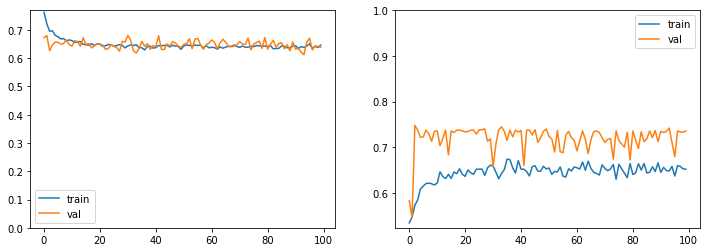

In [32]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 13. Flash Reflection on Skin

84 of 84
70 of 70
(123, 224, 224, 3) float32
(123,) int32
(31, 224, 224, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 78s 778ms/step - loss: 98.4625 - val_loss: 86.2111
Epoch 2/100
100/100 [==============================] - 76s 758ms/step - loss: 93.7807 - val_loss: 78.7455
Epoch 3/100
100/100 [==============================] - 76s 758ms/step - loss: 89.0242 - val_loss: 80.9030
Epoch 4/100
100/100 [==============================] - 76s 757ms/step - loss: 85.9510 - val_loss: 79.8946
Epoch 5/100
100/100 [==============================] - 76s 759ms/step - loss: 84.4103 - val_loss: 79.9675
Epoch 6/100
100/100 [==============================] - 76s 758ms/step - loss: 83.4394 - val_loss: 79.4332
Epoch 7/100
100/100 [==============================] - 76s 757ms/step - loss: 81.4697 - val_loss: 82.0052
Epoch 8/100
100/100 [==============================] - 76s 757ms/step - loss: 77.7825 - val_loss: 82.0232
Epoch 9/100
100/100 [==============================] - 76s 762ms/step - loss: 77.9783 - val_loss: 80.0694
Epoch 10/100
100/100 [========================

100/100 [==============================] - 76s 757ms/step - loss: 61.3771 - val_loss: 73.2443
Epoch 78/100
100/100 [==============================] - 76s 758ms/step - loss: 62.9380 - val_loss: 76.0883
Epoch 79/100
100/100 [==============================] - 76s 759ms/step - loss: 58.3327 - val_loss: 76.7222
Epoch 80/100
100/100 [==============================] - 76s 757ms/step - loss: 61.5938 - val_loss: 71.2822
Epoch 81/100
100/100 [==============================] - 76s 760ms/step - loss: 62.1791 - val_loss: 69.4016
Epoch 82/100
100/100 [==============================] - 76s 756ms/step - loss: 63.3669 - val_loss: 69.9169
Epoch 83/100
100/100 [==============================] - 76s 759ms/step - loss: 60.8231 - val_loss: 76.5615
Epoch 84/100
100/100 [==============================] - 76s 757ms/step - loss: 62.1707 - val_loss: 73.9622
Epoch 85/100
100/100 [==============================] - 76s 756ms/step - loss: 62.3810 - val_loss: 69.1606
Epoch 86/100
100/100 [============================

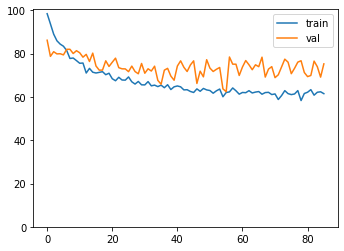

In [33]:
REQ_NAME = 'flash_reflection_on_skin'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.7288 - accuracy: 0.5491 - precision: 0.5955 - recall: 0.5454 - f1: 0.5663 - specificity: 0.5556 - negative_predictive_value: 0.5045 - matthews_correlation_coefficient: 0.1005 - equal_error_rate: 0.4478 - val_loss: 0.6969 - val_accuracy: 0.5789 - val_precision: 0.8647 - val_recall: 0.2725 - val_f1: 0.4100 - val_specificity: 0.9500 - val_negative_predictive_value: 0.5210 - val_matthews_correlation_coefficient: 0.2920 - val_equal_error_rate: 0.3490

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29205, saving model to ../../models/siamese_networks/flash_reflection_on_skin_2020_06_26-15_37_59.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7047 - accuracy: 0.5744 - precision: 0.6261 - recall: 0.5551 - f1: 0.5857 - specificity: 0.5967 - negative_predictive_value: 0.5257 - matthews_correlation_coefficient

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6580 - accuracy: 0.6056 - precision: 0.6684 - recall: 0.5576 - f1: 0.6043 - specificity: 0.6635 - negative_predictive_value: 0.5549 - matthews_correlation_coefficient: 0.2222 - equal_error_rate: 0.3930 - val_loss: 0.6982 - val_accuracy: 0.5702 - val_precision: 0.8617 - val_recall: 0.2573 - val_f1: 0.3916 - val_specificity: 0.9500 - val_negative_predictive_value: 0.5158 - val_matthews_correlation_coefficient: 0.2786 - val_equal_error_rate: 0.3403

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.29205
Epoch 15/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6584 - accuracy: 0.5973 - precision: 0.6613 - recall: 0.5333 - f1: 0.5866 - specificity: 0.6709 - negative_predictive_value: 0.5452 - matthews_correlation_coefficient: 0.2052 - equal_error_rate: 0.4003 - val_loss: 0.6915 - val_accuracy: 0.5702 - val_precision: 0.8587 - val_recall: 0.2586 - val_f1: 0.3931 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6534 - accuracy: 0.6034 - precision: 0.6732 - recall: 0.5350 - f1: 0.5921 - specificity: 0.6845 - negative_predictive_value: 0.5494 - matthews_correlation_coefficient: 0.2210 - equal_error_rate: 0.3920 - val_loss: 0.6721 - val_accuracy: 0.5833 - val_precision: 0.8536 - val_recall: 0.2958 - val_f1: 0.4320 - val_specificity: 0.9388 - val_negative_predictive_value: 0.5267 - val_matthews_correlation_coefficient: 0.2973 - val_equal_error_rate: 0.3428

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.30241
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6520 - accuracy: 0.5975 - precision: 0.6726 - recall: 0.5107 - f1: 0.5773 - specificity: 0.7010 - negative_predictive_value: 0.5438 - matthews_correlation_coefficient: 0.2140 - equal_error_rate: 0.3955 - val_loss: 0.6717 - val_accuracy: 0.5806 - val_precision: 0.8511 - val_recall: 0.2894 - val_f1: 0.4247 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6432 - accuracy: 0.6130 - precision: 0.6904 - recall: 0.5284 - f1: 0.5959 - specificity: 0.7143 - negative_predictive_value: 0.5571 - matthews_correlation_coefficient: 0.2450 - equal_error_rate: 0.3773 - val_loss: 0.6750 - val_accuracy: 0.5841 - val_precision: 0.8615 - val_recall: 0.2957 - val_f1: 0.4328 - val_specificity: 0.9407 - val_negative_predictive_value: 0.5270 - val_matthews_correlation_coefficient: 0.3015 - val_equal_error_rate: 0.3320

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.30604
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6490 - accuracy: 0.6032 - precision: 0.6793 - recall: 0.5247 - f1: 0.5861 - specificity: 0.6978 - negative_predictive_value: 0.5506 - matthews_correlation_coefficient: 0.2260 - equal_error_rate: 0.3830 - val_loss: 0.6831 - val_accuracy: 0.5763 - val_precision: 0.8605 - val_recall: 0.2770 - val_f1: 0.4127 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6439 - accuracy: 0.6187 - precision: 0.7039 - recall: 0.5263 - f1: 0.5987 - specificity: 0.7291 - negative_predictive_value: 0.5598 - matthews_correlation_coefficient: 0.2594 - equal_error_rate: 0.3771 - val_loss: 0.6778 - val_accuracy: 0.5876 - val_precision: 0.8668 - val_recall: 0.3004 - val_f1: 0.4385 - val_specificity: 0.9426 - val_negative_predictive_value: 0.5292 - val_matthews_correlation_coefficient: 0.3087 - val_equal_error_rate: 0.3352

Epoch 00053: val_matthews_correlation_coefficient improved from 0.30833 to 0.30868, saving model to ../../models/siamese_networks/flash_reflection_on_skin_2020_06_26-15_37_59.h5
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6462 - accuracy: 0.6163 - precision: 0.6934 - recall: 0.5381 - f1: 0.6016 - specificity: 0.7094 - negative_predictive_value: 0.5606 - matthews_correlation_coefficient: 0.2506 - equal_error_rate: 0.3777 - val_loss: 0.6740 -

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6456 - accuracy: 0.6091 - precision: 0.6787 - recall: 0.5403 - f1: 0.5984 - specificity: 0.6889 - negative_predictive_value: 0.5540 - matthews_correlation_coefficient: 0.2309 - equal_error_rate: 0.3788 - val_loss: 0.6808 - val_accuracy: 0.5850 - val_precision: 0.8604 - val_recall: 0.2973 - val_f1: 0.4337 - val_specificity: 0.9407 - val_negative_predictive_value: 0.5278 - val_matthews_correlation_coefficient: 0.3023 - val_equal_error_rate: 0.3316

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.30868
Epoch 67/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6450 - accuracy: 0.6123 - precision: 0.6900 - recall: 0.5258 - f1: 0.5914 - specificity: 0.7148 - negative_predictive_value: 0.5584 - matthews_correlation_coefficient: 0.2443 - equal_error_rate: 0.3752 - val_loss: 0.6761 - val_accuracy: 0.5885 - val_precision: 0.8609 - val_recall: 0.3055 - val_f1: 0.4429 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6489 - accuracy: 0.6080 - precision: 0.6863 - recall: 0.5325 - f1: 0.5939 - specificity: 0.6982 - negative_predictive_value: 0.5526 - matthews_correlation_coefficient: 0.2345 - equal_error_rate: 0.3753 - val_loss: 0.6823 - val_accuracy: 0.5815 - val_precision: 0.8614 - val_recall: 0.2900 - val_f1: 0.4255 - val_specificity: 0.9423 - val_negative_predictive_value: 0.5257 - val_matthews_correlation_coefficient: 0.2981 - val_equal_error_rate: 0.3352

Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.30868
Epoch 80/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6520 - accuracy: 0.6097 - precision: 0.6907 - recall: 0.5372 - f1: 0.5981 - specificity: 0.6984 - negative_predictive_value: 0.5545 - matthews_correlation_coefficient: 0.2400 - equal_error_rate: 0.3810 - val_loss: 0.6712 - val_accuracy: 0.5876 - val_precision: 0.8575 - val_recall: 0.3035 - val_f1: 0.4409 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6482 - accuracy: 0.6054 - precision: 0.6924 - recall: 0.5160 - f1: 0.5852 - specificity: 0.7141 - negative_predictive_value: 0.5497 - matthews_correlation_coefficient: 0.2358 - equal_error_rate: 0.3860 - val_loss: 0.6713 - val_accuracy: 0.5876 - val_precision: 0.8575 - val_recall: 0.3035 - val_f1: 0.4409 - val_specificity: 0.9388 - val_negative_predictive_value: 0.5295 - val_matthews_correlation_coefficient: 0.3048 - val_equal_error_rate: 0.3313

Epoch 00092: val_matthews_correlation_coefficient did not improve from 0.30868
Epoch 93/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6498 - accuracy: 0.6051 - precision: 0.6781 - recall: 0.5302 - f1: 0.5903 - specificity: 0.6920 - negative_predictive_value: 0.5508 - matthews_correlation_coefficient: 0.2254 - equal_error_rate: 0.3848 - val_loss: 0.6670 - val_accuracy: 0.5885 - val_precision: 0.8234 - val_recall: 0.3237 - val_f1: 0.4570 - val_specifici

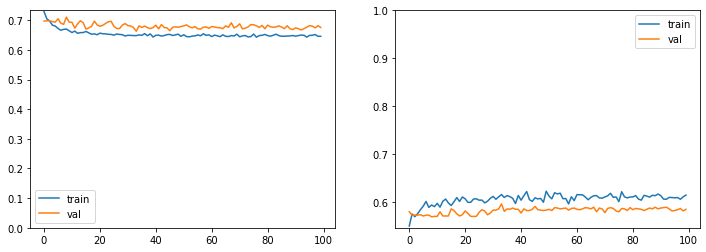

In [34]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 14. Red Eyes 

78 of 78
39 of 39
(93, 224, 224, 3) float32
(93,) int32
(24, 224, 224, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 77s 766ms/step - loss: 99.1054 - val_loss: 96.4200
Epoch 2/100
100/100 [==============================] - 74s 736ms/step - loss: 98.3045 - val_loss: 95.7420
Epoch 3/100
100/100 [==============================] - 74s 743ms/step - loss: 98.1328 - val_loss: 95.7022
Epoch 4/100
100/100 [==============================] - 77s 773ms/step - loss: 97.3717 - val_loss: 94.5156
Epoch 5/100
100/100 [==============================] - 74s 737ms/step - loss: 96.5052 - val_loss: 93.9117
Epoch 6/100
100/100 [==============================] - 74s 743ms/step - loss: 95.3353 - val_loss: 91.7982
Epoch 7/100
100/100 [==============================] - 74s 740ms/step - loss: 94.7496 - val_loss: 91.2267
Epoch 8/100
100/100 [==============================] - 74s 740ms/step - loss: 94.3284 - val_loss: 90.3319
Epoch 9/100
100/100 [==============================] - 74s 738ms/step - loss: 92.9703 - val_loss: 90.1388
Epoch 10/100
100/100 [========================

100/100 [==============================] - 75s 745ms/step - loss: 71.9535 - val_loss: 65.9062
Epoch 78/100
100/100 [==============================] - 74s 744ms/step - loss: 71.3570 - val_loss: 65.3348
Epoch 79/100
100/100 [==============================] - 74s 744ms/step - loss: 71.4833 - val_loss: 66.0977
Epoch 80/100
100/100 [==============================] - 74s 742ms/step - loss: 73.6129 - val_loss: 63.9008
Epoch 81/100
100/100 [==============================] - 74s 738ms/step - loss: 73.4380 - val_loss: 64.9873
Epoch 82/100
100/100 [==============================] - 74s 744ms/step - loss: 73.1921 - val_loss: 66.6976
Epoch 83/100
100/100 [==============================] - 74s 742ms/step - loss: 72.7272 - val_loss: 64.5503
Epoch 84/100
100/100 [==============================] - 74s 743ms/step - loss: 72.6821 - val_loss: 67.6048
Epoch 85/100
100/100 [==============================] - 74s 740ms/step - loss: 71.5552 - val_loss: 65.6570
Epoch 86/100
100/100 [============================

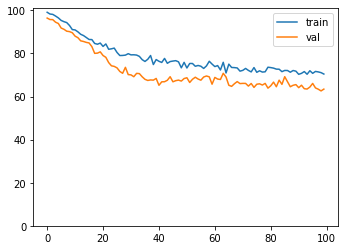

In [35]:
REQ_NAME = 'red_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.7538 - accuracy: 0.5620 - precision: 0.8125 - recall: 0.5768 - f1: 0.6686 - specificity: 0.4912 - negative_predictive_value: 0.2332 - matthews_correlation_coefficient: 0.0557 - equal_error_rate: 0.4444 - val_loss: 0.5911 - val_accuracy: 0.6853 - val_precision: 0.8126 - val_recall: 0.7843 - val_f1: 0.7975 - val_specificity: 0.3205 - val_negative_predictive_value: 0.2832 - val_matthews_correlation_coefficient: 0.1000 - val_equal_error_rate: 0.3986

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.10002, saving model to ../../models/siamese_networks/red_eyes_2020_06_26-18_03_55.h5
Epoch 2/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7350 - accuracy: 0.5456 - precision: 0.8239 - recall: 0.5382 - f1: 0.6461 - specificity: 0.5716 - negative_predictive_value: 0.2506 - matthews_correlation_coefficient: 0.0900 - equal


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.21670
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6658 - accuracy: 0.5369 - precision: 0.8571 - recall: 0.4964 - f1: 0.6255 - specificity: 0.6889 - negative_predictive_value: 0.2719 - matthews_correlation_coefficient: 0.1542 - equal_error_rate: 0.4210 - val_loss: 0.6456 - val_accuracy: 0.5004 - val_precision: 0.9076 - val_recall: 0.4054 - val_f1: 0.5594 - val_specificity: 0.8480 - val_negative_predictive_value: 0.2767 - val_matthews_correlation_coefficient: 0.2158 - val_equal_error_rate: 0.3857

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.21670
Epoch 15/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6725 - accuracy: 0.5336 - precision: 0.8417 - recall: 0.5044 - f1: 0.6287 - specificity: 0.6434 - negative_predictive_value: 0.2590 - matthews_correlation_coefficient: 0.1218 - equal_error_rate: 0.4234 - val_loss: 0.6432 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6625 - accuracy: 0.5214 - precision: 0.8599 - recall: 0.4696 - f1: 0.6040 - specificity: 0.7127 - negative_predictive_value: 0.2655 - matthews_correlation_coefficient: 0.1507 - equal_error_rate: 0.4256 - val_loss: 0.6643 - val_accuracy: 0.4952 - val_precision: 0.9087 - val_recall: 0.3982 - val_f1: 0.5525 - val_specificity: 0.8516 - val_negative_predictive_value: 0.2752 - val_matthews_correlation_coefficient: 0.2140 - val_equal_error_rate: 0.3860

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.21843
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6599 - accuracy: 0.5342 - precision: 0.8663 - recall: 0.4853 - f1: 0.6194 - specificity: 0.7184 - negative_predictive_value: 0.2724 - matthews_correlation_coefficient: 0.1677 - equal_error_rate: 0.4071 - val_loss: 0.6654 - val_accuracy: 0.4952 - val_precision: 0.9087 - val_recall: 0.3982 - val_f1: 0.5525 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6587 - accuracy: 0.5164 - precision: 0.8692 - recall: 0.4575 - f1: 0.5968 - specificity: 0.7380 - negative_predictive_value: 0.2679 - matthews_correlation_coefficient: 0.1634 - equal_error_rate: 0.4047 - val_loss: 0.6598 - val_accuracy: 0.4935 - val_precision: 0.9084 - val_recall: 0.3961 - val_f1: 0.5504 - val_specificity: 0.8516 - val_negative_predictive_value: 0.2745 - val_matthews_correlation_coefficient: 0.2126 - val_equal_error_rate: 0.3907

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.21929
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6534 - accuracy: 0.5155 - precision: 0.8766 - recall: 0.4496 - f1: 0.5928 - specificity: 0.7613 - negative_predictive_value: 0.2715 - matthews_correlation_coefficient: 0.1761 - equal_error_rate: 0.4005 - val_loss: 0.6383 - val_accuracy: 0.4969 - val_precision: 0.9018 - val_recall: 0.4023 - val_f1: 0.5553 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6536 - accuracy: 0.5209 - precision: 0.8717 - recall: 0.4626 - f1: 0.6006 - specificity: 0.7441 - negative_predictive_value: 0.2726 - matthews_correlation_coefficient: 0.1721 - equal_error_rate: 0.4127 - val_loss: 0.6422 - val_accuracy: 0.4987 - val_precision: 0.9022 - val_recall: 0.4044 - val_f1: 0.5574 - val_specificity: 0.8397 - val_negative_predictive_value: 0.2745 - val_matthews_correlation_coefficient: 0.2074 - val_equal_error_rate: 0.3892

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.21929
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6550 - accuracy: 0.5185 - precision: 0.8737 - recall: 0.4534 - f1: 0.5955 - specificity: 0.7572 - negative_predictive_value: 0.2706 - matthews_correlation_coefficient: 0.1739 - equal_error_rate: 0.4021 - val_loss: 0.6458 - val_accuracy: 0.4969 - val_precision: 0.9018 - val_recall: 0.4023 - val_f1: 0.5553 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6510 - accuracy: 0.5253 - precision: 0.8878 - recall: 0.4566 - f1: 0.6002 - specificity: 0.7846 - negative_predictive_value: 0.2802 - matthews_correlation_coefficient: 0.2008 - equal_error_rate: 0.3964 - val_loss: 0.6577 - val_accuracy: 0.4952 - val_precision: 0.9088 - val_recall: 0.3982 - val_f1: 0.5525 - val_specificity: 0.8516 - val_negative_predictive_value: 0.2753 - val_matthews_correlation_coefficient: 0.2141 - val_equal_error_rate: 0.3806

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.21929
Epoch 67/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6556 - accuracy: 0.5105 - precision: 0.8732 - recall: 0.4446 - f1: 0.5875 - specificity: 0.7556 - negative_predictive_value: 0.2684 - matthews_correlation_coefficient: 0.1681 - equal_error_rate: 0.4206 - val_loss: 0.6451 - val_accuracy: 0.4978 - val_precision: 0.9091 - val_recall: 0.4013 - val_f1: 0.5556 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6553 - accuracy: 0.5253 - precision: 0.8801 - recall: 0.4617 - f1: 0.6023 - specificity: 0.7624 - negative_predictive_value: 0.2755 - matthews_correlation_coefficient: 0.1862 - equal_error_rate: 0.4079 - val_loss: 0.6597 - val_accuracy: 0.4943 - val_precision: 0.9105 - val_recall: 0.3960 - val_f1: 0.5507 - val_specificity: 0.8556 - val_negative_predictive_value: 0.2755 - val_matthews_correlation_coefficient: 0.2160 - val_equal_error_rate: 0.3833

Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.22489
Epoch 80/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6531 - accuracy: 0.5260 - precision: 0.8713 - recall: 0.4656 - f1: 0.6041 - specificity: 0.7461 - negative_predictive_value: 0.2727 - matthews_correlation_coefficient: 0.1741 - equal_error_rate: 0.4012 - val_loss: 0.6388 - val_accuracy: 0.4978 - val_precision: 0.9004 - val_recall: 0.4044 - val_f1: 0.5570 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6543 - accuracy: 0.5135 - precision: 0.8713 - recall: 0.4493 - f1: 0.5907 - specificity: 0.7547 - negative_predictive_value: 0.2688 - matthews_correlation_coefficient: 0.1685 - equal_error_rate: 0.3995 - val_loss: 0.6414 - val_accuracy: 0.4969 - val_precision: 0.9018 - val_recall: 0.4023 - val_f1: 0.5553 - val_specificity: 0.8397 - val_negative_predictive_value: 0.2738 - val_matthews_correlation_coefficient: 0.2058 - val_equal_error_rate: 0.3833

Epoch 00092: val_matthews_correlation_coefficient did not improve from 0.22489
Epoch 93/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6572 - accuracy: 0.5181 - precision: 0.8813 - recall: 0.4495 - f1: 0.5933 - specificity: 0.7745 - negative_predictive_value: 0.2743 - matthews_correlation_coefficient: 0.1862 - equal_error_rate: 0.4021 - val_loss: 0.6521 - val_accuracy: 0.4935 - val_precision: 0.9080 - val_recall: 0.3960 - val_f1: 0.5503 - val_specifici

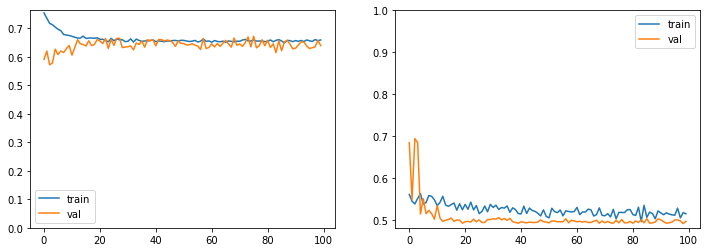

In [36]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 15. Shadows Behind Head 

99 of 99
94 of 94
(154, 224, 224, 3) float32
(154,) int32
(39, 224, 224, 3) float32
(39,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 90s 896ms/step - loss: 98.2229 - val_loss: 101.6021
Epoch 2/100
100/100 [==============================] - 82s 820ms/step - loss: 91.9751 - val_loss: 105.4394
Epoch 3/100
100/100 [==============================] - 82s 818ms/step - loss: 82.0690 - val_loss: 106.4809
Epoch 4/100
100/100 [==============================] - 82s 823ms/step - loss: 77.2174 - val_loss: 104.9208
Epoch 5/100
100/100 [==============================] - 82s 821ms/step - loss: 71.7525 - val_loss: 106.2314
Epoch 6/100
100/100 [==============================] - 82s 820ms/step - loss: 69.4684 - val_loss: 101.2491
Epoch 7/100
100/100 [==============================] - 82s 819ms/step - loss: 67.1845 - val_loss: 101.7471
Epoch 8/100
100/100 [==============================] - 82s 820ms/step - loss: 64.0737 - val_loss: 103.7418
Epoch 9/100
100/100 [==============================] - 82s 819ms/step - loss: 63.1584 - val_loss: 102.2526
Epoch 10/100
100/100 [===============

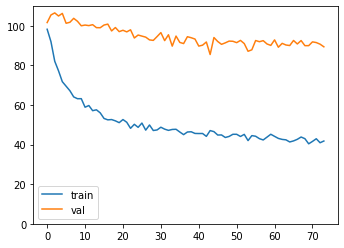

In [37]:
REQ_NAME = 'shadows_behind_head'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.7476 - accuracy: 0.5480 - precision: 0.6987 - recall: 0.5792 - f1: 0.6226 - specificity: 0.4914 - negative_predictive_value: 0.3716 - matthews_correlation_coefficient: 0.0701 - equal_error_rate: 0.4544 - val_loss: 0.6053 - val_accuracy: 0.6164 - val_precision: 0.8205 - val_recall: 0.5392 - val_f1: 0.6493 - val_specificity: 0.7654 - val_negative_predictive_value: 0.4512 - val_matthews_correlation_coefficient: 0.2875 - val_equal_error_rate: 0.3578

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28750, saving model to ../../models/siamese_networks/shadows_behind_head_2020_06_26-20_08_06.h5
Epoch 2/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7013 - accuracy: 0.5582 - precision: 0.7261 - recall: 0.5524 - f1: 0.6245 - specificity: 0.5769 - negative_predictive_value: 0.3880 - matthews_correlation_coefficient: 0.1

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6181 - accuracy: 0.6182 - precision: 0.7914 - recall: 0.5863 - f1: 0.6712 - specificity: 0.6878 - negative_predictive_value: 0.4512 - matthews_correlation_coefficient: 0.2577 - equal_error_rate: 0.3628 - val_loss: 0.5940 - val_accuracy: 0.5876 - val_precision: 0.9433 - val_recall: 0.4057 - val_f1: 0.5644 - val_specificity: 0.9501 - val_negative_predictive_value: 0.4420 - val_matthews_correlation_coefficient: 0.3694 - val_equal_error_rate: 0.3338

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.38795
Epoch 14/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6216 - accuracy: 0.6099 - precision: 0.7789 - recall: 0.5861 - f1: 0.6660 - specificity: 0.6613 - negative_predictive_value: 0.4408 - matthews_correlation_coefficient: 0.2330 - equal_error_rate: 0.3739 - val_loss: 0.5905 - val_accuracy: 0.5972 - val_precision: 0.9413 - val_recall: 0.4232 - val_f1: 0.5813 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6051 - accuracy: 0.6350 - precision: 0.7980 - recall: 0.6110 - f1: 0.6902 - specificity: 0.6852 - negative_predictive_value: 0.4641 - matthews_correlation_coefficient: 0.2785 - equal_error_rate: 0.3512 - val_loss: 0.6105 - val_accuracy: 0.5850 - val_precision: 0.9737 - val_recall: 0.3868 - val_f1: 0.5505 - val_specificity: 0.9780 - val_negative_predictive_value: 0.4414 - val_matthews_correlation_coefficient: 0.3881 - val_equal_error_rate: 0.3356

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.38813
Epoch 27/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6044 - accuracy: 0.6281 - precision: 0.7948 - recall: 0.6034 - f1: 0.6834 - specificity: 0.6801 - negative_predictive_value: 0.4590 - matthews_correlation_coefficient: 0.2681 - equal_error_rate: 0.3528 - val_loss: 0.6079 - val_accuracy: 0.5850 - val_precision: 0.9737 - val_recall: 0.3868 - val_f1: 0.5505 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6074 - accuracy: 0.6307 - precision: 0.8003 - recall: 0.5979 - f1: 0.6825 - specificity: 0.6972 - negative_predictive_value: 0.4611 - matthews_correlation_coefficient: 0.2775 - equal_error_rate: 0.3546 - val_loss: 0.6099 - val_accuracy: 0.5850 - val_precision: 0.9737 - val_recall: 0.3868 - val_f1: 0.5505 - val_specificity: 0.9780 - val_negative_predictive_value: 0.4414 - val_matthews_correlation_coefficient: 0.3881 - val_equal_error_rate: 0.3418

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.39042
Epoch 40/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6022 - accuracy: 0.6342 - precision: 0.8006 - recall: 0.6063 - f1: 0.6876 - specificity: 0.6889 - negative_predictive_value: 0.4636 - matthews_correlation_coefficient: 0.2791 - equal_error_rate: 0.3471 - val_loss: 0.6026 - val_accuracy: 0.5867 - val_precision: 0.9660 - val_recall: 0.3930 - val_f1: 0.5552 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6070 - accuracy: 0.6483 - precision: 0.8024 - recall: 0.6332 - f1: 0.7052 - specificity: 0.6816 - negative_predictive_value: 0.4777 - matthews_correlation_coefficient: 0.2967 - equal_error_rate: 0.3430 - val_loss: 0.6269 - val_accuracy: 0.5780 - val_precision: 0.9795 - val_recall: 0.3746 - val_f1: 0.5385 - val_specificity: 0.9829 - val_negative_predictive_value: 0.4378 - val_matthews_correlation_coefficient: 0.3852 - val_equal_error_rate: 0.3371

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.39042
Epoch 53/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6076 - accuracy: 0.6294 - precision: 0.7966 - recall: 0.6018 - f1: 0.6831 - specificity: 0.6862 - negative_predictive_value: 0.4600 - matthews_correlation_coefficient: 0.2717 - equal_error_rate: 0.3535 - val_loss: 0.6139 - val_accuracy: 0.5833 - val_precision: 0.9734 - val_recall: 0.3843 - val_f1: 0.5479 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.5955 - accuracy: 0.6387 - precision: 0.7999 - recall: 0.6151 - f1: 0.6930 - specificity: 0.6904 - negative_predictive_value: 0.4698 - matthews_correlation_coefficient: 0.2868 - equal_error_rate: 0.3474 - val_loss: 0.6181 - val_accuracy: 0.5824 - val_precision: 0.9734 - val_recall: 0.3831 - val_f1: 0.5468 - val_specificity: 0.9780 - val_negative_predictive_value: 0.4398 - val_matthews_correlation_coefficient: 0.3853 - val_equal_error_rate: 0.3370

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.39042
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6067 - accuracy: 0.6261 - precision: 0.7994 - recall: 0.5940 - f1: 0.6783 - specificity: 0.6908 - negative_predictive_value: 0.4560 - matthews_correlation_coefficient: 0.2696 - equal_error_rate: 0.3500 - val_loss: 0.6224 - val_accuracy: 0.5806 - val_precision: 0.9795 - val_recall: 0.3783 - val_f1: 0.5423 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6035 - accuracy: 0.6361 - precision: 0.8004 - recall: 0.6112 - f1: 0.6906 - specificity: 0.6900 - negative_predictive_value: 0.4677 - matthews_correlation_coefficient: 0.2841 - equal_error_rate: 0.3438 - val_loss: 0.6168 - val_accuracy: 0.5824 - val_precision: 0.9734 - val_recall: 0.3831 - val_f1: 0.5468 - val_specificity: 0.9780 - val_negative_predictive_value: 0.4398 - val_matthews_correlation_coefficient: 0.3853 - val_equal_error_rate: 0.3374

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.39042
Epoch 79/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6147 - accuracy: 0.6339 - precision: 0.7885 - recall: 0.6215 - f1: 0.6930 - specificity: 0.6613 - negative_predictive_value: 0.4646 - matthews_correlation_coefficient: 0.2674 - equal_error_rate: 0.3563 - val_loss: 0.6338 - val_accuracy: 0.5772 - val_precision: 0.9794 - val_recall: 0.3734 - val_f1: 0.5374 - val_specifici

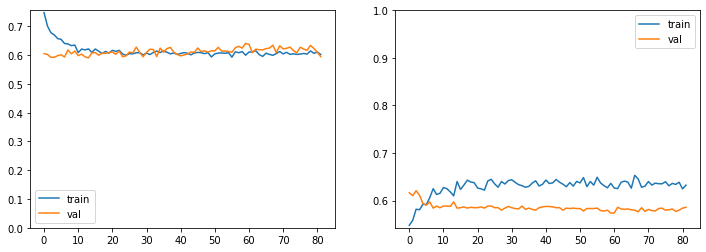

In [38]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 16. Shadows Across Face

158 of 158
141 of 141
(238, 224, 224, 3) float32
(238,) int32
(61, 224, 224, 3) float32
(61,) int32
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 81s 806ms/step - loss: 96.7945 - val_loss: 72.2046
Epoch 2/100
100/100 [==============================] - 76s 764ms/step - loss: 87.3143 - val_loss: 57.7139
Epoch 3/100
100/100 [==============================] - 78s 776ms/step - loss: 81.1505 - val_loss: 57.6816
Epoch 4/100
100/100 [==============================] - 78s 779ms/step - loss: 76.3576 - val_loss: 57.0635
Epoch 5/100
100/100 [==============================] - 77s 768ms/step - loss: 70.3957 - val_loss: 56.8203
Epoch 6/100
100/100 [==============================] - 77s 774ms/step - loss: 65.9728 - val_loss: 58.1699
Epoch 7/100
100/100 [==============================] - 76s 758ms/step - loss: 63.9283 - val_loss: 57.3229
Epoch 8/100
100/100 [==============================] - 77s 771ms/step - loss: 59.8889 - val_loss: 58.8966
Epoch 9/100
100/100 [==============================] - 77s 774ms/step - loss: 57.2614 - val_loss: 57.992

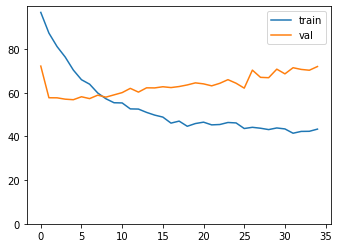

In [13]:
REQ_NAME = 'shadows_across_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.7089 - accuracy: 0.5663 - precision: 0.8459 - recall: 0.5636 - f1: 0.6736 - specificity: 0.5828 - negative_predictive_value: 0.2488 - matthews_correlation_coefficient: 0.1174 - equal_error_rate: 0.4249 - val_loss: 0.7820 - val_accuracy: 0.4446 - val_precision: 0.9254 - val_recall: 0.3341 - val_f1: 0.4897 - val_specificity: 0.8955 - val_negative_predictive_value: 0.2499 - val_matthews_correlation_coefficient: 0.2001 - val_equal_error_rate: 0.3782

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20011, saving model to ../../models/siamese_networks/shadows_across_face_2020_06_27-00_42_06.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6866 - accuracy: 0.5844 - precision: 0.8511 - recall: 0.5848 - f1: 0.6915 - specificity: 0.5867 - negative_predictive_value: 0.2604 - matthews_correlation_coefficient: 0.1

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6542 - accuracy: 0.5881 - precision: 0.8701 - recall: 0.5719 - f1: 0.6889 - specificity: 0.6563 - negative_predictive_value: 0.2753 - matthews_correlation_coefficient: 0.1813 - equal_error_rate: 0.3864 - val_loss: 0.7071 - val_accuracy: 0.4874 - val_precision: 0.9295 - val_recall: 0.3918 - val_f1: 0.5502 - val_specificity: 0.8886 - val_negative_predictive_value: 0.2660 - val_matthews_correlation_coefficient: 0.2338 - val_equal_error_rate: 0.3634

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.24092
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6510 - accuracy: 0.5870 - precision: 0.8712 - recall: 0.5695 - f1: 0.6878 - specificity: 0.6542 - negative_predictive_value: 0.2740 - matthews_correlation_coefficient: 0.1798 - equal_error_rate: 0.3818 - val_loss: 0.6972 - val_accuracy: 0.4978 - val_precision: 0.9222 - val_recall: 0.4094 - val_f1: 0.5662 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6426 - accuracy: 0.5816 - precision: 0.8721 - recall: 0.5605 - f1: 0.6802 - specificity: 0.6641 - negative_predictive_value: 0.2712 - matthews_correlation_coefficient: 0.1788 - equal_error_rate: 0.3809 - val_loss: 0.6761 - val_accuracy: 0.5118 - val_precision: 0.9177 - val_recall: 0.4314 - val_f1: 0.5857 - val_specificity: 0.8506 - val_negative_predictive_value: 0.2706 - val_matthews_correlation_coefficient: 0.2301 - val_equal_error_rate: 0.3587

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.24092
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6400 - accuracy: 0.5798 - precision: 0.8810 - recall: 0.5508 - f1: 0.6764 - specificity: 0.6984 - negative_predictive_value: 0.2772 - matthews_correlation_coefficient: 0.1980 - equal_error_rate: 0.3733 - val_loss: 0.6799 - val_accuracy: 0.5092 - val_precision: 0.9169 - val_recall: 0.4283 - val_f1: 0.5826 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6358 - accuracy: 0.5788 - precision: 0.8820 - recall: 0.5484 - f1: 0.6749 - specificity: 0.6972 - negative_predictive_value: 0.2775 - matthews_correlation_coefficient: 0.1976 - equal_error_rate: 0.3822 - val_loss: 0.6990 - val_accuracy: 0.4874 - val_precision: 0.9173 - val_recall: 0.3978 - val_f1: 0.5539 - val_specificity: 0.8638 - val_negative_predictive_value: 0.2621 - val_matthews_correlation_coefficient: 0.2163 - val_equal_error_rate: 0.3515

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.24092
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6397 - accuracy: 0.5694 - precision: 0.8819 - recall: 0.5361 - f1: 0.6647 - specificity: 0.7111 - negative_predictive_value: 0.2743 - matthews_correlation_coefficient: 0.1957 - equal_error_rate: 0.3818 - val_loss: 0.7118 - val_accuracy: 0.4786 - val_precision: 0.9239 - val_recall: 0.3835 - val_f1: 0.5408 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6356 - accuracy: 0.5977 - precision: 0.8782 - recall: 0.5778 - f1: 0.6950 - specificity: 0.6802 - negative_predictive_value: 0.2873 - matthews_correlation_coefficient: 0.2062 - equal_error_rate: 0.3672 - val_loss: 0.6930 - val_accuracy: 0.5083 - val_precision: 0.9205 - val_recall: 0.4262 - val_f1: 0.5815 - val_specificity: 0.8592 - val_negative_predictive_value: 0.2708 - val_matthews_correlation_coefficient: 0.2333 - val_equal_error_rate: 0.3579

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.25014
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6385 - accuracy: 0.5984 - precision: 0.8740 - recall: 0.5816 - f1: 0.6972 - specificity: 0.6639 - negative_predictive_value: 0.2826 - matthews_correlation_coefficient: 0.1956 - equal_error_rate: 0.3715 - val_loss: 0.7152 - val_accuracy: 0.4813 - val_precision: 0.9157 - val_recall: 0.3906 - val_f1: 0.5466 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6272 - accuracy: 0.6008 - precision: 0.8888 - recall: 0.5739 - f1: 0.6959 - specificity: 0.7132 - negative_predictive_value: 0.2938 - matthews_correlation_coefficient: 0.2284 - equal_error_rate: 0.3460 - val_loss: 0.6901 - val_accuracy: 0.5065 - val_precision: 0.9184 - val_recall: 0.4241 - val_f1: 0.5791 - val_specificity: 0.8555 - val_negative_predictive_value: 0.2690 - val_matthews_correlation_coefficient: 0.2286 - val_equal_error_rate: 0.3464

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.25014
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6312 - accuracy: 0.5936 - precision: 0.8939 - recall: 0.5603 - f1: 0.6870 - specificity: 0.7308 - negative_predictive_value: 0.2917 - matthews_correlation_coefficient: 0.2319 - equal_error_rate: 0.3565 - val_loss: 0.6798 - val_accuracy: 0.5118 - val_precision: 0.9196 - val_recall: 0.4303 - val_f1: 0.5853 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6376 - accuracy: 0.6025 - precision: 0.8799 - recall: 0.5855 - f1: 0.7011 - specificity: 0.6778 - negative_predictive_value: 0.2887 - matthews_correlation_coefficient: 0.2099 - equal_error_rate: 0.3626 - val_loss: 0.7115 - val_accuracy: 0.4874 - val_precision: 0.9173 - val_recall: 0.3978 - val_f1: 0.5539 - val_specificity: 0.8638 - val_negative_predictive_value: 0.2621 - val_matthews_correlation_coefficient: 0.2163 - val_equal_error_rate: 0.3547

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.25014
Epoch 79/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6394 - accuracy: 0.5958 - precision: 0.8825 - recall: 0.5725 - f1: 0.6931 - specificity: 0.6925 - negative_predictive_value: 0.2864 - matthews_correlation_coefficient: 0.2108 - equal_error_rate: 0.3689 - val_loss: 0.7022 - val_accuracy: 0.4926 - val_precision: 0.9166 - val_recall: 0.4063 - val_f1: 0.5617 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6388 - accuracy: 0.5833 - precision: 0.8818 - recall: 0.5540 - f1: 0.6793 - specificity: 0.7011 - negative_predictive_value: 0.2793 - matthews_correlation_coefficient: 0.2022 - equal_error_rate: 0.3657 - val_loss: 0.7328 - val_accuracy: 0.4568 - val_precision: 0.9207 - val_recall: 0.3543 - val_f1: 0.5107 - val_specificity: 0.8850 - val_negative_predictive_value: 0.2534 - val_matthews_correlation_coefficient: 0.2038 - val_equal_error_rate: 0.3612

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.25014
Epoch 92/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6383 - accuracy: 0.5796 - precision: 0.8838 - recall: 0.5488 - f1: 0.6753 - specificity: 0.7118 - negative_predictive_value: 0.2807 - matthews_correlation_coefficient: 0.2066 - equal_error_rate: 0.3682 - val_loss: 0.7264 - val_accuracy: 0.4664 - val_precision: 0.9234 - val_recall: 0.3669 - val_f1: 0.5241 - val_specifici

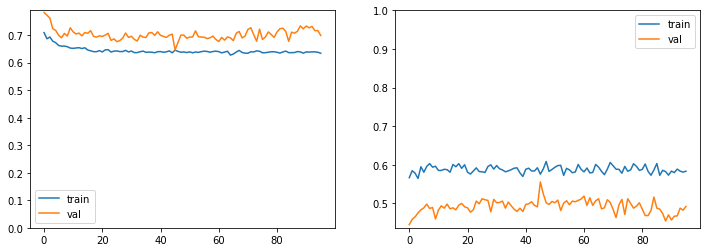

In [14]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 17. Dark Tinted Lenses

315 of 315
136 of 136
(360, 224, 224, 3) float32
(360,) int32
(91, 224, 224, 3) float32
(91,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 92s 917ms/step - loss: 98.6754 - val_loss: 96.3279
Epoch 2/100
100/100 [==============================] - 90s 897ms/step - loss: 95.9568 - val_loss: 89.2132
Epoch 3/100
100/100 [==============================] - 90s 903ms/step - loss: 92.6237 - val_loss: 88.7276
Epoch 4/100
100/100 [==============================] - 89s 889ms/step - loss: 90.7191 - val_loss: 92.0417
Epoch 5/100
100/100 [==============================] - 90s 899ms/step - loss: 89.9850 - val_loss: 93.3945
Epoch 6/100
100/100 [==============================] - 90s 903ms/step - loss: 88.7142 - val_loss: 94.4589
Epoch 7/100
100/100 [==============================] - 89s 889ms/step - loss: 87.4789 - val_loss: 95.3167
Epoch 8/100
100/100 [==============================] - 90s 898ms/step - loss: 85.9329 - val_loss: 95.2714
Epoch 9/100
100/100 [==============================] - 90s 903ms/step - loss: 84.3890 - val_loss: 96.9920
Epoch 10/100
100/100 [========================

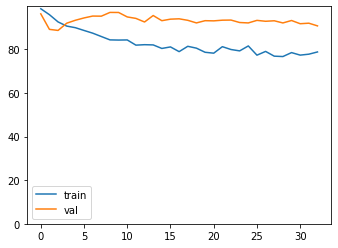

In [15]:
REQ_NAME = 'dark_tinted_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.9, 1.1),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7093 - accuracy: 0.6104 - precision: 0.9077 - recall: 0.6253 - f1: 0.7344 - specificity: 0.4788 - negative_predictive_value: 0.1384 - matthews_correlation_coefficient: 0.0686 - equal_error_rate: 0.4495 - val_loss: 0.6073 - val_accuracy: 0.4621 - val_precision: 0.9791 - val_recall: 0.4033 - val_f1: 0.5697 - val_specificity: 0.9352 - val_negative_predictive_value: 0.1603 - val_matthews_correlation_coefficient: 0.2152 - val_equal_error_rate: 0.3670

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21522, saving model to ../../models/siamese_networks/dark_tinted_lenses_2020_06_27-01_51_39.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6486 - accuracy: 0.5273 - precision: 0.9375 - recall: 0.5016 - f1: 0.6516 - specificity: 0.7384 - negative_predictive_value: 0.1550 - matthews_correlation_coefficient: 0.14

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5885 - accuracy: 0.5504 - precision: 0.9474 - recall: 0.5241 - f1: 0.6739 - specificity: 0.7705 - negative_predictive_value: 0.1668 - matthews_correlation_coefficient: 0.1810 - equal_error_rate: 0.3506 - val_loss: 0.6104 - val_accuracy: 0.5100 - val_precision: 0.9778 - val_recall: 0.4575 - val_f1: 0.6217 - val_specificity: 0.9179 - val_negative_predictive_value: 0.1708 - val_matthews_correlation_coefficient: 0.2340 - val_equal_error_rate: 0.3146

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.23410
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5920 - accuracy: 0.5395 - precision: 0.9485 - recall: 0.5099 - f1: 0.6621 - specificity: 0.7882 - negative_predictive_value: 0.1657 - matthews_correlation_coefficient: 0.1827 - equal_error_rate: 0.3599 - val_loss: 0.6039 - val_accuracy: 0.5126 - val_precision: 0.9780 - val_recall: 0.4603 - val_f1: 0.6243 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5767 - accuracy: 0.5414 - precision: 0.9558 - recall: 0.5068 - f1: 0.6616 - specificity: 0.8207 - negative_predictive_value: 0.1708 - matthews_correlation_coefficient: 0.2024 - equal_error_rate: 0.3394 - val_loss: 0.6286 - val_accuracy: 0.4752 - val_precision: 0.9820 - val_recall: 0.4153 - val_f1: 0.5824 - val_specificity: 0.9383 - val_negative_predictive_value: 0.1638 - val_matthews_correlation_coefficient: 0.2250 - val_equal_error_rate: 0.3136

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.24118
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5755 - accuracy: 0.5458 - precision: 0.9656 - recall: 0.5068 - f1: 0.6638 - specificity: 0.8516 - negative_predictive_value: 0.1776 - matthews_correlation_coefficient: 0.2248 - equal_error_rate: 0.3306 - val_loss: 0.6344 - val_accuracy: 0.4734 - val_precision: 0.9819 - val_recall: 0.4135 - val_f1: 0.5805 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5743 - accuracy: 0.5244 - precision: 0.9618 - recall: 0.4844 - f1: 0.6431 - specificity: 0.8531 - negative_predictive_value: 0.1702 - matthews_correlation_coefficient: 0.2096 - equal_error_rate: 0.3409 - val_loss: 0.6343 - val_accuracy: 0.4603 - val_precision: 0.9839 - val_recall: 0.3974 - val_f1: 0.5644 - val_specificity: 0.9433 - val_negative_predictive_value: 0.1606 - val_matthews_correlation_coefficient: 0.2197 - val_equal_error_rate: 0.3251

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.24118
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5774 - accuracy: 0.5288 - precision: 0.9601 - recall: 0.4903 - f1: 0.6482 - specificity: 0.8363 - negative_predictive_value: 0.1700 - matthews_correlation_coefficient: 0.2048 - equal_error_rate: 0.3377 - val_loss: 0.6375 - val_accuracy: 0.4586 - val_precision: 0.9838 - val_recall: 0.3955 - val_f1: 0.5623 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5740 - accuracy: 0.5203 - precision: 0.9711 - recall: 0.4751 - f1: 0.6366 - specificity: 0.8851 - negative_predictive_value: 0.1744 - matthews_correlation_coefficient: 0.2270 - equal_error_rate: 0.3393 - val_loss: 0.5986 - val_accuracy: 0.4734 - val_precision: 0.9819 - val_recall: 0.4137 - val_f1: 0.5807 - val_specificity: 0.9383 - val_negative_predictive_value: 0.1638 - val_matthews_correlation_coefficient: 0.2245 - val_equal_error_rate: 0.3307

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.24118
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5721 - accuracy: 0.5314 - precision: 0.9626 - recall: 0.4918 - f1: 0.6501 - specificity: 0.8458 - negative_predictive_value: 0.1729 - matthews_correlation_coefficient: 0.2130 - equal_error_rate: 0.3272 - val_loss: 0.6101 - val_accuracy: 0.4682 - val_precision: 0.9842 - val_recall: 0.4070 - val_f1: 0.5741 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5661 - accuracy: 0.5275 - precision: 0.9614 - recall: 0.4879 - f1: 0.6464 - specificity: 0.8501 - negative_predictive_value: 0.1710 - matthews_correlation_coefficient: 0.2098 - equal_error_rate: 0.3222 - val_loss: 0.6301 - val_accuracy: 0.4516 - val_precision: 0.9863 - val_recall: 0.3863 - val_f1: 0.5530 - val_specificity: 0.9508 - val_negative_predictive_value: 0.1596 - val_matthews_correlation_coefficient: 0.2197 - val_equal_error_rate: 0.3288

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.24118
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5749 - accuracy: 0.5301 - precision: 0.9630 - recall: 0.4903 - f1: 0.6486 - specificity: 0.8561 - negative_predictive_value: 0.1723 - matthews_correlation_coefficient: 0.2151 - equal_error_rate: 0.3462 - val_loss: 0.6143 - val_accuracy: 0.4595 - val_precision: 0.9865 - val_recall: 0.3947 - val_f1: 0.5618 - val_specifici

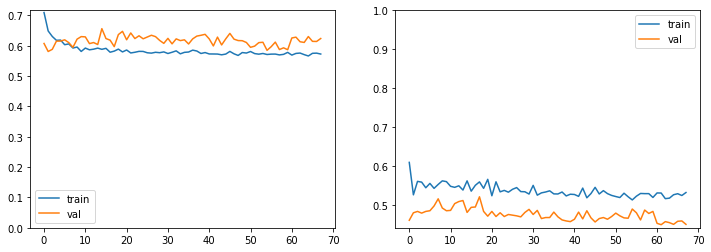

In [16]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 18. Flash Reflection on Lenses

437 of 437
363 of 363
(639, 224, 224, 3) float32
(639,) int32
(161, 224, 224, 3) float32
(161,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 77s 773ms/step - loss: 97.2231 - val_loss: 98.8485
Epoch 2/100
100/100 [==============================] - 72s 725ms/step - loss: 90.3494 - val_loss: 95.9882
Epoch 3/100
100/100 [==============================] - 73s 731ms/step - loss: 81.2411 - val_loss: 93.3334
Epoch 4/100
100/100 [==============================] - 74s 736ms/step - loss: 76.3191 - val_loss: 93.0438
Epoch 5/100
100/100 [==============================] - 74s 740ms/step - loss: 72.9067 - val_loss: 93.2382
Epoch 6/100
100/100 [==============================] - 74s 745ms/step - loss: 71.2141 - val_loss: 93.3152
Epoch 7/100
100/100 [==============================] - 75s 750ms/step - loss: 68.8346 - val_loss: 92.5300
Epoch 8/100
100/100 [==============================] - 76s 756ms/step - loss: 67.3500 - val_loss: 92.9015
Epoch 9/100
100/100 [==============================] - 77s 772ms/step - loss: 65.4775 - val_loss: 93.0403
Epoch 10/100
100/100 [========================

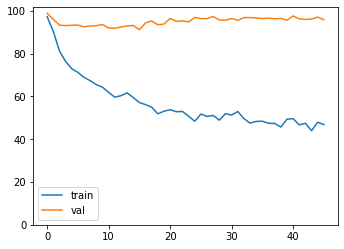

In [17]:
REQ_NAME = 'flash_reflection_on_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 14s 3ms/step - loss: 0.7207 - accuracy: 0.5705 - precision: 0.8371 - recall: 0.5755 - f1: 0.6783 - specificity: 0.5479 - negative_predictive_value: 0.2464 - matthews_correlation_coefficient: 0.1012 - equal_error_rate: 0.4288 - val_loss: 0.6894 - val_accuracy: 0.4699 - val_precision: 0.9501 - val_recall: 0.3543 - val_f1: 0.5134 - val_specificity: 0.9255 - val_negative_predictive_value: 0.2676 - val_matthews_correlation_coefficient: 0.2463 - val_equal_error_rate: 0.3276

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.24631, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_27-03_03_02.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6678 - accuracy: 0.5973 - precision: 0.8704 - recall: 0.5813 - f1: 0.6954 - specificity: 0.6600 - negative_predictive_value: 0.2858 - matthews_correlation_coefficie


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.27702
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5952 - accuracy: 0.6368 - precision: 0.8993 - recall: 0.6123 - f1: 0.7267 - specificity: 0.7285 - negative_predictive_value: 0.3254 - matthews_correlation_coefficient: 0.2759 - equal_error_rate: 0.3192 - val_loss: 0.6518 - val_accuracy: 0.5214 - val_precision: 0.9475 - val_recall: 0.4215 - val_f1: 0.5812 - val_specificity: 0.9092 - val_negative_predictive_value: 0.2865 - val_matthews_correlation_coefficient: 0.2778 - val_equal_error_rate: 0.3295

Epoch 00014: val_matthews_correlation_coefficient improved from 0.27702 to 0.27784, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_27-03_03_02.h5
Epoch 15/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5969 - accuracy: 0.6438 - precision: 0.8925 - recall: 0.6295 - f1: 0.7364 - specificity: 0.7000 - negative_predictive_value: 0.


Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.27967
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5871 - accuracy: 0.6490 - precision: 0.9001 - recall: 0.6290 - f1: 0.7389 - specificity: 0.7278 - negative_predictive_value: 0.3332 - matthews_correlation_coefficient: 0.2878 - equal_error_rate: 0.3221 - val_loss: 0.6530 - val_accuracy: 0.5161 - val_precision: 0.9493 - val_recall: 0.4141 - val_f1: 0.5744 - val_specificity: 0.9136 - val_negative_predictive_value: 0.2847 - val_matthews_correlation_coefficient: 0.2766 - val_equal_error_rate: 0.3295

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.27967
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5869 - accuracy: 0.6370 - precision: 0.9055 - recall: 0.6085 - f1: 0.7262 - specificity: 0.7518 - negative_predictive_value: 0.3295 - matthews_correlation_coefficient: 0.2902 - equal_error_rate: 0.3185 - val_loss: 0.6459 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5955 - accuracy: 0.6387 - precision: 0.8909 - recall: 0.6221 - f1: 0.7309 - specificity: 0.7046 - negative_predictive_value: 0.3227 - matthews_correlation_coefficient: 0.2633 - equal_error_rate: 0.3243 - val_loss: 0.6546 - val_accuracy: 0.5144 - val_precision: 0.9423 - val_recall: 0.4152 - val_f1: 0.5744 - val_specificity: 0.9016 - val_negative_predictive_value: 0.2824 - val_matthews_correlation_coefficient: 0.2665 - val_equal_error_rate: 0.3292

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.27967
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5911 - accuracy: 0.6392 - precision: 0.9040 - recall: 0.6128 - f1: 0.7280 - specificity: 0.7472 - negative_predictive_value: 0.3307 - matthews_correlation_coefficient: 0.2900 - equal_error_rate: 0.3207 - val_loss: 0.6428 - val_accuracy: 0.5214 - val_precision: 0.9392 - val_recall: 0.4257 - val_f1: 0.5836 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5827 - accuracy: 0.6534 - precision: 0.9002 - recall: 0.6355 - f1: 0.7438 - specificity: 0.7208 - negative_predictive_value: 0.3354 - matthews_correlation_coefficient: 0.2891 - equal_error_rate: 0.3176 - val_loss: 0.6355 - val_accuracy: 0.5100 - val_precision: 0.9418 - val_recall: 0.4099 - val_f1: 0.5691 - val_specificity: 0.9023 - val_negative_predictive_value: 0.2805 - val_matthews_correlation_coefficient: 0.2631 - val_equal_error_rate: 0.3379

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.27967
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5878 - accuracy: 0.6329 - precision: 0.9031 - recall: 0.6041 - f1: 0.7223 - specificity: 0.7511 - negative_predictive_value: 0.3250 - matthews_correlation_coefficient: 0.2839 - equal_error_rate: 0.3177 - val_loss: 0.6038 - val_accuracy: 0.5388 - val_precision: 0.9262 - val_recall: 0.4546 - val_f1: 0.6082 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5839 - accuracy: 0.6381 - precision: 0.9007 - recall: 0.6148 - f1: 0.7284 - specificity: 0.7296 - negative_predictive_value: 0.3279 - matthews_correlation_coefficient: 0.2800 - equal_error_rate: 0.3154 - val_loss: 0.6390 - val_accuracy: 0.5214 - val_precision: 0.9341 - val_recall: 0.4276 - val_f1: 0.5847 - val_specificity: 0.8860 - val_negative_predictive_value: 0.2834 - val_matthews_correlation_coefficient: 0.2608 - val_equal_error_rate: 0.3351

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.27967
Epoch 67/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5843 - accuracy: 0.6344 - precision: 0.8995 - recall: 0.6087 - f1: 0.7243 - specificity: 0.7385 - negative_predictive_value: 0.3243 - matthews_correlation_coefficient: 0.2779 - equal_error_rate: 0.3138 - val_loss: 0.6248 - val_accuracy: 0.5353 - val_precision: 0.9315 - val_recall: 0.4475 - val_f1: 0.6029 - val_specifici

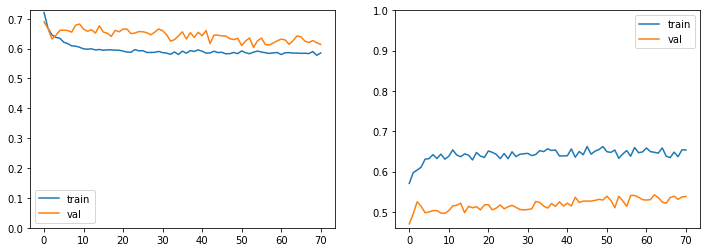

In [18]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### ~~19. Frames Too Heavy~~

#### 20. Frame Covering Eyes  

334 of 334
211 of 211
(435, 224, 224, 3) float32
(435,) int32
(110, 224, 224, 3) float32
(110,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 93s 929ms/step - loss: 100.5438 - val_loss: 96.5072
Epoch 2/100
100/100 [==============================] - 89s 891ms/step - loss: 100.2128 - val_loss: 94.7229
Epoch 3/100
100/100 [==============================] - 89s 890ms/step - loss: 99.9079 - val_loss: 93.2514
Epoch 4/100
100/100 [==============================] - 89s 891ms/step - loss: 99.2952 - val_loss: 89.2067
Epoch 5/100
100/100 [==============================] - 89s 891ms/step - loss: 98.5374 - val_loss: 85.3382
Epoch 6/100
100/100 [==============================] - 89s 890ms/step - loss: 98.9635 - val_loss: 84.1529
Epoch 7/100
100/100 [==============================] - 89s 890ms/step - loss: 98.7939 - val_loss: 84.5868
Epoch 8/100
100/100 [==============================] - 89s 890ms/step - loss: 97.2406 - val_loss: 79.5392
Epoch 9/100
100/100 [==============================] - 89s 890ms/step - loss: 97.8676 - val_loss: 84.5380
Epoch 10/100
100/100 [======================

100/100 [==============================] - 89s 890ms/step - loss: 86.5421 - val_loss: 71.4892
Epoch 78/100
100/100 [==============================] - 89s 891ms/step - loss: 82.1483 - val_loss: 74.4808
Epoch 79/100
100/100 [==============================] - 89s 889ms/step - loss: 83.0569 - val_loss: 78.3549
Epoch 80/100
100/100 [==============================] - 89s 892ms/step - loss: 84.1400 - val_loss: 75.0559
Epoch 81/100
100/100 [==============================] - 89s 891ms/step - loss: 83.3593 - val_loss: 72.9134
Epoch 82/100
100/100 [==============================] - 89s 890ms/step - loss: 85.1131 - val_loss: 71.8887
Epoch 83/100
100/100 [==============================] - 89s 889ms/step - loss: 83.3444 - val_loss: 74.5802
Epoch 84/100
100/100 [==============================] - 89s 890ms/step - loss: 82.5629 - val_loss: 75.8091
Epoch 85/100
100/100 [==============================] - 89s 890ms/step - loss: 85.4655 - val_loss: 73.4662
Epoch 86/100
100/100 [============================

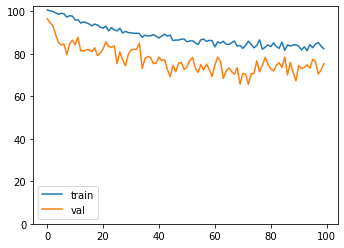

In [19]:
REQ_NAME = 'frame_covering_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7606 - accuracy: 0.5201 - precision: 0.7252 - recall: 0.5204 - f1: 0.6020 - specificity: 0.5213 - negative_predictive_value: 0.3108 - matthews_correlation_coefficient: 0.0386 - equal_error_rate: 0.4746 - val_loss: 0.8071 - val_accuracy: 0.3705 - val_precision: 0.8818 - val_recall: 0.1306 - val_f1: 0.2265 - val_specificity: 0.9537 - val_negative_predictive_value: 0.3129 - val_matthews_correlation_coefficient: 0.1274 - val_equal_error_rate: 0.3861

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.12736, saving model to ../../models/siamese_networks/frame_covering_eyes_2020_06_27-05_47_11.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7241 - accuracy: 0.5362 - precision: 0.7559 - recall: 0.5119 - f1: 0.6076 - specificity: 0.6013 - negative_predictive_value: 0.3367 - matthews_correlation_coefficient: 0.1


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.22865
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6560 - accuracy: 0.5672 - precision: 0.7999 - recall: 0.5232 - f1: 0.6278 - specificity: 0.6741 - negative_predictive_value: 0.3693 - matthews_correlation_coefficient: 0.1825 - equal_error_rate: 0.4049 - val_loss: 0.6723 - val_accuracy: 0.4891 - val_precision: 0.8773 - val_recall: 0.3242 - val_f1: 0.4712 - val_specificity: 0.8824 - val_negative_predictive_value: 0.3511 - val_matthews_correlation_coefficient: 0.2164 - val_equal_error_rate: 0.3883

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.22865
Epoch 15/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6475 - accuracy: 0.5633 - precision: 0.8100 - recall: 0.5015 - f1: 0.6176 - specificity: 0.7122 - negative_predictive_value: 0.3689 - matthews_correlation_coefficient: 0.1953 - equal_error_rate: 0.4050 - val_loss: 0.6600 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6372 - accuracy: 0.5700 - precision: 0.8135 - recall: 0.5126 - f1: 0.6263 - specificity: 0.7096 - negative_predictive_value: 0.3740 - matthews_correlation_coefficient: 0.2039 - equal_error_rate: 0.3946 - val_loss: 0.6344 - val_accuracy: 0.5187 - val_precision: 0.8666 - val_recall: 0.3803 - val_f1: 0.5258 - val_specificity: 0.8468 - val_negative_predictive_value: 0.3614 - val_matthews_correlation_coefficient: 0.2269 - val_equal_error_rate: 0.3747

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.22865
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6382 - accuracy: 0.5678 - precision: 0.8173 - recall: 0.5043 - f1: 0.6211 - specificity: 0.7281 - negative_predictive_value: 0.3762 - matthews_correlation_coefficient: 0.2119 - equal_error_rate: 0.3857 - val_loss: 0.6328 - val_accuracy: 0.5205 - val_precision: 0.8646 - val_recall: 0.3839 - val_f1: 0.5290 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6395 - accuracy: 0.5576 - precision: 0.8147 - recall: 0.4868 - f1: 0.6069 - specificity: 0.7346 - negative_predictive_value: 0.3703 - matthews_correlation_coefficient: 0.2021 - equal_error_rate: 0.3876 - val_loss: 0.6454 - val_accuracy: 0.5179 - val_precision: 0.8656 - val_recall: 0.3792 - val_f1: 0.5248 - val_specificity: 0.8473 - val_negative_predictive_value: 0.3611 - val_matthews_correlation_coefficient: 0.2261 - val_equal_error_rate: 0.3927

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.23363
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6337 - accuracy: 0.5713 - precision: 0.8205 - recall: 0.5044 - f1: 0.6226 - specificity: 0.7347 - negative_predictive_value: 0.3787 - matthews_correlation_coefficient: 0.2179 - equal_error_rate: 0.3798 - val_loss: 0.6361 - val_accuracy: 0.5266 - val_precision: 0.8666 - val_recall: 0.3923 - val_f1: 0.5378 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6387 - accuracy: 0.5740 - precision: 0.8188 - recall: 0.5169 - f1: 0.6298 - specificity: 0.7157 - negative_predictive_value: 0.3775 - matthews_correlation_coefficient: 0.2135 - equal_error_rate: 0.3846 - val_loss: 0.6356 - val_accuracy: 0.5275 - val_precision: 0.8669 - val_recall: 0.3934 - val_f1: 0.5390 - val_specificity: 0.8444 - val_negative_predictive_value: 0.3656 - val_matthews_correlation_coefficient: 0.2347 - val_equal_error_rate: 0.3916

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.23478
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6398 - accuracy: 0.5777 - precision: 0.8185 - recall: 0.5224 - f1: 0.6342 - specificity: 0.7180 - negative_predictive_value: 0.3824 - matthews_correlation_coefficient: 0.2195 - equal_error_rate: 0.3875 - val_loss: 0.6376 - val_accuracy: 0.5292 - val_precision: 0.8674 - val_recall: 0.3959 - val_f1: 0.5415 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6362 - accuracy: 0.5764 - precision: 0.8265 - recall: 0.5095 - f1: 0.6274 - specificity: 0.7395 - negative_predictive_value: 0.3841 - matthews_correlation_coefficient: 0.2288 - equal_error_rate: 0.3752 - val_loss: 0.6569 - val_accuracy: 0.5187 - val_precision: 0.8664 - val_recall: 0.3807 - val_f1: 0.5263 - val_specificity: 0.8474 - val_negative_predictive_value: 0.3617 - val_matthews_correlation_coefficient: 0.2276 - val_equal_error_rate: 0.4084

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.23677
Epoch 67/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6369 - accuracy: 0.5639 - precision: 0.8222 - recall: 0.4931 - f1: 0.6141 - specificity: 0.7361 - negative_predictive_value: 0.3727 - matthews_correlation_coefficient: 0.2111 - equal_error_rate: 0.3924 - val_loss: 0.6467 - val_accuracy: 0.5222 - val_precision: 0.8651 - val_recall: 0.3864 - val_f1: 0.5319 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6352 - accuracy: 0.5676 - precision: 0.8243 - recall: 0.4970 - f1: 0.6162 - specificity: 0.7413 - negative_predictive_value: 0.3777 - matthews_correlation_coefficient: 0.2192 - equal_error_rate: 0.3867 - val_loss: 0.6408 - val_accuracy: 0.5275 - val_precision: 0.8666 - val_recall: 0.3935 - val_f1: 0.5392 - val_specificity: 0.8444 - val_negative_predictive_value: 0.3657 - val_matthews_correlation_coefficient: 0.2346 - val_equal_error_rate: 0.3883

Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.23851
Epoch 80/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6372 - accuracy: 0.5750 - precision: 0.8269 - recall: 0.5096 - f1: 0.6282 - specificity: 0.7378 - negative_predictive_value: 0.3813 - matthews_correlation_coefficient: 0.2268 - equal_error_rate: 0.3795 - val_loss: 0.6418 - val_accuracy: 0.5283 - val_precision: 0.8673 - val_recall: 0.3946 - val_f1: 0.5402 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6363 - accuracy: 0.5606 - precision: 0.8273 - recall: 0.4823 - f1: 0.6068 - specificity: 0.7531 - negative_predictive_value: 0.3747 - matthews_correlation_coefficient: 0.2178 - equal_error_rate: 0.3883 - val_loss: 0.6295 - val_accuracy: 0.5318 - val_precision: 0.8616 - val_recall: 0.4031 - val_f1: 0.5468 - val_specificity: 0.8327 - val_negative_predictive_value: 0.3660 - val_matthews_correlation_coefficient: 0.2312 - val_equal_error_rate: 0.3876

Epoch 00092: val_matthews_correlation_coefficient did not improve from 0.24190
Epoch 93/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6358 - accuracy: 0.5620 - precision: 0.8222 - recall: 0.4888 - f1: 0.6104 - specificity: 0.7385 - negative_predictive_value: 0.3726 - matthews_correlation_coefficient: 0.2101 - equal_error_rate: 0.3876 - val_loss: 0.6339 - val_accuracy: 0.5353 - val_precision: 0.8635 - val_recall: 0.4094 - val_f1: 0.5526 - val_specifici

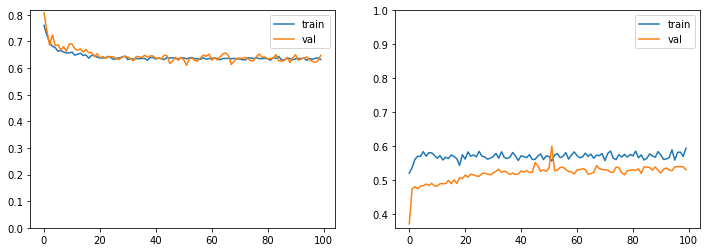

In [20]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 21. Hat/cap 

900 of 900
846 of 846
(1396, 224, 224, 3) float32
(1396,) int32
(350, 224, 224, 3) float32
(350,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 93s 934ms/step - loss: 100.4828 - val_loss: 95.0896
Epoch 2/100
100/100 [==============================] - 89s 889ms/step - loss: 99.7739 - val_loss: 92.2275
Epoch 3/100
100/100 [==============================] - 86s 856ms/step - loss: 97.9730 - val_loss: 88.7477
Epoch 4/100
100/100 [==============================] - 84s 838ms/step - loss: 98.1781 - val_loss: 90.3445
Epoch 5/100
100/100 [==============================] - 84s 837ms/step - loss: 96.9372 - val_loss: 90.7869
Epoch 6/100
100/100 [==============================] - 90s 899ms/step - loss: 96.8135 - val_loss: 93.4180
Epoch 7/100
100/100 [==============================] - 87s 866ms/step - loss: 96.4358 - val_loss: 93.2400
Epoch 8/100
100/100 [==============================] - 84s 839ms/step - loss: 96.3603 - val_loss: 93.9382
Epoch 9/100
100/100 [==============================] - 84s 836ms/step - loss: 94.1950 - val_loss: 93.3882
Epoch 10/100
100/100 [=======================

100/100 [==============================] - 91s 910ms/step - loss: 83.8923 - val_loss: 69.3154
Epoch 78/100
100/100 [==============================] - 88s 877ms/step - loss: 83.5859 - val_loss: 69.3955
Epoch 79/100
100/100 [==============================] - 84s 843ms/step - loss: 82.5386 - val_loss: 70.3725
Epoch 80/100
100/100 [==============================] - 84s 840ms/step - loss: 82.8297 - val_loss: 69.0648
Epoch 81/100
100/100 [==============================] - 92s 919ms/step - loss: 84.1640 - val_loss: 70.7191
Epoch 82/100
100/100 [==============================] - 88s 883ms/step - loss: 84.2484 - val_loss: 71.8749
Epoch 83/100
100/100 [==============================] - 85s 849ms/step - loss: 82.4398 - val_loss: 70.7784
Epoch 84/100
100/100 [==============================] - 84s 839ms/step - loss: 83.7983 - val_loss: 72.0759
Epoch 85/100
100/100 [==============================] - 84s 840ms/step - loss: 83.2975 - val_loss: 71.2579
Epoch 86/100
100/100 [============================

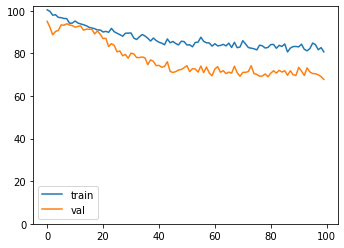

In [21]:
REQ_NAME = 'hat_cap'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 14s 3ms/step - loss: 0.7443 - accuracy: 0.5731 - precision: 0.8650 - recall: 0.5914 - f1: 0.6965 - specificity: 0.4648 - negative_predictive_value: 0.1621 - matthews_correlation_coefficient: 0.0389 - equal_error_rate: 0.4617 - val_loss: 0.6251 - val_accuracy: 0.4673 - val_precision: 0.9295 - val_recall: 0.4101 - val_f1: 0.5649 - val_specificity: 0.8099 - val_negative_predictive_value: 0.1907 - val_matthews_correlation_coefficient: 0.1617 - val_equal_error_rate: 0.3945

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.16175, saving model to ../../models/siamese_networks/hat_cap_2020_06_27-08_33_45.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6850 - accuracy: 0.5639 - precision: 0.8881 - recall: 0.5590 - f1: 0.6846 - specificity: 0.5957 - negative_predictive_value: 0.1897 - matthews_correlation_coefficient: 0.1093 - equal_


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.21284
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6413 - accuracy: 0.5582 - precision: 0.9079 - recall: 0.5356 - f1: 0.6721 - specificity: 0.6928 - negative_predictive_value: 0.2033 - matthews_correlation_coefficient: 0.1582 - equal_error_rate: 0.3879 - val_loss: 0.6927 - val_accuracy: 0.3810 - val_precision: 0.9831 - val_recall: 0.2810 - val_f1: 0.4350 - val_specificity: 0.9741 - val_negative_predictive_value: 0.1873 - val_matthews_correlation_coefficient: 0.2071 - val_equal_error_rate: 0.3937

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.21284
Epoch 15/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6342 - accuracy: 0.5286 - precision: 0.9122 - recall: 0.4948 - f1: 0.6406 - specificity: 0.7271 - negative_predictive_value: 0.1990 - matthews_correlation_coefficient: 0.1564 - equal_error_rate: 0.3934 - val_loss: 0.6661 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6224 - accuracy: 0.5404 - precision: 0.9196 - recall: 0.5054 - f1: 0.6499 - specificity: 0.7474 - negative_predictive_value: 0.2069 - matthews_correlation_coefficient: 0.1774 - equal_error_rate: 0.3765 - val_loss: 0.6696 - val_accuracy: 0.3836 - val_precision: 0.9835 - val_recall: 0.2839 - val_f1: 0.4388 - val_specificity: 0.9741 - val_negative_predictive_value: 0.1879 - val_matthews_correlation_coefficient: 0.2089 - val_equal_error_rate: 0.3891

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.21284
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6270 - accuracy: 0.5321 - precision: 0.9323 - recall: 0.4872 - f1: 0.6362 - specificity: 0.7993 - negative_predictive_value: 0.2147 - matthews_correlation_coefficient: 0.2041 - equal_error_rate: 0.3669 - val_loss: 0.6254 - val_accuracy: 0.3958 - val_precision: 0.9792 - val_recall: 0.2997 - val_f1: 0.4568 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6136 - accuracy: 0.5497 - precision: 0.9251 - recall: 0.5136 - f1: 0.6584 - specificity: 0.7611 - negative_predictive_value: 0.2154 - matthews_correlation_coefficient: 0.1955 - equal_error_rate: 0.3634 - val_loss: 0.7065 - val_accuracy: 0.3793 - val_precision: 0.9831 - val_recall: 0.2791 - val_f1: 0.4324 - val_specificity: 0.9741 - val_negative_predictive_value: 0.1870 - val_matthews_correlation_coefficient: 0.2060 - val_equal_error_rate: 0.3909

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.21284
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6282 - accuracy: 0.5356 - precision: 0.9147 - recall: 0.5029 - f1: 0.6473 - specificity: 0.7292 - negative_predictive_value: 0.2040 - matthews_correlation_coefficient: 0.1654 - equal_error_rate: 0.3856 - val_loss: 0.7032 - val_accuracy: 0.3793 - val_precision: 0.9831 - val_recall: 0.2791 - val_f1: 0.4324 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6223 - accuracy: 0.5303 - precision: 0.9262 - recall: 0.4890 - f1: 0.6386 - specificity: 0.7747 - negative_predictive_value: 0.2080 - matthews_correlation_coefficient: 0.1873 - equal_error_rate: 0.3815 - val_loss: 0.7091 - val_accuracy: 0.3793 - val_precision: 0.9831 - val_recall: 0.2791 - val_f1: 0.4324 - val_specificity: 0.9741 - val_negative_predictive_value: 0.1870 - val_matthews_correlation_coefficient: 0.2060 - val_equal_error_rate: 0.3860

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.21284
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6140 - accuracy: 0.5312 - precision: 0.9301 - recall: 0.4866 - f1: 0.6365 - specificity: 0.7908 - negative_predictive_value: 0.2121 - matthews_correlation_coefficient: 0.1972 - equal_error_rate: 0.3624 - val_loss: 0.6913 - val_accuracy: 0.3801 - val_precision: 0.9831 - val_recall: 0.2800 - val_f1: 0.4337 - val_specifici

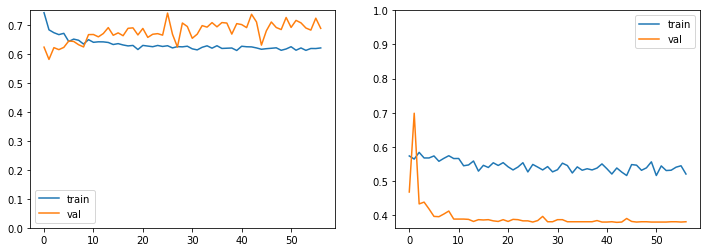

In [22]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### *22. Veil Over Face*

354 of 354
354 of 354
(566, 224, 224, 3) float32
(566,) int32
(142, 224, 224, 3) float32
(142,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 94s 936ms/step - loss: 97.0004 - val_loss: 80.8175
Epoch 2/100
100/100 [==============================] - 93s 934ms/step - loss: 92.7905 - val_loss: 76.5411
Epoch 3/100
100/100 [==============================] - 88s 881ms/step - loss: 88.0902 - val_loss: 76.3987
Epoch 4/100
100/100 [==============================] - 91s 909ms/step - loss: 86.6860 - val_loss: 78.2873
Epoch 5/100
100/100 [==============================] - 88s 881ms/step - loss: 83.8428 - val_loss: 76.7839
Epoch 6/100
100/100 [==============================] - 91s 909ms/step - loss: 81.7469 - val_loss: 77.7657
Epoch 7/100
100/100 [==============================] - 88s 883ms/step - loss: 79.3182 - val_loss: 76.4946
Epoch 8/100
100/100 [==============================] - 91s 914ms/step - loss: 79.1756 - val_loss: 77.1118
Epoch 9/100
100/100 [==============================] - 88s 881ms/step - loss: 78.5463 - val_loss: 78.6996
Epoch 10/100
100/100 [========================

100/100 [==============================] - 87s 870ms/step - loss: 64.6202 - val_loss: 68.1588
Epoch 78/100
100/100 [==============================] - 90s 897ms/step - loss: 66.4938 - val_loss: 67.0386
Epoch 79/100
100/100 [==============================] - 87s 869ms/step - loss: 64.1814 - val_loss: 67.7147
Epoch 80/100
100/100 [==============================] - 90s 896ms/step - loss: 63.5891 - val_loss: 67.0974
Epoch 81/100
100/100 [==============================] - 87s 870ms/step - loss: 63.0189 - val_loss: 69.3958
Epoch 82/100
100/100 [==============================] - 90s 898ms/step - loss: 64.8287 - val_loss: 67.4084
Epoch 83/100
100/100 [==============================] - 87s 870ms/step - loss: 63.6726 - val_loss: 67.7752
Epoch 84/100
100/100 [==============================] - 90s 896ms/step - loss: 60.6499 - val_loss: 67.9364
Epoch 85/100
100/100 [==============================] - 87s 869ms/step - loss: 64.0903 - val_loss: 67.6664
Epoch 86/100
100/100 [============================

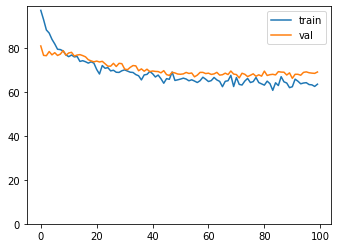

In [23]:
REQ_NAME = 'veil_over_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.8749 - accuracy: 0.7245 - precision: 0.9378 - recall: 0.7552 - f1: 0.8354 - specificity: 0.2729 - negative_predictive_value: 0.0576 - matthews_correlation_coefficient: 0.0015 - equal_error_rate: 0.4743 - val_loss: 0.4835 - val_accuracy: 0.9163 - val_precision: 0.9367 - val_recall: 0.9769 - val_f1: 0.9561 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.0323 - val_equal_error_rate: 0.4049

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.03232, saving model to ../../models/siamese_networks/veil_over_face_2020_06_27-11_15_32.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6176 - accuracy: 0.6806 - precision: 0.9686 - recall: 0.6823 - f1: 0.7993 - specificity: 0.6737 - negative_predictive_value: 0.1207 - matthews_correlation_coefficient


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.38532
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.4421 - accuracy: 0.8032 - precision: 0.9889 - recall: 0.7991 - f1: 0.8836 - specificity: 0.8630 - negative_predictive_value: 0.2186 - matthews_correlation_coefficient: 0.3649 - equal_error_rate: 0.1506 - val_loss: 0.4862 - val_accuracy: 0.8256 - val_precision: 0.9883 - val_recall: 0.8254 - val_f1: 0.8990 - val_specificity: 0.8214 - val_negative_predictive_value: 0.2426 - val_matthews_correlation_coefficient: 0.3824 - val_equal_error_rate: 0.1535

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.38532
Epoch 15/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.4330 - accuracy: 0.8024 - precision: 0.9898 - recall: 0.7977 - f1: 0.8831 - specificity: 0.8862 - negative_predictive_value: 0.2224 - matthews_correlation_coefficient: 0.3734 - equal_error_rate: 0.1475 - val_loss: 0.4830 - val_a

4584/4584 [==============================] - 11s 2ms/step - loss: 0.4134 - accuracy: 0.8106 - precision: 0.9921 - recall: 0.8042 - f1: 0.8880 - specificity: 0.9059 - negative_predictive_value: 0.2347 - matthews_correlation_coefficient: 0.3975 - equal_error_rate: 0.1462 - val_loss: 0.5110 - val_accuracy: 0.8265 - val_precision: 0.9884 - val_recall: 0.8263 - val_f1: 0.8996 - val_specificity: 0.8214 - val_negative_predictive_value: 0.2425 - val_matthews_correlation_coefficient: 0.3827 - val_equal_error_rate: 0.1544

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.38532
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.4249 - accuracy: 0.8030 - precision: 0.9892 - recall: 0.7986 - f1: 0.8834 - specificity: 0.8691 - negative_predictive_value: 0.2213 - matthews_correlation_coefficient: 0.3698 - equal_error_rate: 0.1593 - val_loss: 0.5172 - val_accuracy: 0.8248 - val_precision: 0.9883 - val_recall: 0.8245 - val_f1: 0.8985 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.4211 - accuracy: 0.8006 - precision: 0.9909 - recall: 0.7947 - f1: 0.8816 - specificity: 0.8986 - negative_predictive_value: 0.2218 - matthews_correlation_coefficient: 0.3757 - equal_error_rate: 0.1358 - val_loss: 0.5017 - val_accuracy: 0.8265 - val_precision: 0.9884 - val_recall: 0.8263 - val_f1: 0.8996 - val_specificity: 0.8214 - val_negative_predictive_value: 0.2425 - val_matthews_correlation_coefficient: 0.3827 - val_equal_error_rate: 0.1526

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.38546
Epoch 41/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.4168 - accuracy: 0.8058 - precision: 0.9916 - recall: 0.8002 - f1: 0.8852 - specificity: 0.9075 - negative_predictive_value: 0.2301 - matthews_correlation_coefficient: 0.3880 - equal_error_rate: 0.1395 - val_loss: 0.5046 - val_accuracy: 0.8282 - val_precision: 0.9884 - val_recall: 0.8280 - val_f1: 0.9006 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.4148 - accuracy: 0.8074 - precision: 0.9907 - recall: 0.8019 - f1: 0.8860 - specificity: 0.8880 - negative_predictive_value: 0.2253 - matthews_correlation_coefficient: 0.3808 - equal_error_rate: 0.1477 - val_loss: 0.4921 - val_accuracy: 0.8282 - val_precision: 0.9884 - val_recall: 0.8280 - val_f1: 0.9006 - val_specificity: 0.8214 - val_negative_predictive_value: 0.2452 - val_matthews_correlation_coefficient: 0.3855 - val_equal_error_rate: 0.1522

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.38546
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.4200 - accuracy: 0.8076 - precision: 0.9906 - recall: 0.8024 - f1: 0.8864 - specificity: 0.8922 - negative_predictive_value: 0.2282 - matthews_correlation_coefficient: 0.3844 - equal_error_rate: 0.1524 - val_loss: 0.5214 - val_accuracy: 0.8265 - val_precision: 0.9883 - val_recall: 0.8262 - val_f1: 0.8995 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.4110 - accuracy: 0.8078 - precision: 0.9919 - recall: 0.8017 - f1: 0.8863 - specificity: 0.8948 - negative_predictive_value: 0.2294 - matthews_correlation_coefficient: 0.3874 - equal_error_rate: 0.1499 - val_loss: 0.5277 - val_accuracy: 0.8265 - val_precision: 0.9883 - val_recall: 0.8262 - val_f1: 0.8995 - val_specificity: 0.8214 - val_negative_predictive_value: 0.2421 - val_matthews_correlation_coefficient: 0.3826 - val_equal_error_rate: 0.1521

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.38611
Epoch 67/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.4229 - accuracy: 0.8058 - precision: 0.9902 - recall: 0.8012 - f1: 0.8851 - specificity: 0.8974 - negative_predictive_value: 0.2269 - matthews_correlation_coefficient: 0.3822 - equal_error_rate: 0.1464 - val_loss: 0.5483 - val_accuracy: 0.8256 - val_precision: 0.9894 - val_recall: 0.8244 - val_f1: 0.8990 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.4030 - accuracy: 0.8074 - precision: 0.9922 - recall: 0.8013 - f1: 0.8861 - specificity: 0.9128 - negative_predictive_value: 0.2329 - matthews_correlation_coefficient: 0.3962 - equal_error_rate: 0.1387 - val_loss: 0.5277 - val_accuracy: 0.8256 - val_precision: 0.9894 - val_recall: 0.8244 - val_f1: 0.8990 - val_specificity: 0.8290 - val_negative_predictive_value: 0.2417 - val_matthews_correlation_coefficient: 0.3849 - val_equal_error_rate: 0.1499

Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.38611
Epoch 80/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.4216 - accuracy: 0.7997 - precision: 0.9915 - recall: 0.7933 - f1: 0.8811 - specificity: 0.8986 - negative_predictive_value: 0.2200 - matthews_correlation_coefficient: 0.3738 - equal_error_rate: 0.1511 - val_loss: 0.5422 - val_accuracy: 0.8256 - val_precision: 0.9894 - val_recall: 0.8244 - val_f1: 0.8990 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.4107 - accuracy: 0.8067 - precision: 0.9914 - recall: 0.8010 - f1: 0.8857 - specificity: 0.8936 - negative_predictive_value: 0.2298 - matthews_correlation_coefficient: 0.3880 - equal_error_rate: 0.1494 - val_loss: 0.5193 - val_accuracy: 0.8274 - val_precision: 0.9894 - val_recall: 0.8262 - val_f1: 0.9000 - val_specificity: 0.8290 - val_negative_predictive_value: 0.2440 - val_matthews_correlation_coefficient: 0.3873 - val_equal_error_rate: 0.1512

Epoch 00092: val_matthews_correlation_coefficient improved from 0.38611 to 0.38735, saving model to ../../models/siamese_networks/veil_over_face_2020_06_27-11_15_32.h5
Epoch 93/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.4027 - accuracy: 0.8058 - precision: 0.9918 - recall: 0.7996 - f1: 0.8850 - specificity: 0.9100 - negative_predictive_value: 0.2279 - matthews_correlation_coefficient: 0.3855 - equal_error_rate: 0.1369 - val_loss: 0.5210 - val_accur

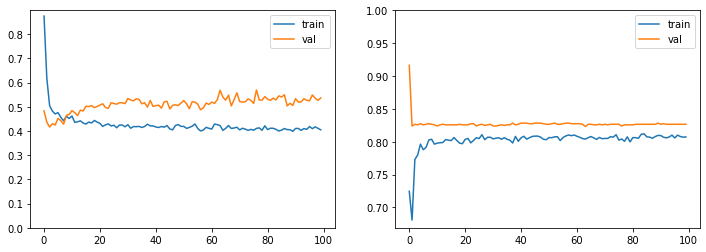

In [24]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 23. Mouth Open 

452 of 452
420 of 420
(697, 224, 224, 3) float32
(697,) int32
(175, 224, 224, 3) float32
(175,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 93s 933ms/step - loss: 99.2409 - val_loss: 97.4131
Epoch 2/100
100/100 [==============================] - 86s 856ms/step - loss: 98.1110 - val_loss: 96.3500
Epoch 3/100
100/100 [==============================] - 87s 866ms/step - loss: 96.9919 - val_loss: 97.5941
Epoch 4/100
100/100 [==============================] - 86s 858ms/step - loss: 96.6611 - val_loss: 97.5202
Epoch 5/100
100/100 [==============================] - 88s 876ms/step - loss: 95.5224 - val_loss: 98.5530
Epoch 6/100
100/100 [==============================] - 89s 886ms/step - loss: 95.5294 - val_loss: 96.9418
Epoch 7/100
100/100 [==============================] - 86s 857ms/step - loss: 95.0430 - val_loss: 95.2792
Epoch 8/100
100/100 [==============================] - 86s 862ms/step - loss: 94.1812 - val_loss: 94.4925
Epoch 9/100
100/100 [==============================] - 86s 860ms/step - loss: 93.4157 - val_loss: 92.7566
Epoch 10/100
100/100 [========================

100/100 [==============================] - 86s 857ms/step - loss: 81.0064 - val_loss: 89.8704
Epoch 78/100
100/100 [==============================] - 86s 860ms/step - loss: 83.5742 - val_loss: 90.2585
Epoch 79/100
100/100 [==============================] - 86s 857ms/step - loss: 79.2133 - val_loss: 91.5172
Epoch 80/100
100/100 [==============================] - 86s 857ms/step - loss: 81.7424 - val_loss: 89.4371
Epoch 81/100
100/100 [==============================] - 86s 859ms/step - loss: 79.3330 - val_loss: 88.2030
Restoring model weights from the end of the best epoch
Epoch 00081: early stopping


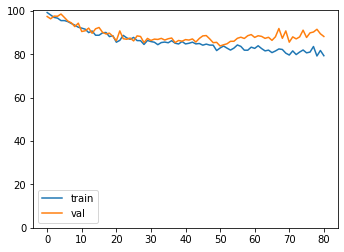

In [25]:
REQ_NAME = 'mouth_open'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 14s 3ms/step - loss: 0.8178 - accuracy: 0.4668 - precision: 0.7136 - recall: 0.4583 - f1: 0.5563 - specificity: 0.4908 - negative_predictive_value: 0.2477 - matthews_correlation_coefficient: -0.0444 - equal_error_rate: 0.5256 - val_loss: 0.7572 - val_accuracy: 0.3636 - val_precision: 0.7538 - val_recall: 0.2025 - val_f1: 0.3154 - val_specificity: 0.8134 - val_negative_predictive_value: 0.2683 - val_matthews_correlation_coefficient: 0.0185 - val_equal_error_rate: 0.5385

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.01855, saving model to ../../models/siamese_networks/mouth_open_2020_06_27-14_55_38.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7376 - accuracy: 0.5205 - precision: 0.7547 - recall: 0.5127 - f1: 0.6091 - specificity: 0.5376 - negative_predictive_value: 0.2859 - matthews_correlation_coefficient: 0.0452 - eq

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6542 - accuracy: 0.5676 - precision: 0.8262 - recall: 0.5208 - f1: 0.6375 - specificity: 0.6973 - negative_predictive_value: 0.3452 - matthews_correlation_coefficient: 0.1931 - equal_error_rate: 0.3910 - val_loss: 0.7358 - val_accuracy: 0.4595 - val_precision: 0.9006 - val_recall: 0.3000 - val_f1: 0.4487 - val_specificity: 0.9046 - val_negative_predictive_value: 0.3163 - val_matthews_correlation_coefficient: 0.2097 - val_equal_error_rate: 0.3482

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.24236
Epoch 15/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6492 - accuracy: 0.5938 - precision: 0.8272 - recall: 0.5669 - f1: 0.6708 - specificity: 0.6700 - negative_predictive_value: 0.3588 - matthews_correlation_coefficient: 0.2097 - equal_error_rate: 0.3770 - val_loss: 0.7378 - val_accuracy: 0.4621 - val_precision: 0.9012 - val_recall: 0.3032 - val_f1: 0.4523 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6463 - accuracy: 0.5783 - precision: 0.8314 - recall: 0.5359 - f1: 0.6486 - specificity: 0.6994 - negative_predictive_value: 0.3530 - matthews_correlation_coefficient: 0.2081 - equal_error_rate: 0.3870 - val_loss: 0.7254 - val_accuracy: 0.4725 - val_precision: 0.9033 - val_recall: 0.3180 - val_f1: 0.4692 - val_specificity: 0.9001 - val_negative_predictive_value: 0.3209 - val_matthews_correlation_coefficient: 0.2202 - val_equal_error_rate: 0.3515

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.24236
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6475 - accuracy: 0.5779 - precision: 0.8418 - recall: 0.5258 - f1: 0.6452 - specificity: 0.7267 - negative_predictive_value: 0.3562 - matthews_correlation_coefficient: 0.2233 - equal_error_rate: 0.3808 - val_loss: 0.7108 - val_accuracy: 0.4769 - val_precision: 0.9009 - val_recall: 0.3263 - val_f1: 0.4780 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6405 - accuracy: 0.5820 - precision: 0.8492 - recall: 0.5242 - f1: 0.6471 - specificity: 0.7438 - negative_predictive_value: 0.3609 - matthews_correlation_coefficient: 0.2370 - equal_error_rate: 0.3709 - val_loss: 0.7216 - val_accuracy: 0.4699 - val_precision: 0.8975 - val_recall: 0.3158 - val_f1: 0.4659 - val_specificity: 0.8925 - val_negative_predictive_value: 0.3183 - val_matthews_correlation_coefficient: 0.2112 - val_equal_error_rate: 0.3528

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.24236
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6401 - accuracy: 0.5862 - precision: 0.8509 - recall: 0.5313 - f1: 0.6524 - specificity: 0.7417 - negative_predictive_value: 0.3639 - matthews_correlation_coefficient: 0.2418 - equal_error_rate: 0.3739 - val_loss: 0.7151 - val_accuracy: 0.4725 - val_precision: 0.8935 - val_recall: 0.3218 - val_f1: 0.4719 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6377 - accuracy: 0.5901 - precision: 0.8494 - recall: 0.5419 - f1: 0.6567 - specificity: 0.7318 - negative_predictive_value: 0.3667 - matthews_correlation_coefficient: 0.2428 - equal_error_rate: 0.3664 - val_loss: 0.6983 - val_accuracy: 0.4874 - val_precision: 0.8924 - val_recall: 0.3471 - val_f1: 0.4986 - val_specificity: 0.8772 - val_negative_predictive_value: 0.3249 - val_matthews_correlation_coefficient: 0.2201 - val_equal_error_rate: 0.3491
Restoring model weights from the end of the best epoch

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.24236
Epoch 00053: early stopping

   Final Accuracy:  50.65%
  Final Precision:  89.91%
     Final Recall:  37.01%
  Final F-measure:  52.44%
Final Specificity:  88.49%
        Final NPV:  33.62%
        Final MCC:  24.50%

[[269  35]
 [531 312]]
              precision    recall  f1-score   support

           0       0.34      0.88      0.49       

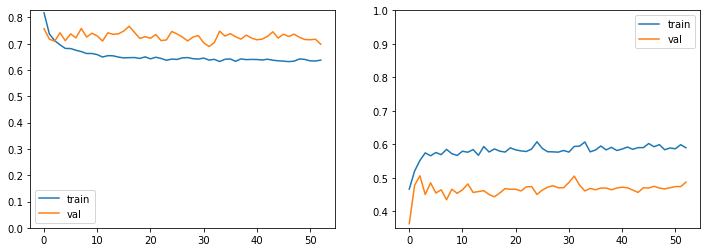

In [26]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### *24. Presence of Other Faces or Toys too Close to Face*

64 of 64
18 of 18
(65, 224, 224, 3) float32
(65,) int32
(17, 224, 224, 3) float32
(17,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 44s 439ms/step - loss: 100.7511 - val_loss: 99.2010
Epoch 2/100
100/100 [==============================] - 42s 420ms/step - loss: 100.0466 - val_loss: 98.9034
Epoch 3/100
100/100 [==============================] - 44s 442ms/step - loss: 100.3568 - val_loss: 99.2599
Epoch 4/100
100/100 [==============================] - 42s 422ms/step - loss: 99.5028 - val_loss: 99.1604
Epoch 5/100
100/100 [==============================] - 42s 423ms/step - loss: 99.3898 - val_loss: 98.9321
Epoch 6/100
100/100 [==============================] - 42s 420ms/step - loss: 98.5896 - val_loss: 98.6459
Epoch 7/100
100/100 [==============================] - 42s 421ms/step - loss: 99.5595 - val_loss: 98.5224
Epoch 8/100
100/100 [==============================] - 42s 420ms/step - loss: 97.9146 - val_loss: 98.3758
Epoch 9/100
100/100 [==============================] - 42s 421ms/step - loss: 99.2400 - val_loss: 98.3230
Epoch 10/100
100/100 [=====================

100/100 [==============================] - 42s 423ms/step - loss: 86.6916 - val_loss: 90.9174
Epoch 78/100
100/100 [==============================] - 42s 422ms/step - loss: 85.6350 - val_loss: 90.1545
Epoch 79/100
100/100 [==============================] - 42s 423ms/step - loss: 87.1608 - val_loss: 90.7738
Epoch 80/100
100/100 [==============================] - 42s 421ms/step - loss: 89.5502 - val_loss: 89.9547
Epoch 81/100
100/100 [==============================] - 43s 426ms/step - loss: 86.6618 - val_loss: 89.7964
Epoch 82/100
100/100 [==============================] - 43s 428ms/step - loss: 86.8170 - val_loss: 88.0962
Epoch 83/100
100/100 [==============================] - 43s 432ms/step - loss: 86.8636 - val_loss: 88.8838
Epoch 84/100
100/100 [==============================] - 42s 423ms/step - loss: 86.8598 - val_loss: 88.9500
Epoch 85/100
100/100 [==============================] - 42s 423ms/step - loss: 89.2752 - val_loss: 87.4198
Epoch 86/100
100/100 [============================

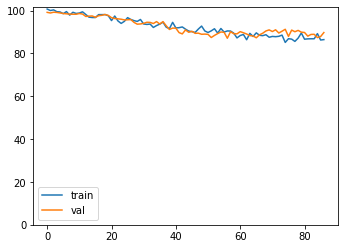

In [27]:
REQ_NAME = 'presence_of_other_faces_or_toys'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.8457 - accuracy: 0.5087 - precision: 0.9861 - recall: 0.5105 - f1: 0.6702 - specificity: 0.2971 - negative_predictive_value: 0.0106 - matthews_correlation_coefficient: -0.0136 - equal_error_rate: 0.2672 - val_loss: 0.7703 - val_accuracy: 0.3191 - val_precision: 0.9774 - val_recall: 0.3224 - val_f1: 0.4831 - val_specificity: 0.2250 - val_negative_predictive_value: 0.0061 - val_matthews_correlation_coefficient: -0.0579 - val_equal_error_rate: 0.2964

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.05787, saving model to ../../models/siamese_networks/presence_of_other_faces_or_toys_2020_06_27-16_09_20.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7592 - accuracy: 0.5441 - precision: 0.9878 - recall: 0.5454 - f1: 0.7014 - specificity: 0.2844 - negative_predictive_value: 0.0115 - matthews_correlation_c

4584/4584 [==============================] - 11s 2ms/step - loss: 0.6417 - accuracy: 0.6549 - precision: 0.9948 - recall: 0.6541 - f1: 0.7885 - specificity: 0.5091 - negative_predictive_value: 0.0248 - matthews_correlation_coefficient: 0.0695 - equal_error_rate: 0.1338 - val_loss: 0.7291 - val_accuracy: 0.4935 - val_precision: 1.0000 - val_recall: 0.4823 - val_f1: 0.6484 - val_specificity: 0.6667 - val_negative_predictive_value: 0.0215 - val_matthews_correlation_coefficient: 0.0792 - val_equal_error_rate: 0.0877

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.07957
Epoch 14/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5703 - accuracy: 0.6645 - precision: 0.9958 - recall: 0.6633 - f1: 0.7956 - specificity: 0.5634 - negative_predictive_value: 0.0269 - matthews_correlation_coefficient: 0.0837 - equal_error_rate: 0.1199 - val_loss: 0.6869 - val_accuracy: 0.5292 - val_precision: 0.9985 - val_recall: 0.5196 - val_f1: 0.6815 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.5506 - accuracy: 0.6721 - precision: 0.9954 - recall: 0.6711 - f1: 0.8011 - specificity: 0.4986 - negative_predictive_value: 0.0271 - matthews_correlation_coefficient: 0.0769 - equal_error_rate: 0.1051 - val_loss: 0.6382 - val_accuracy: 0.6190 - val_precision: 0.9986 - val_recall: 0.6102 - val_f1: 0.7558 - val_specificity: 0.5833 - val_negative_predictive_value: 0.0259 - val_matthews_correlation_coefficient: 0.0858 - val_equal_error_rate: 0.0784

Epoch 00026: val_matthews_correlation_coefficient improved from 0.08129 to 0.08578, saving model to ../../models/siamese_networks/presence_of_other_faces_or_toys_2020_06_27-16_09_20.h5
Epoch 27/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5960 - accuracy: 0.6579 - precision: 0.9947 - recall: 0.6574 - f1: 0.7909 - specificity: 0.5562 - negative_predictive_value: 0.0257 - matthews_correlation_coefficient: 0.0750 - equal_error_rate: 0.1440 - val_loss: 0

4584/4584 [==============================] - 11s 2ms/step - loss: 0.5131 - accuracy: 0.6952 - precision: 0.9959 - recall: 0.6943 - f1: 0.8175 - specificity: 0.5453 - negative_predictive_value: 0.0306 - matthews_correlation_coefficient: 0.0902 - equal_error_rate: 0.1051 - val_loss: 0.6256 - val_accuracy: 0.6731 - val_precision: 0.9975 - val_recall: 0.6672 - val_f1: 0.7984 - val_specificity: 0.5417 - val_negative_predictive_value: 0.0279 - val_matthews_correlation_coefficient: 0.0860 - val_equal_error_rate: 0.0864

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.09918
Epoch 40/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5341 - accuracy: 0.6887 - precision: 0.9957 - recall: 0.6878 - f1: 0.8130 - specificity: 0.5072 - negative_predictive_value: 0.0285 - matthews_correlation_coefficient: 0.0823 - equal_error_rate: 0.1009 - val_loss: 0.6140 - val_accuracy: 0.6844 - val_precision: 0.9963 - val_recall: 0.6801 - val_f1: 0.8071 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.5461 - accuracy: 0.6983 - precision: 0.9954 - recall: 0.6974 - f1: 0.8193 - specificity: 0.4692 - negative_predictive_value: 0.0287 - matthews_correlation_coefficient: 0.0803 - equal_error_rate: 0.1064 - val_loss: 0.6668 - val_accuracy: 0.5876 - val_precision: 0.9986 - val_recall: 0.5770 - val_f1: 0.7294 - val_specificity: 0.5833 - val_negative_predictive_value: 0.0241 - val_matthews_correlation_coefficient: 0.0798 - val_equal_error_rate: 0.0848

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.09918
Epoch 53/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5306 - accuracy: 0.6678 - precision: 0.9971 - recall: 0.6657 - f1: 0.7976 - specificity: 0.6123 - negative_predictive_value: 0.0304 - matthews_correlation_coefficient: 0.0994 - equal_error_rate: 0.1114 - val_loss: 0.5999 - val_accuracy: 0.6957 - val_precision: 0.9976 - val_recall: 0.6893 - val_f1: 0.8139 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.5373 - accuracy: 0.6736 - precision: 0.9963 - recall: 0.6722 - f1: 0.8021 - specificity: 0.5899 - negative_predictive_value: 0.0299 - matthews_correlation_coefficient: 0.0939 - equal_error_rate: 0.0907 - val_loss: 0.6254 - val_accuracy: 0.6652 - val_precision: 0.9987 - val_recall: 0.6579 - val_f1: 0.7920 - val_specificity: 0.5833 - val_negative_predictive_value: 0.0300 - val_matthews_correlation_coefficient: 0.0974 - val_equal_error_rate: 0.0847

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.09918
Epoch 66/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5245 - accuracy: 0.6795 - precision: 0.9955 - recall: 0.6788 - f1: 0.8066 - specificity: 0.4746 - negative_predictive_value: 0.0286 - matthews_correlation_coefficient: 0.0780 - equal_error_rate: 0.1013 - val_loss: 0.6264 - val_accuracy: 0.6574 - val_precision: 0.9987 - val_recall: 0.6503 - val_f1: 0.7864 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.5566 - accuracy: 0.6688 - precision: 0.9948 - recall: 0.6685 - f1: 0.7991 - specificity: 0.4692 - negative_predictive_value: 0.0256 - matthews_correlation_coefficient: 0.0689 - equal_error_rate: 0.1077 - val_loss: 0.6516 - val_accuracy: 0.6216 - val_precision: 0.9986 - val_recall: 0.6128 - val_f1: 0.7580 - val_specificity: 0.5833 - val_negative_predictive_value: 0.0262 - val_matthews_correlation_coefficient: 0.0866 - val_equal_error_rate: 0.0864

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.09918
Epoch 79/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5453 - accuracy: 0.6708 - precision: 0.9954 - recall: 0.6697 - f1: 0.8002 - specificity: 0.5815 - negative_predictive_value: 0.0274 - matthews_correlation_coefficient: 0.0848 - equal_error_rate: 0.1229 - val_loss: 0.6341 - val_accuracy: 0.6539 - val_precision: 0.9987 - val_recall: 0.6460 - val_f1: 0.7832 - val_specifici

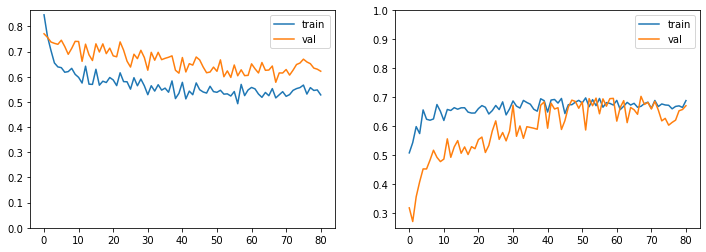

In [28]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

# Models Merge

In [46]:
def load_shared_model(file_autoencoder):
    autoencoder = load_model(file_autoencoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    embeddings = GlobalAvgPool2D(name='embeddings')(encoder_output)
    shared_model = Model(inputs=autoencoder.inputs, outputs=embeddings)
    return shared_model


def add_requirement_branch_to_base_model(base_model, req_model):
    n_layers = len(base_model.layers)
    req_layers = [layer for layer in req_model.layers[n_layers:] if not isinstance(layer, Dropout)]

    outputs = base_model.output
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)
    return outputs

In [47]:
shared_model = load_shared_model(FILE_BASE_MODEL)
shared_model.summary()

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 112, 112, 32)      128

In [48]:
list_model_files = [
    '../../models/siamese_networks/blurred_2020_06_25-23_53_18.h5',
    '../../models/siamese_networks/looking_away_2020_06_26-01_26_20.h5',
    '../../models/siamese_networks/unnatural_skin_tone_2020_06_26-02_25_13.h5',
    '../../models/siamese_networks/too_dark_light_2020_06_26-03_31_20.h5',
    '../../models/siamese_networks/washed_out_2020_06_26-04_21_44.h5',
    '../../models/siamese_networks/pixelation_2020_06_26-05_27_38.h5',
    '../../models/siamese_networks/hair_across_eyes_2020_06_26-08_24_05.h5',
    '../../models/siamese_networks/eyes_closed_2020_06_26-10_12_43.h5',
    '../../models/siamese_networks/varied_background_2020_06_26-11_35_12.h5',
    '../../models/siamese_networks/roll_pitch_yaw_2020_06_26-13_26_12.h5',
    '../../models/siamese_networks/flash_reflection_on_skin_2020_06_26-15_37_59.h5',
    '../../models/siamese_networks/red_eyes_2020_06_26-18_03_55.h5',
    '../../models/siamese_networks/shadows_behind_head_2020_06_26-20_08_06.h5',
    '../../models/siamese_networks/shadows_across_face_2020_06_27-00_42_06.h5',
    '../../models/siamese_networks/dark_tinted_lenses_2020_06_27-01_51_39.h5',
    '../../models/siamese_networks/flash_reflection_on_lenses_2020_06_27-03_03_02.h5',
    '../../models/siamese_networks/frame_covering_eyes_2020_06_2
    7-05_47_11.h5',
    '../../models/siamese_networks/hat_cap_2020_06_27-08_33_45.h5',
    '../../models/siamese_networks/veil_over_face_2020_06_27-11_15_32.h5',
    '../../models/siamese_networks/mouth_open_2020_06_27-14_55_38.h5',
    '../../models/siamese_networks/presence_of_other_faces_or_toys_2020_06_27-16_09_20.h5'
]

In [49]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc,
    'equal_error_rate': eer
}

list_models = [load_model(file, custom_objects=custom_objects) for file in list_model_files]
list_outputs = [add_requirement_branch_to_base_model(shared_model, req_model) for req_model in list_models]

In [50]:
FILE_MERGED_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix='merged_model_')
print(FILE_MERGED_MODEL)

merged_model = Model(inputs=shared_model.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

../../models/siamese_networks/merged_model_2020_06_28-11_53_03.h5
Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
_________________________

In [51]:
import cv2
from glob import glob

list_files = ['../../data/cropped_faces/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../../data/cropped_faces/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.7071196]], dtype=float32),
 array([[0.48365042]], dtype=float32),
 array([[0.54122055]], dtype=float32),
 array([[0.5250537]], dtype=float32),
 array([[0.40598112]], dtype=float32),
 array([[0.5331623]], dtype=float32),
 array([[0.44736663]], dtype=float32),
 array([[0.47301117]], dtype=float32),
 array([[0.22752652]], dtype=float32),
 array([[0.54602355]], dtype=float32),
 array([[0.27490836]], dtype=float32),
 array([[0.3510557]], dtype=float32),
 array([[0.8861191]], dtype=float32),
 array([[0.54528487]], dtype=float32),
 array([[0.37672397]], dtype=float32),
 array([[0.34709185]], dtype=float32),
 array([[0.46331304]], dtype=float32),
 array([[0.8805362]], dtype=float32),
 array([[0.13576454]], dtype=float32),
 array([[0.45444015]], dtype=float32),
 array([[0.8171744]], dtype=float32)]

In [52]:
print(np.array(list_model_files))

['../../models/siamese_networks/blurred_2020_06_25-23_53_18.h5'
 '../../models/siamese_networks/looking_away_2020_06_26-01_26_20.h5'
 '../../models/siamese_networks/unnatural_skin_tone_2020_06_26-02_25_13.h5'
 '../../models/siamese_networks/too_dark_light_2020_06_26-03_31_20.h5'
 '../../models/siamese_networks/washed_out_2020_06_26-04_21_44.h5'
 '../../models/siamese_networks/pixelation_2020_06_26-05_27_38.h5'
 '../../models/siamese_networks/hair_across_eyes_2020_06_26-08_24_05.h5'
 '../../models/siamese_networks/eyes_closed_2020_06_26-10_12_43.h5'
 '../../models/siamese_networks/varied_background_2020_06_26-11_35_12.h5'
 '../../models/siamese_networks/roll_pitch_yaw_2020_06_26-13_26_12.h5'
 '../../models/siamese_networks/flash_reflection_on_skin_2020_06_26-15_37_59.h5'
 '../../models/siamese_networks/red_eyes_2020_06_26-18_03_55.h5'
 '../../models/siamese_networks/shadows_behind_head_2020_06_26-20_08_06.h5'
 '../../models/siamese_networks/shadows_across_face_2020_06_27-00_42_06.h5'
 '

In [ ]:
MERGE